In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor
from gmdhpy import gmdh 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.model_selection import cross_val_score, cross_validate, KFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data = pd.read_csv('data.csv', sep=",")

<h3>Проведём анализ данных</h3>

In [3]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [4]:
data.dtypes

date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

In [5]:
data.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [6]:
data.street.unique(), data.city.unique(), data.statezip.unique(), data.country.unique()

(array(['18810 Densmore Ave N', '709 W Blaine St',
        '26206-26214 143rd Ave SE', ..., '759 Ilwaco Pl NE',
        '5148 S Creston St', '18717 SE 258th St'], dtype=object),
 array(['Shoreline', 'Seattle', 'Kent', 'Bellevue', 'Redmond',
        'Maple Valley', 'North Bend', 'Lake Forest Park', 'Sammamish',
        'Auburn', 'Des Moines', 'Bothell', 'Federal Way', 'Kirkland',
        'Issaquah', 'Woodinville', 'Normandy Park', 'Fall City', 'Renton',
        'Carnation', 'Snoqualmie', 'Duvall', 'Burien', 'Covington',
        'Inglewood-Finn Hill', 'Kenmore', 'Newcastle', 'Mercer Island',
        'Black Diamond', 'Ravensdale', 'Clyde Hill', 'Algona', 'Skykomish',
        'Tukwila', 'Vashon', 'Yarrow Point', 'SeaTac', 'Medina',
        'Enumclaw', 'Snoqualmie Pass', 'Pacific', 'Beaux Arts Village',
        'Preston', 'Milton'], dtype=object),
 array(['WA 98133', 'WA 98119', 'WA 98042', 'WA 98008', 'WA 98052',
        'WA 98115', 'WA 98038', 'WA 98045', 'WA 98155', 'WA 98105',
        '

In [7]:
le = LabelEncoder()
categorical_columns = data.select_dtypes('object').columns.values
for cat_col in categorical_columns:
    if cat_col != 'date':
        data[cat_col] = le.fit_transform(data[cat_col])
data[categorical_columns].head()

,date,street,city,statezip,country
0,2014-05-02 00:00:00,1522,36,62,0
1,2014-05-02 00:00:00,3899,35,58,0
2,2014-05-02 00:00:00,2291,18,26,0
3,2014-05-02 00:00:00,4263,3,7,0
4,2014-05-02 00:00:00,4352,31,31,0


In [8]:
from datetime import datetime
epoch = datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

data.date = [ unix_time_millis( datetime.strptime(date, '%Y-%m-%d 00:00:00') ) for date in data.date ]
data[categorical_columns].head()

,date,street,city,statezip,country
0,1.398989e+12,1522,36,62,0
1,1.398989e+12,3899,35,58,0
2,1.398989e+12,2291,18,26,0
3,1.398989e+12,4263,3,7,0
4,1.398989e+12,4352,31,31,0


In [9]:
data.corr().price

date             0.033906
price            1.000000
bedrooms         0.200336
bathrooms        0.327110
sqft_living      0.430410
sqft_lot         0.050451
floors           0.151461
waterfront       0.135648
view             0.228504
condition        0.034915
sqft_above       0.367570
sqft_basement    0.210427
yr_built         0.021857
yr_renovated    -0.028774
street           0.029366
city             0.018625
statezip        -0.043385
country               NaN
Name: price, dtype: float64

In [10]:
data.drop(['yr_renovated', 'statezip', 'country'], axis=1, inplace=True)

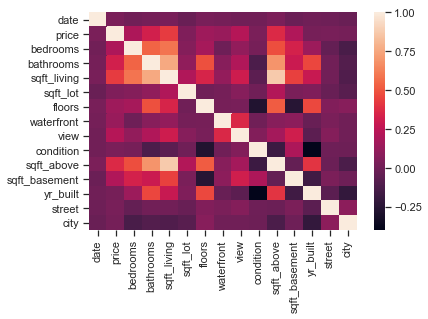

In [11]:
sns.heatmap(data.corr())

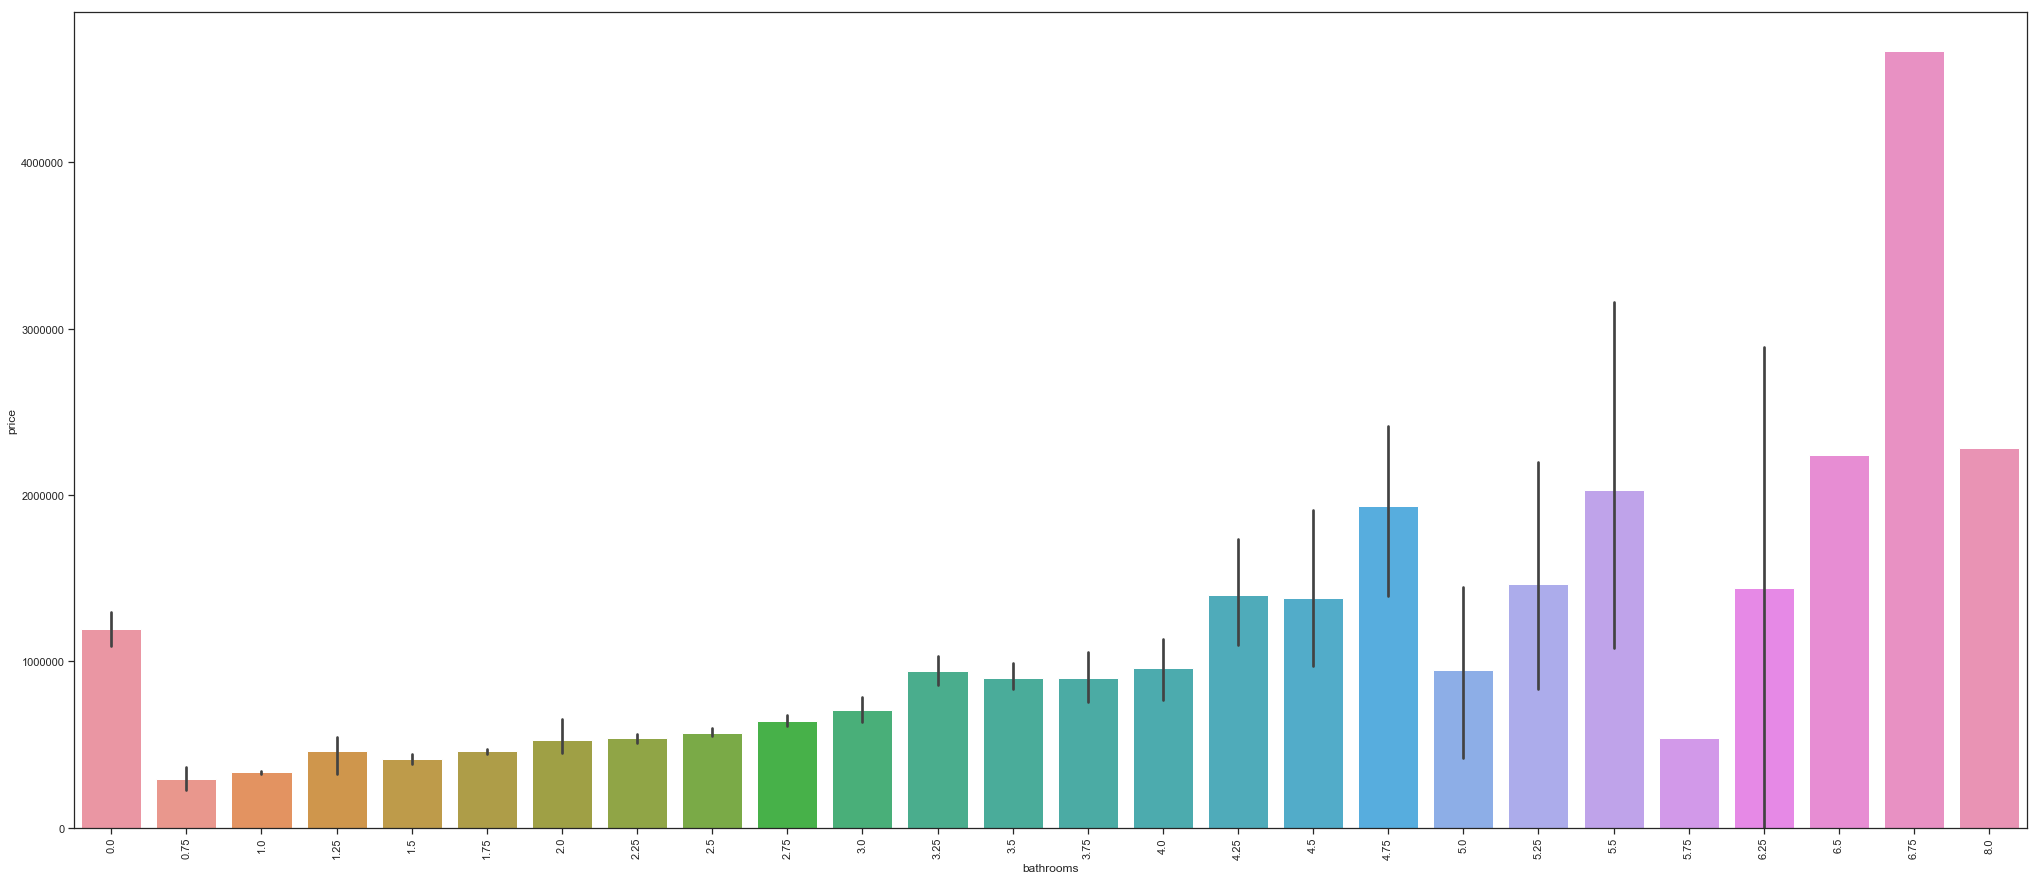

In [12]:
plt.figure(figsize=(35,15))
sns.barplot(x='bathrooms',y='price',data=data)
plt.xticks(rotation='vertical')
plt.show()

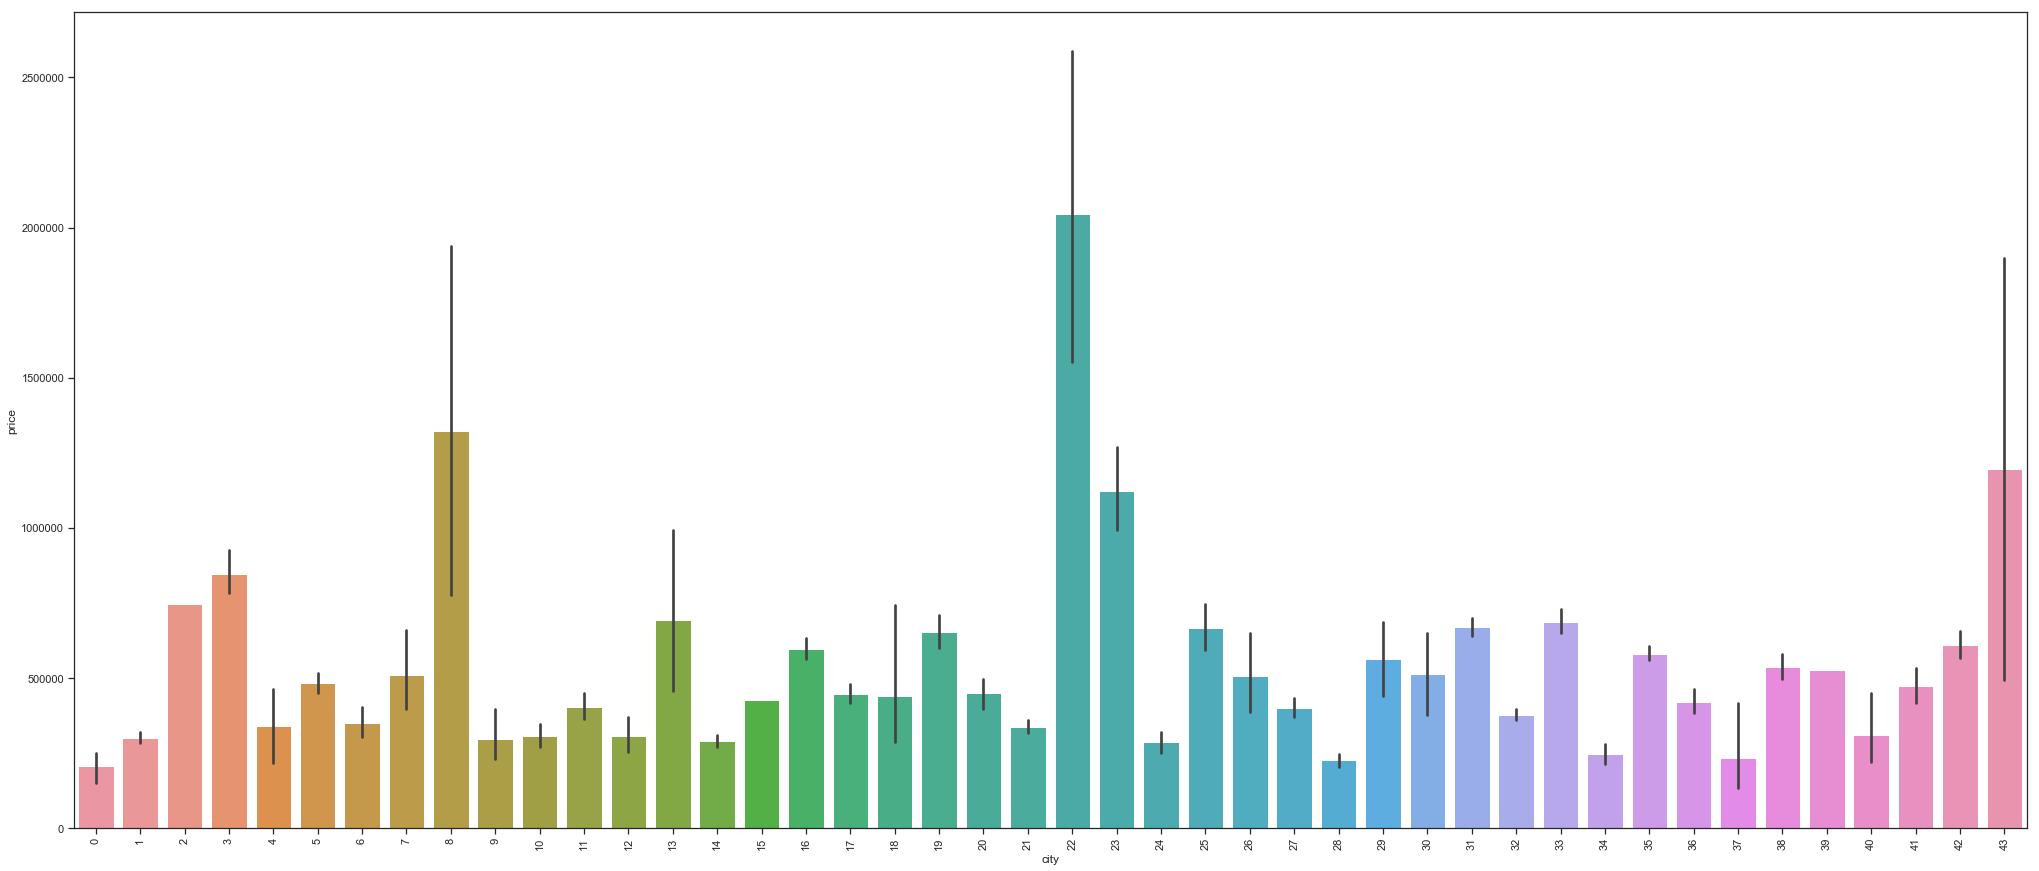

In [13]:
plt.figure(figsize=(35,15))
sns.barplot(x='city',y='price',data=data)
plt.xticks(rotation='vertical')
plt.show()

<h3>Сформируем обучающую и тестовую выборку</h3>

In [14]:
top = bottom = int(0.05 * data.price.shape[0])
data.sort_values(by=['price'],ascending=False, inplace=True)

DataParam = data[top:-bottom].drop('price', axis=1)
DataAnsw = data[top:-bottom].price
TrainX, TestX, TrainY, TestY = train_test_split(DataParam, DataAnsw, test_size=0.33, random_state=42)

<h3>Построим модели</h3>

In [15]:
LinReg = LinearRegression()  # линейная регрессия
BagReg = BaggingRegressor()  # бэгинг
DecTree = DecisionTreeRegressor()  # дерево решений
CatModel = CatBoostRegressor()  # кэтбуст
GmdModel = gmdh.Regressor()  # Метод группового учета аргументов

In [16]:
LinReg.fit(TrainX, TrainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
BagReg.fit(TrainX, TrainY)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [18]:
DecTree.fit(TrainX, TrainY)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [19]:
CatModel.fit(TrainX, TrainY)

0:	learn: 526291.9716500	total: 68.4ms	remaining: 1m 8s
1:	learn: 512555.8289850	total: 74.9ms	remaining: 37.4s
2:	learn: 499533.2949117	total: 81.1ms	remaining: 27s
3:	learn: 486670.4701177	total: 86.8ms	remaining: 21.6s
4:	learn: 474064.5690394	total: 92.7ms	remaining: 18.5s
5:	learn: 462429.6575041	total: 98.7ms	remaining: 16.4s
6:	learn: 450682.2304883	total: 105ms	remaining: 14.9s
7:	learn: 439459.8910176	total: 111ms	remaining: 13.8s
8:	learn: 428871.1895633	total: 117ms	remaining: 12.9s
9:	learn: 418349.1550066	total: 124ms	remaining: 12.2s
10:	learn: 408226.7596335	total: 130ms	remaining: 11.7s
11:	learn: 398570.5017477	total: 135ms	remaining: 11.1s
12:	learn: 388936.9092007	total: 142ms	remaining: 10.8s
13:	learn: 379641.9903308	total: 148ms	remaining: 10.4s
14:	learn: 370822.8549599	total: 154ms	remaining: 10.1s
15:	learn: 362290.1878054	total: 159ms	remaining: 9.8s
16:	learn: 353948.4954990	total: 165ms	remaining: 9.55s
17:	learn: 345916.5289301	total: 171ms	remaining: 9.31s

168:	learn: 134352.0355825	total: 1.05s	remaining: 5.17s
169:	learn: 134138.7172542	total: 1.06s	remaining: 5.16s
170:	learn: 133829.0147232	total: 1.06s	remaining: 5.15s
171:	learn: 133790.9350546	total: 1.07s	remaining: 5.14s
172:	learn: 133703.9137545	total: 1.07s	remaining: 5.13s
173:	learn: 133585.4279784	total: 1.08s	remaining: 5.13s
174:	learn: 133547.4586907	total: 1.09s	remaining: 5.13s
175:	learn: 133492.6523963	total: 1.09s	remaining: 5.12s
176:	learn: 133445.4509666	total: 1.1s	remaining: 5.11s
177:	learn: 133423.1664664	total: 1.1s	remaining: 5.09s
178:	learn: 133110.5414912	total: 1.11s	remaining: 5.09s
179:	learn: 132940.9181217	total: 1.11s	remaining: 5.08s
180:	learn: 132792.5919162	total: 1.12s	remaining: 5.07s
181:	learn: 132757.0128532	total: 1.13s	remaining: 5.06s
182:	learn: 132731.6600359	total: 1.13s	remaining: 5.05s
183:	learn: 132630.5270117	total: 1.14s	remaining: 5.04s
184:	learn: 132596.9316834	total: 1.14s	remaining: 5.03s
185:	learn: 132578.4339807	total:

343:	learn: 122978.1699949	total: 2.03s	remaining: 3.87s
344:	learn: 122951.5381887	total: 2.03s	remaining: 3.86s
345:	learn: 122945.8356207	total: 2.04s	remaining: 3.85s
346:	learn: 122761.3974094	total: 2.04s	remaining: 3.85s
347:	learn: 122626.3990122	total: 2.05s	remaining: 3.84s
348:	learn: 122589.2949642	total: 2.06s	remaining: 3.84s
349:	learn: 122570.0836806	total: 2.06s	remaining: 3.83s
350:	learn: 122568.3856894	total: 2.07s	remaining: 3.82s
351:	learn: 122374.5888385	total: 2.07s	remaining: 3.81s
352:	learn: 122358.5108115	total: 2.08s	remaining: 3.81s
353:	learn: 122333.6742045	total: 2.08s	remaining: 3.8s
354:	learn: 122321.7077043	total: 2.09s	remaining: 3.8s
355:	learn: 122002.7498014	total: 2.1s	remaining: 3.79s
356:	learn: 121971.9907642	total: 2.1s	remaining: 3.79s
357:	learn: 121951.8104302	total: 2.11s	remaining: 3.78s
358:	learn: 121923.4735578	total: 2.11s	remaining: 3.77s
359:	learn: 121849.1960634	total: 2.12s	remaining: 3.77s
360:	learn: 121834.3745126	total: 2

520:	learn: 116373.3870911	total: 2.99s	remaining: 2.75s
521:	learn: 116347.7154626	total: 3s	remaining: 2.75s
522:	learn: 116347.5303685	total: 3s	remaining: 2.74s
523:	learn: 116347.5117231	total: 3s	remaining: 2.73s
524:	learn: 116289.8171047	total: 3.01s	remaining: 2.72s
525:	learn: 116289.5862370	total: 3.02s	remaining: 2.72s
526:	learn: 116282.2421473	total: 3.02s	remaining: 2.71s
527:	learn: 116275.4226683	total: 3.03s	remaining: 2.71s
528:	learn: 116275.4075587	total: 3.03s	remaining: 2.7s
529:	learn: 116247.1918327	total: 3.04s	remaining: 2.69s
530:	learn: 116222.8107461	total: 3.04s	remaining: 2.69s
531:	learn: 116221.9719845	total: 3.05s	remaining: 2.68s
532:	learn: 116201.0488208	total: 3.05s	remaining: 2.67s
533:	learn: 116198.2934703	total: 3.06s	remaining: 2.67s
534:	learn: 116184.1195747	total: 3.06s	remaining: 2.66s
535:	learn: 116183.4113183	total: 3.07s	remaining: 2.66s
536:	learn: 116182.5990237	total: 3.07s	remaining: 2.65s
537:	learn: 116181.4125658	total: 3.08s	r

693:	learn: 112052.0606865	total: 3.95s	remaining: 1.74s
694:	learn: 112051.8195977	total: 3.95s	remaining: 1.74s
695:	learn: 112049.3451010	total: 3.96s	remaining: 1.73s
696:	learn: 112048.7733592	total: 3.96s	remaining: 1.72s
697:	learn: 111959.9970615	total: 3.97s	remaining: 1.72s
698:	learn: 111877.0457749	total: 3.98s	remaining: 1.71s
699:	learn: 111876.0673420	total: 3.98s	remaining: 1.71s
700:	learn: 111872.2347144	total: 3.99s	remaining: 1.7s
701:	learn: 111855.6684971	total: 3.99s	remaining: 1.7s
702:	learn: 111854.9595623	total: 4s	remaining: 1.69s
703:	learn: 111854.8927307	total: 4s	remaining: 1.68s
704:	learn: 111742.7990091	total: 4s	remaining: 1.68s
705:	learn: 111739.9088342	total: 4.01s	remaining: 1.67s
706:	learn: 111690.2011995	total: 4.02s	remaining: 1.66s
707:	learn: 111647.2981409	total: 4.02s	remaining: 1.66s
708:	learn: 111627.5185798	total: 4.03s	remaining: 1.65s
709:	learn: 111627.1390793	total: 4.03s	remaining: 1.65s
710:	learn: 111625.3187430	total: 4.04s	re

869:	learn: 109117.6018499	total: 4.91s	remaining: 734ms
870:	learn: 109090.9824379	total: 4.92s	remaining: 729ms
871:	learn: 109072.5457744	total: 4.92s	remaining: 723ms
872:	learn: 109072.2128817	total: 4.93s	remaining: 717ms
873:	learn: 108986.7062608	total: 4.93s	remaining: 711ms
874:	learn: 108985.9941475	total: 4.94s	remaining: 706ms
875:	learn: 108984.8891374	total: 4.95s	remaining: 700ms
876:	learn: 108970.9933104	total: 4.95s	remaining: 694ms
877:	learn: 108964.6114148	total: 4.96s	remaining: 689ms
878:	learn: 108944.0696378	total: 4.96s	remaining: 683ms
879:	learn: 108944.0481544	total: 4.97s	remaining: 677ms
880:	learn: 108944.0189425	total: 4.97s	remaining: 671ms
881:	learn: 108936.8577430	total: 4.98s	remaining: 666ms
882:	learn: 108934.9166324	total: 4.98s	remaining: 660ms
883:	learn: 108933.3103215	total: 4.99s	remaining: 654ms
884:	learn: 108933.2903053	total: 4.99s	remaining: 649ms
885:	learn: 108810.8315976	total: 5s	remaining: 643ms
886:	learn: 108803.9985654	total: 

In [20]:
GmdModel.fit(TrainX, TrainY)

/anaconda3/lib/python3.7/site-packages/gmdhpy/data_preprocessing.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_x = data_x.as_matrix()
/anaconda3/lib/python3.7/site-packages/gmdhpy/data_preprocessing.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_y = data_y.as_matrix()


train layer0 in 0.08 sec
train layer1 in 0.31 sec
train layer2 in 0.30 sec
train layer3 in 0.30 sec
train layer4 in 0.30 sec
train layer5 in 0.31 sec
train layer6 in 0.30 sec
train layer7 in 0.30 sec
train layer8 in 0.30 sec


In [21]:
LinRegP = LinReg.predict(TestX)
BagRegP = BagReg.predict(TestX)
DecTreeP = DecTree.predict(TestX)
CatModelP = CatModel.predict(TestX)
GmdModelP = GmdModel.predict(TestX)

/anaconda3/lib/python3.7/site-packages/gmdhpy/data_preprocessing.py:113: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_x = data_x.as_matrix()


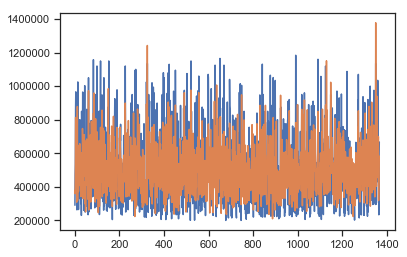

In [22]:
plt.plot([i for i in range( len(TestY) )], TestY)
plt.plot([i for i in range( len(LinRegP) )], LinRegP)
plt.show()

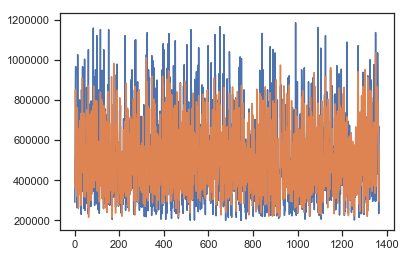

In [23]:
plt.plot([i for i in range( len(TestY) )], TestY)
plt.plot([i for i in range( len(BagRegP) )], BagRegP)
plt.show()

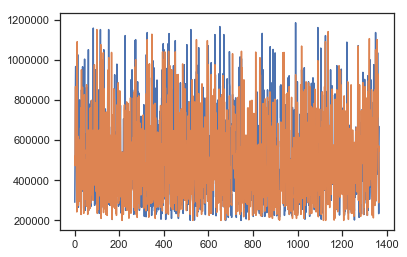

In [24]:
plt.plot([i for i in range( len(TestY) )], TestY)
plt.plot([i for i in range( len(DecTreeP) )], DecTreeP)
plt.show()

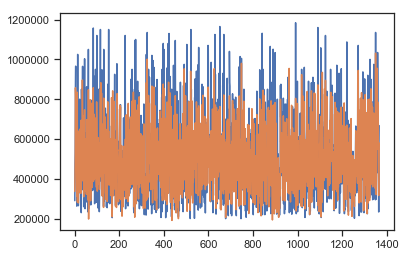

In [25]:
plt.plot([i for i in range( len(TestY) )], TestY)
plt.plot([i for i in range( len(CatModelP) )], CatModelP)
plt.show()

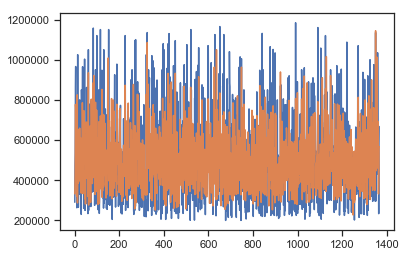

In [26]:
plt.plot([i for i in range( len(TestY) )], TestY)
plt.plot([i for i in range( len(GmdModelP) )], GmdModelP)
plt.show()

<h3>Оценка линейной регрессии</h3>

In [27]:
print("Средняя абсолютная ошибка:\t",mean_absolute_error(TestY, LinRegP))
print("Средняя квадратичная ошибка:\t",mean_squared_error(TestY, LinRegP))
print("Коэффициент детерминации:\t",r2_score(TestY, LinRegP))

Средняя абсолютная ошибка:	 117607.38487102906
Средняя квадратичная ошибка:	 23357082716.14306
Коэффициент детерминации:	 0.5023293241400273


<h3>Оценка бэггинга</h3>

In [28]:
print("Средняя абсолютная ошибка:\t",mean_absolute_error(TestY, BagRegP))
print("Средняя квадратичная ошибка:\t",mean_squared_error(TestY, BagRegP))
print("Коэффициент детерминации:\t",r2_score(TestY, BagRegP))

Средняя абсолютная ошибка:	 96793.08551685077
Средняя квадратичная ошибка:	 17805185232.190174
Коэффициент детерминации:	 0.6206239162653735


<h3>Оценка дерева принятия решений</h3>

In [29]:
print("Средняя абсолютная ошибка:\t",mean_absolute_error(TestY, DecTreeP))
print("Средняя квадратичная ошибка:\t",mean_squared_error(TestY, DecTreeP))
print("Коэффициент детерминации:\t",r2_score(TestY, DecTreeP))

Средняя абсолютная ошибка:	 123449.33750257277
Средняя квадратичная ошибка:	 30593486156.64973
Коэффициент детерминации:	 0.34814286880229184


<h3>Оценка кэтбуста</h3>

In [30]:
print("Средняя абсолютная ошибка:\t",mean_absolute_error(TestY, CatModelP))
print("Средняя квадратичная ошибка:\t",mean_squared_error(TestY, CatModelP))
print("Коэффициент детерминации:\t",r2_score(TestY, CatModelP))

Средняя абсолютная ошибка:	 90231.30733178476
Средняя квадратичная ошибка:	 15403141723.876623
Коэффициент детерминации:	 0.6718043924727577


<h3>Оценка метода группового учета аргументов</h3>

In [31]:
print("Средняя абсолютная ошибка:\t",mean_absolute_error(TestY, GmdModelP))
print("Средняя квадратичная ошибка:\t",mean_squared_error(TestY, GmdModelP))
print("Коэффициент детерминации:\t",r2_score(TestY, GmdModelP))

Средняя абсолютная ошибка:	 118470.27405046372
Средняя квадратичная ошибка:	 23776493715.30035
Коэффициент детерминации:	 0.4933929103784982


<h2>Проведём подбор гиперпараметров</h2>

In [32]:
n_estimators = [1, 10, 100, 1000]
param_grid = dict(n_estimators = n_estimators)
grid = GridSearchCV(BagReg, param_grid=param_grid)
grid_result = grid.fit(TrainX, TrainY)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.5830563912806647
Best Params:  {'n_estimators': 1000}


In [33]:
max_depth = [i+1 for i in range(100)]
min_samples_split = [i+2 for i in range(50)]
param_grid = dict(max_depth = max_depth, min_samples_split=min_samples_split)
grid = GridSearchCV(DecTree, param_grid=param_grid)
grid_result = grid.fit(TrainX, TrainY)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.4674366018806905
Best Params:  {'max_depth': 13, 'min_samples_split': 49}


In [35]:
depth = [6]
l2_leaf_reg = [i+2 for i in range(10)]
bootstrap_type = ['Bayesian','Bernoulli', 'No']
param_distributions = dict(depth = depth, l2_leaf_reg=l2_leaf_reg, bootstrap_type=bootstrap_type)
grid = RandomizedSearchCV(CatModel, param_distributions=param_distributions)
grid_result = grid.fit(TrainX, TrainY)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

0:	learn: 530933.6827353	total: 8.54ms	remaining: 8.54s
1:	learn: 518003.8677037	total: 18.1ms	remaining: 9.01s
2:	learn: 505201.8015229	total: 27.2ms	remaining: 9.05s
3:	learn: 493053.6720012	total: 53.7ms	remaining: 13.4s
4:	learn: 481151.0114676	total: 64.4ms	remaining: 12.8s
5:	learn: 469457.6551763	total: 74ms	remaining: 12.3s
6:	learn: 458079.3559552	total: 90.1ms	remaining: 12.8s
7:	learn: 447143.5495912	total: 95.7ms	remaining: 11.9s
8:	learn: 436732.1932543	total: 102ms	remaining: 11.2s
9:	learn: 426483.1440243	total: 108ms	remaining: 10.7s
10:	learn: 416461.4878499	total: 113ms	remaining: 10.2s
11:	learn: 407375.1966004	total: 119ms	remaining: 9.79s
12:	learn: 397965.7427572	total: 125ms	remaining: 9.51s
13:	learn: 389222.7154679	total: 131ms	remaining: 9.22s
14:	learn: 380638.6669168	total: 137ms	remaining: 9.01s
15:	learn: 372134.8650386	total: 143ms	remaining: 8.79s
16:	learn: 363704.1693226	total: 149ms	remaining: 8.62s
17:	learn: 356098.9593711	total: 155ms	remaining: 8.

150:	learn: 146548.7809143	total: 1.21s	remaining: 6.78s
151:	learn: 146466.1318590	total: 1.21s	remaining: 6.78s
152:	learn: 146346.8061215	total: 1.22s	remaining: 6.77s
153:	learn: 145915.2755826	total: 1.24s	remaining: 6.79s
154:	learn: 145777.5281039	total: 1.25s	remaining: 6.79s
155:	learn: 145752.9848851	total: 1.25s	remaining: 6.76s
156:	learn: 145654.5571931	total: 1.25s	remaining: 6.74s
157:	learn: 145318.8802777	total: 1.26s	remaining: 6.75s
158:	learn: 145172.8384229	total: 1.27s	remaining: 6.73s
159:	learn: 145039.6694120	total: 1.28s	remaining: 6.73s
160:	learn: 144969.6058548	total: 1.29s	remaining: 6.71s
161:	learn: 144864.8026678	total: 1.3s	remaining: 6.71s
162:	learn: 144794.9194166	total: 1.3s	remaining: 6.69s
163:	learn: 144473.2397090	total: 1.31s	remaining: 6.69s
164:	learn: 144378.9742056	total: 1.32s	remaining: 6.67s
165:	learn: 143990.8260069	total: 1.33s	remaining: 6.68s
166:	learn: 143930.5611899	total: 1.33s	remaining: 6.66s
167:	learn: 143852.3497363	total:

300:	learn: 133041.4163859	total: 2.38s	remaining: 5.53s
301:	learn: 133026.2376885	total: 2.39s	remaining: 5.52s
302:	learn: 133019.9732632	total: 2.4s	remaining: 5.52s
303:	learn: 132990.0717733	total: 2.41s	remaining: 5.51s
304:	learn: 132981.7934930	total: 2.43s	remaining: 5.54s
305:	learn: 132959.4954226	total: 2.44s	remaining: 5.54s
306:	learn: 132927.4546150	total: 2.46s	remaining: 5.55s
307:	learn: 132903.7616301	total: 2.46s	remaining: 5.54s
308:	learn: 132847.1591527	total: 2.47s	remaining: 5.53s
309:	learn: 132832.8105998	total: 2.48s	remaining: 5.51s
310:	learn: 132821.8461973	total: 2.48s	remaining: 5.5s
311:	learn: 132651.9459761	total: 2.49s	remaining: 5.49s
312:	learn: 132445.9369866	total: 2.5s	remaining: 5.49s
313:	learn: 132442.3825343	total: 2.5s	remaining: 5.47s
314:	learn: 132430.5612427	total: 2.51s	remaining: 5.46s
315:	learn: 132427.5582215	total: 2.52s	remaining: 5.45s
316:	learn: 132364.8833778	total: 2.53s	remaining: 5.45s
317:	learn: 132288.9416896	total: 2

448:	learn: 125518.1110794	total: 3.57s	remaining: 4.38s
449:	learn: 125489.2243792	total: 3.59s	remaining: 4.38s
450:	learn: 125480.3974832	total: 3.61s	remaining: 4.39s
451:	learn: 125464.0813496	total: 3.62s	remaining: 4.38s
452:	learn: 125446.7796803	total: 3.62s	remaining: 4.38s
453:	learn: 125432.5405235	total: 3.63s	remaining: 4.37s
454:	learn: 125266.0072709	total: 3.64s	remaining: 4.36s
455:	learn: 125216.6513915	total: 3.64s	remaining: 4.35s
456:	learn: 125131.9618538	total: 3.65s	remaining: 4.34s
457:	learn: 125079.2161143	total: 3.65s	remaining: 4.33s
458:	learn: 125060.5725001	total: 3.66s	remaining: 4.31s
459:	learn: 125050.0852780	total: 3.67s	remaining: 4.3s
460:	learn: 124982.1710774	total: 3.67s	remaining: 4.29s
461:	learn: 124974.5630052	total: 3.68s	remaining: 4.28s
462:	learn: 124731.1769807	total: 3.68s	remaining: 4.27s
463:	learn: 124697.4489702	total: 3.69s	remaining: 4.26s
464:	learn: 124683.1352170	total: 3.7s	remaining: 4.25s
465:	learn: 124678.8783151	total:

613:	learn: 118873.2265611	total: 4.95s	remaining: 3.11s
614:	learn: 118863.9756265	total: 4.96s	remaining: 3.1s
615:	learn: 118860.1380914	total: 4.97s	remaining: 3.1s
616:	learn: 118784.0058444	total: 4.98s	remaining: 3.09s
617:	learn: 118753.9622429	total: 5s	remaining: 3.09s
618:	learn: 118745.8151595	total: 5.01s	remaining: 3.08s
619:	learn: 118734.4637858	total: 5.02s	remaining: 3.08s
620:	learn: 118710.2730201	total: 5.03s	remaining: 3.07s
621:	learn: 118682.4049466	total: 5.04s	remaining: 3.06s
622:	learn: 118594.2715784	total: 5.05s	remaining: 3.05s
623:	learn: 118590.7793625	total: 5.05s	remaining: 3.04s
624:	learn: 118578.6829189	total: 5.06s	remaining: 3.04s
625:	learn: 118577.1400835	total: 5.07s	remaining: 3.03s
626:	learn: 118575.1865143	total: 5.07s	remaining: 3.02s
627:	learn: 118559.5093494	total: 5.08s	remaining: 3.01s
628:	learn: 118541.9861994	total: 5.08s	remaining: 3s
629:	learn: 118535.8148649	total: 5.09s	remaining: 2.99s
630:	learn: 118523.0575747	total: 5.09s

770:	learn: 114637.2788098	total: 6.11s	remaining: 1.81s
771:	learn: 114597.8648129	total: 6.12s	remaining: 1.81s
772:	learn: 114593.5650064	total: 6.13s	remaining: 1.8s
773:	learn: 114545.0903413	total: 6.13s	remaining: 1.79s
774:	learn: 114539.9071419	total: 6.14s	remaining: 1.78s
775:	learn: 114346.0473371	total: 6.15s	remaining: 1.77s
776:	learn: 114335.0433030	total: 6.15s	remaining: 1.77s
777:	learn: 114326.3655947	total: 6.16s	remaining: 1.76s
778:	learn: 114323.0247187	total: 6.17s	remaining: 1.75s
779:	learn: 114222.8243245	total: 6.17s	remaining: 1.74s
780:	learn: 114214.5445879	total: 6.18s	remaining: 1.73s
781:	learn: 114041.9985146	total: 6.18s	remaining: 1.72s
782:	learn: 114029.9203298	total: 6.19s	remaining: 1.72s
783:	learn: 114016.9995835	total: 6.19s	remaining: 1.71s
784:	learn: 114012.1433672	total: 6.2s	remaining: 1.7s
785:	learn: 113999.7804386	total: 6.2s	remaining: 1.69s
786:	learn: 113909.6790818	total: 6.21s	remaining: 1.68s
787:	learn: 113901.0242912	total: 6

945:	learn: 110820.1172551	total: 7.27s	remaining: 415ms
946:	learn: 110816.2702512	total: 7.28s	remaining: 408ms
947:	learn: 110809.2027445	total: 7.29s	remaining: 400ms
948:	learn: 110775.9530752	total: 7.3s	remaining: 393ms
949:	learn: 110747.3921527	total: 7.32s	remaining: 385ms
950:	learn: 110742.0990406	total: 7.32s	remaining: 377ms
951:	learn: 110723.5409534	total: 7.33s	remaining: 369ms
952:	learn: 110704.4666267	total: 7.33s	remaining: 362ms
953:	learn: 110686.1689514	total: 7.34s	remaining: 354ms
954:	learn: 110684.4633189	total: 7.35s	remaining: 346ms
955:	learn: 110679.3866929	total: 7.35s	remaining: 338ms
956:	learn: 110678.1827440	total: 7.36s	remaining: 331ms
957:	learn: 110658.8323896	total: 7.37s	remaining: 323ms
958:	learn: 110655.6742883	total: 7.37s	remaining: 315ms
959:	learn: 110494.0557986	total: 7.38s	remaining: 307ms
960:	learn: 110457.2451533	total: 7.39s	remaining: 300ms
961:	learn: 110448.4484959	total: 7.39s	remaining: 292ms
962:	learn: 110405.2703348	total

110:	learn: 146384.1574778	total: 726ms	remaining: 5.82s
111:	learn: 145987.9754531	total: 738ms	remaining: 5.85s
112:	learn: 145743.3519333	total: 754ms	remaining: 5.92s
113:	learn: 145204.3614970	total: 763ms	remaining: 5.93s
114:	learn: 145006.9482320	total: 771ms	remaining: 5.93s
115:	learn: 144763.2998504	total: 777ms	remaining: 5.92s
116:	learn: 144564.1428949	total: 783ms	remaining: 5.91s
117:	learn: 144326.3513218	total: 789ms	remaining: 5.9s
118:	learn: 144102.1346931	total: 795ms	remaining: 5.89s
119:	learn: 143618.6237532	total: 801ms	remaining: 5.87s
120:	learn: 143313.2306546	total: 807ms	remaining: 5.86s
121:	learn: 142789.5532264	total: 815ms	remaining: 5.87s
122:	learn: 142657.0266366	total: 822ms	remaining: 5.86s
123:	learn: 142496.0125869	total: 830ms	remaining: 5.86s
124:	learn: 142322.8975563	total: 836ms	remaining: 5.85s
125:	learn: 142172.6051519	total: 843ms	remaining: 5.85s
126:	learn: 142088.2724570	total: 846ms	remaining: 5.82s
127:	learn: 141938.6434283	total

256:	learn: 127624.9549694	total: 2.16s	remaining: 6.25s
257:	learn: 127564.6997509	total: 2.17s	remaining: 6.25s
258:	learn: 127511.5824332	total: 2.18s	remaining: 6.24s
259:	learn: 127337.2030562	total: 2.19s	remaining: 6.23s
260:	learn: 127322.5502236	total: 2.2s	remaining: 6.22s
261:	learn: 127296.1723702	total: 2.2s	remaining: 6.21s
262:	learn: 127222.9266907	total: 2.21s	remaining: 6.21s
263:	learn: 127063.9603779	total: 2.22s	remaining: 6.19s
264:	learn: 127023.3971875	total: 2.23s	remaining: 6.18s
265:	learn: 126978.9176835	total: 2.24s	remaining: 6.19s
266:	learn: 126970.4331823	total: 2.25s	remaining: 6.18s
267:	learn: 126951.8968114	total: 2.26s	remaining: 6.18s
268:	learn: 126906.1633770	total: 2.28s	remaining: 6.19s
269:	learn: 126643.4998190	total: 2.29s	remaining: 6.19s
270:	learn: 126630.4883911	total: 2.31s	remaining: 6.21s
271:	learn: 126584.5448927	total: 2.33s	remaining: 6.22s
272:	learn: 126572.0656272	total: 2.34s	remaining: 6.23s
273:	learn: 126537.9353346	total:

418:	learn: 118156.2016124	total: 7.25s	remaining: 10.1s
419:	learn: 118136.5550173	total: 7.26s	remaining: 10s
420:	learn: 118132.1246697	total: 7.26s	remaining: 10s
421:	learn: 118123.5292698	total: 7.27s	remaining: 9.98s
422:	learn: 118079.1106160	total: 7.29s	remaining: 9.96s
423:	learn: 118052.0272473	total: 7.29s	remaining: 9.93s
424:	learn: 118046.9341167	total: 7.3s	remaining: 9.9s
425:	learn: 118034.1445603	total: 7.31s	remaining: 9.87s
426:	learn: 118033.2430808	total: 7.31s	remaining: 9.83s
427:	learn: 118014.9739200	total: 7.32s	remaining: 9.81s
428:	learn: 118012.3753288	total: 7.33s	remaining: 9.77s
429:	learn: 117989.2286572	total: 7.33s	remaining: 9.75s
430:	learn: 117981.8503352	total: 7.34s	remaining: 9.71s
431:	learn: 117972.8846013	total: 7.35s	remaining: 9.68s
432:	learn: 117957.9023152	total: 7.36s	remaining: 9.66s
433:	learn: 117928.9065998	total: 7.37s	remaining: 9.63s
434:	learn: 117724.9086112	total: 7.38s	remaining: 9.61s
435:	learn: 117724.1123137	total: 7.3

566:	learn: 113878.5312821	total: 9.11s	remaining: 6.97s
567:	learn: 113870.2790936	total: 9.12s	remaining: 6.95s
568:	learn: 113867.0906868	total: 9.13s	remaining: 6.93s
569:	learn: 113836.4320186	total: 9.14s	remaining: 6.91s
570:	learn: 113832.4380124	total: 9.15s	remaining: 6.89s
571:	learn: 113800.0218218	total: 9.16s	remaining: 6.87s
572:	learn: 113773.4570097	total: 9.17s	remaining: 6.84s
573:	learn: 113760.6208548	total: 9.18s	remaining: 6.82s
574:	learn: 113750.5012167	total: 9.19s	remaining: 6.81s
575:	learn: 113693.7818778	total: 9.21s	remaining: 6.79s
576:	learn: 113687.9890371	total: 9.23s	remaining: 6.78s
577:	learn: 113675.0773274	total: 9.23s	remaining: 6.75s
578:	learn: 113660.6895788	total: 9.24s	remaining: 6.73s
579:	learn: 113656.4296612	total: 9.25s	remaining: 6.71s
580:	learn: 113652.9019711	total: 9.26s	remaining: 6.69s
581:	learn: 113644.4997476	total: 9.27s	remaining: 6.67s
582:	learn: 113604.8662946	total: 9.3s	remaining: 6.66s
583:	learn: 113564.9641604	total

723:	learn: 110166.7532813	total: 10.9s	remaining: 4.15s
724:	learn: 110158.2296790	total: 10.9s	remaining: 4.14s
725:	learn: 110144.6355235	total: 10.9s	remaining: 4.12s
726:	learn: 110137.1333193	total: 10.9s	remaining: 4.1s
727:	learn: 110133.3836685	total: 10.9s	remaining: 4.08s
728:	learn: 109970.0795913	total: 10.9s	remaining: 4.07s
729:	learn: 109900.1280926	total: 10.9s	remaining: 4.05s
730:	learn: 109889.5408657	total: 10.9s	remaining: 4.03s
731:	learn: 109888.7878470	total: 10.9s	remaining: 4.01s
732:	learn: 109880.3804422	total: 11s	remaining: 4s
733:	learn: 109831.2731404	total: 11s	remaining: 3.98s
734:	learn: 109788.8106925	total: 11s	remaining: 3.96s
735:	learn: 109788.4873751	total: 11s	remaining: 3.94s
736:	learn: 109786.9017491	total: 11s	remaining: 3.93s
737:	learn: 109782.1105328	total: 11s	remaining: 3.91s
738:	learn: 109756.3500466	total: 11s	remaining: 3.89s
739:	learn: 109748.5456104	total: 11s	remaining: 3.88s
740:	learn: 109724.3645946	total: 11s	remaining: 3.

868:	learn: 106905.3436915	total: 18.7s	remaining: 2.82s
869:	learn: 106862.8951559	total: 18.8s	remaining: 2.82s
870:	learn: 106859.7275038	total: 18.9s	remaining: 2.8s
871:	learn: 106728.6075737	total: 18.9s	remaining: 2.78s
872:	learn: 106725.2203309	total: 19s	remaining: 2.76s
873:	learn: 106715.2834212	total: 19s	remaining: 2.74s
874:	learn: 106710.6696859	total: 19s	remaining: 2.72s
875:	learn: 106685.3298169	total: 19.1s	remaining: 2.71s
876:	learn: 106681.0324864	total: 19.3s	remaining: 2.71s
877:	learn: 106677.0132188	total: 19.3s	remaining: 2.69s
878:	learn: 106676.8285533	total: 19.4s	remaining: 2.67s
879:	learn: 106657.8356979	total: 19.4s	remaining: 2.65s
880:	learn: 106652.5094586	total: 19.4s	remaining: 2.63s
881:	learn: 106645.9360267	total: 19.5s	remaining: 2.61s
882:	learn: 106643.7335277	total: 19.9s	remaining: 2.64s
883:	learn: 106596.5399559	total: 20s	remaining: 2.63s
884:	learn: 106489.6049987	total: 20.1s	remaining: 2.61s
885:	learn: 106487.7909695	total: 20.1s	

36:	learn: 245506.5764453	total: 270ms	remaining: 7.03s
37:	learn: 241817.5944213	total: 277ms	remaining: 7.01s
38:	learn: 238148.3291991	total: 283ms	remaining: 6.98s
39:	learn: 234561.6468802	total: 287ms	remaining: 6.89s
40:	learn: 231053.2662550	total: 294ms	remaining: 6.88s
41:	learn: 227636.6655734	total: 302ms	remaining: 6.88s
42:	learn: 224426.6150091	total: 308ms	remaining: 6.86s
43:	learn: 221241.4122286	total: 325ms	remaining: 7.07s
44:	learn: 218289.2061154	total: 340ms	remaining: 7.21s
45:	learn: 215454.6330462	total: 356ms	remaining: 7.38s
46:	learn: 212590.4664705	total: 371ms	remaining: 7.52s
47:	learn: 209823.7384587	total: 386ms	remaining: 7.65s
48:	learn: 207351.1941344	total: 390ms	remaining: 7.58s
49:	learn: 205044.8685017	total: 406ms	remaining: 7.71s
50:	learn: 202583.6466267	total: 427ms	remaining: 7.94s
51:	learn: 200401.7476093	total: 440ms	remaining: 8.02s
52:	learn: 198174.5277888	total: 462ms	remaining: 8.25s
53:	learn: 196076.9198480	total: 474ms	remaining

207:	learn: 132386.4392283	total: 2.08s	remaining: 7.9s
208:	learn: 132342.3790019	total: 2.08s	remaining: 7.89s
209:	learn: 132297.6775684	total: 2.09s	remaining: 7.86s
210:	learn: 132274.7618475	total: 2.09s	remaining: 7.82s
211:	learn: 132245.5200588	total: 2.1s	remaining: 7.81s
212:	learn: 132150.5439425	total: 2.11s	remaining: 7.79s
213:	learn: 132096.3502986	total: 2.12s	remaining: 7.77s
214:	learn: 132061.4599347	total: 2.12s	remaining: 7.75s
215:	learn: 131996.8911202	total: 2.13s	remaining: 7.74s
216:	learn: 131952.7590861	total: 2.14s	remaining: 7.72s
217:	learn: 131880.0030058	total: 2.15s	remaining: 7.71s
218:	learn: 131855.2049564	total: 2.15s	remaining: 7.69s
219:	learn: 131734.1063032	total: 2.16s	remaining: 7.67s
220:	learn: 131676.0918707	total: 2.17s	remaining: 7.65s
221:	learn: 131662.3995772	total: 2.17s	remaining: 7.62s
222:	learn: 131617.3633684	total: 2.18s	remaining: 7.6s
223:	learn: 131419.3118585	total: 2.19s	remaining: 7.58s
224:	learn: 131323.3820661	total: 

354:	learn: 123751.5461259	total: 3.96s	remaining: 7.19s
355:	learn: 123745.5223293	total: 3.96s	remaining: 7.17s
356:	learn: 123735.2250927	total: 3.97s	remaining: 7.15s
357:	learn: 123727.8099368	total: 3.98s	remaining: 7.13s
358:	learn: 123614.6938002	total: 3.99s	remaining: 7.12s
359:	learn: 123565.0622070	total: 3.99s	remaining: 7.1s
360:	learn: 123351.5169910	total: 4s	remaining: 7.08s
361:	learn: 123344.9908583	total: 4.01s	remaining: 7.07s
362:	learn: 123335.5172407	total: 4.02s	remaining: 7.05s
363:	learn: 123317.8407363	total: 4.02s	remaining: 7.03s
364:	learn: 123300.3457626	total: 4.03s	remaining: 7.02s
365:	learn: 123259.6521049	total: 4.04s	remaining: 7s
366:	learn: 123192.4975845	total: 4.05s	remaining: 6.99s
367:	learn: 123187.3513790	total: 4.06s	remaining: 6.96s
368:	learn: 123125.6283833	total: 4.08s	remaining: 6.97s
369:	learn: 123124.9499766	total: 4.09s	remaining: 6.96s
370:	learn: 123080.2570177	total: 4.1s	remaining: 6.96s
371:	learn: 123066.0853451	total: 4.12s

510:	learn: 118068.0218821	total: 5.81s	remaining: 5.56s
511:	learn: 118064.4071998	total: 5.82s	remaining: 5.54s
512:	learn: 118054.3458968	total: 5.83s	remaining: 5.53s
513:	learn: 117838.2386697	total: 5.83s	remaining: 5.51s
514:	learn: 117824.6263264	total: 5.84s	remaining: 5.5s
515:	learn: 117727.4935686	total: 5.86s	remaining: 5.5s
516:	learn: 117716.3136836	total: 5.87s	remaining: 5.48s
517:	learn: 117670.4785873	total: 5.88s	remaining: 5.47s
518:	learn: 117667.1099553	total: 5.89s	remaining: 5.46s
519:	learn: 117661.1279637	total: 5.91s	remaining: 5.46s
520:	learn: 117654.9649445	total: 5.93s	remaining: 5.45s
521:	learn: 117642.6558486	total: 5.95s	remaining: 5.45s
522:	learn: 117636.5786710	total: 5.96s	remaining: 5.44s
523:	learn: 117613.1385084	total: 5.99s	remaining: 5.44s
524:	learn: 117603.5130321	total: 6s	remaining: 5.43s
525:	learn: 117402.1538186	total: 6.02s	remaining: 5.42s
526:	learn: 117390.1120969	total: 6.03s	remaining: 5.41s
527:	learn: 117361.5157694	total: 6.

664:	learn: 113362.6516242	total: 7.37s	remaining: 3.71s
665:	learn: 113360.8764380	total: 7.38s	remaining: 3.7s
666:	learn: 113358.5618450	total: 7.4s	remaining: 3.69s
667:	learn: 113357.2342325	total: 7.42s	remaining: 3.69s
668:	learn: 113355.0085990	total: 7.43s	remaining: 3.68s
669:	learn: 113292.6725795	total: 7.45s	remaining: 3.67s
670:	learn: 113287.7279336	total: 7.46s	remaining: 3.66s
671:	learn: 113286.9737654	total: 7.48s	remaining: 3.65s
672:	learn: 113281.7025473	total: 7.5s	remaining: 3.64s
673:	learn: 113281.2323721	total: 7.51s	remaining: 3.63s
674:	learn: 113270.5396557	total: 7.51s	remaining: 3.62s
675:	learn: 113237.6568076	total: 7.53s	remaining: 3.61s
676:	learn: 113236.8291286	total: 7.55s	remaining: 3.6s
677:	learn: 113236.1923541	total: 7.56s	remaining: 3.59s
678:	learn: 113234.7444661	total: 7.59s	remaining: 3.59s
679:	learn: 113234.7433665	total: 7.59s	remaining: 3.57s
680:	learn: 113233.1064708	total: 7.61s	remaining: 3.56s
681:	learn: 113138.1960026	total: 7

826:	learn: 111373.1554134	total: 8.91s	remaining: 1.86s
827:	learn: 111322.5227149	total: 8.91s	remaining: 1.85s
828:	learn: 111322.3257234	total: 8.92s	remaining: 1.84s
829:	learn: 111307.7506816	total: 8.93s	remaining: 1.83s
830:	learn: 111305.9762986	total: 8.93s	remaining: 1.82s
831:	learn: 111293.3801416	total: 8.94s	remaining: 1.8s
832:	learn: 111292.8814023	total: 8.95s	remaining: 1.79s
833:	learn: 111273.5196997	total: 8.96s	remaining: 1.78s
834:	learn: 111269.8941601	total: 8.96s	remaining: 1.77s
835:	learn: 111249.7559545	total: 8.97s	remaining: 1.76s
836:	learn: 111222.5754160	total: 8.97s	remaining: 1.75s
837:	learn: 111169.9111889	total: 8.98s	remaining: 1.74s
838:	learn: 111156.2591499	total: 8.99s	remaining: 1.73s
839:	learn: 111156.0824831	total: 8.99s	remaining: 1.71s
840:	learn: 111155.7057562	total: 9s	remaining: 1.7s
841:	learn: 111139.8421897	total: 9.01s	remaining: 1.69s
842:	learn: 111138.3483978	total: 9.02s	remaining: 1.68s
843:	learn: 111134.8015551	total: 9.

988:	learn: 109134.9328028	total: 11.8s	remaining: 131ms
989:	learn: 109132.8044143	total: 11.8s	remaining: 119ms
990:	learn: 109132.7950123	total: 11.8s	remaining: 107ms
991:	learn: 109131.3149275	total: 11.8s	remaining: 95.1ms
992:	learn: 109131.0688985	total: 11.8s	remaining: 83.2ms
993:	learn: 109130.9922601	total: 11.8s	remaining: 71.3ms
994:	learn: 109121.6741590	total: 11.8s	remaining: 59.4ms
995:	learn: 109117.8881689	total: 11.8s	remaining: 47.5ms
996:	learn: 109110.1800658	total: 11.8s	remaining: 35.6ms
997:	learn: 109110.1468172	total: 11.8s	remaining: 23.8ms
998:	learn: 109107.9003938	total: 11.8s	remaining: 11.9ms
999:	learn: 109107.7585203	total: 12s	remaining: 0us
0:	learn: 530452.6281430	total: 24.8ms	remaining: 24.7s
1:	learn: 517115.1744401	total: 62.4ms	remaining: 31.1s
2:	learn: 503778.1158921	total: 125ms	remaining: 41.7s
3:	learn: 490916.0080022	total: 320ms	remaining: 1m 19s
4:	learn: 478363.1947081	total: 394ms	remaining: 1m 18s
5:	learn: 466423.1683602	total: 9

138:	learn: 141983.3374533	total: 21.8s	remaining: 2m 14s
139:	learn: 141842.0754918	total: 21.8s	remaining: 2m 13s
140:	learn: 141536.1828516	total: 21.8s	remaining: 2m 12s
141:	learn: 141115.3985077	total: 21.8s	remaining: 2m 11s
142:	learn: 140961.4586902	total: 21.8s	remaining: 2m 10s
143:	learn: 140695.7785373	total: 21.8s	remaining: 2m 9s
144:	learn: 140329.8318818	total: 21.9s	remaining: 2m 8s
145:	learn: 139976.0595642	total: 21.9s	remaining: 2m 8s
146:	learn: 139803.9378204	total: 21.9s	remaining: 2m 7s
147:	learn: 139611.0988035	total: 21.9s	remaining: 2m 6s
148:	learn: 139336.0166909	total: 22s	remaining: 2m 5s
149:	learn: 139255.3413352	total: 22.1s	remaining: 2m 5s
150:	learn: 139175.8424499	total: 22.1s	remaining: 2m 4s
151:	learn: 139084.6205490	total: 22.1s	remaining: 2m 3s
152:	learn: 138939.6851118	total: 22.2s	remaining: 2m 2s
153:	learn: 138882.8171233	total: 22.3s	remaining: 2m 2s
154:	learn: 138783.0716099	total: 22.3s	remaining: 2m 1s
155:	learn: 138695.1056124	t

288:	learn: 128452.3204090	total: 31.2s	remaining: 1m 16s
289:	learn: 128418.4886777	total: 31.2s	remaining: 1m 16s
290:	learn: 128385.4467924	total: 31.3s	remaining: 1m 16s
291:	learn: 128361.0043163	total: 31.3s	remaining: 1m 15s
292:	learn: 128114.6491345	total: 31.3s	remaining: 1m 15s
293:	learn: 127930.1529692	total: 31.4s	remaining: 1m 15s
294:	learn: 127580.1987727	total: 31.4s	remaining: 1m 15s
295:	learn: 127426.0181915	total: 31.4s	remaining: 1m 14s
296:	learn: 127384.5259017	total: 31.5s	remaining: 1m 14s
297:	learn: 127384.1955954	total: 31.5s	remaining: 1m 14s
298:	learn: 127285.7902730	total: 31.6s	remaining: 1m 14s
299:	learn: 127275.9883990	total: 31.6s	remaining: 1m 13s
300:	learn: 126949.1245054	total: 31.6s	remaining: 1m 13s
301:	learn: 126943.8401100	total: 31.6s	remaining: 1m 13s
302:	learn: 126927.5094013	total: 31.7s	remaining: 1m 12s
303:	learn: 126788.2973563	total: 31.7s	remaining: 1m 12s
304:	learn: 126591.5645356	total: 31.7s	remaining: 1m 12s
305:	learn: 12

439:	learn: 118194.2439839	total: 37.7s	remaining: 47.9s
440:	learn: 118075.6031992	total: 37.7s	remaining: 47.8s
441:	learn: 117933.7359910	total: 37.7s	remaining: 47.6s
442:	learn: 117902.6926800	total: 37.7s	remaining: 47.4s
443:	learn: 117900.7456420	total: 37.7s	remaining: 47.2s
444:	learn: 117886.7574691	total: 37.7s	remaining: 47.1s
445:	learn: 117884.2667746	total: 37.7s	remaining: 46.9s
446:	learn: 117881.2658683	total: 37.8s	remaining: 46.7s
447:	learn: 117785.5677555	total: 37.8s	remaining: 46.5s
448:	learn: 117765.8022698	total: 37.8s	remaining: 46.4s
449:	learn: 117757.8730434	total: 37.8s	remaining: 46.2s
450:	learn: 117746.3620606	total: 37.8s	remaining: 46s
451:	learn: 117546.7864649	total: 37.8s	remaining: 45.9s
452:	learn: 117535.6035062	total: 37.8s	remaining: 45.7s
453:	learn: 117520.8288919	total: 37.9s	remaining: 45.5s
454:	learn: 117480.4333402	total: 37.9s	remaining: 45.4s
455:	learn: 117473.7935084	total: 37.9s	remaining: 45.2s
456:	learn: 117459.4658799	total:

593:	learn: 112137.6269635	total: 42s	remaining: 28.7s
594:	learn: 112131.3648786	total: 42s	remaining: 28.6s
595:	learn: 112106.9021652	total: 42s	remaining: 28.5s
596:	learn: 112100.0961954	total: 42s	remaining: 28.4s
597:	learn: 112092.3683957	total: 42s	remaining: 28.3s
598:	learn: 112088.0583163	total: 42.1s	remaining: 28.2s
599:	learn: 112065.0468995	total: 42.1s	remaining: 28s
600:	learn: 112061.9408868	total: 42.1s	remaining: 27.9s
601:	learn: 112056.4570612	total: 42.1s	remaining: 27.8s
602:	learn: 112047.6448663	total: 42.1s	remaining: 27.7s
603:	learn: 112039.8074638	total: 42.1s	remaining: 27.6s
604:	learn: 112039.7129480	total: 42.1s	remaining: 27.5s
605:	learn: 112020.8981783	total: 42.1s	remaining: 27.4s
606:	learn: 112017.5254338	total: 42.1s	remaining: 27.3s
607:	learn: 111975.9067990	total: 42.1s	remaining: 27.2s
608:	learn: 111975.7561830	total: 42.2s	remaining: 27.1s
609:	learn: 111966.8415584	total: 42.2s	remaining: 27s
610:	learn: 111966.5104921	total: 42.2s	remai

770:	learn: 108339.4759799	total: 43.1s	remaining: 12.8s
771:	learn: 108265.8672737	total: 43.1s	remaining: 12.7s
772:	learn: 108211.5428235	total: 43.1s	remaining: 12.7s
773:	learn: 108179.9667204	total: 43.2s	remaining: 12.6s
774:	learn: 108030.6874791	total: 43.2s	remaining: 12.5s
775:	learn: 107987.2150256	total: 43.2s	remaining: 12.5s
776:	learn: 107982.0819000	total: 43.2s	remaining: 12.4s
777:	learn: 107980.3702071	total: 43.2s	remaining: 12.3s
778:	learn: 107939.8535430	total: 43.2s	remaining: 12.3s
779:	learn: 107903.9766764	total: 43.2s	remaining: 12.2s
780:	learn: 107867.5477983	total: 43.2s	remaining: 12.1s
781:	learn: 107818.6508875	total: 43.2s	remaining: 12s
782:	learn: 107818.4022347	total: 43.2s	remaining: 12s
783:	learn: 107818.3976219	total: 43.2s	remaining: 11.9s
784:	learn: 107817.9835770	total: 43.2s	remaining: 11.8s
785:	learn: 107813.4632914	total: 43.2s	remaining: 11.8s
786:	learn: 107809.8878434	total: 43.2s	remaining: 11.7s
787:	learn: 107734.1783225	total: 4

940:	learn: 104598.7957904	total: 44.1s	remaining: 2.76s
941:	learn: 104596.4098660	total: 44.1s	remaining: 2.71s
942:	learn: 104596.2503145	total: 44.1s	remaining: 2.67s
943:	learn: 104583.6650772	total: 44.1s	remaining: 2.62s
944:	learn: 104578.9424953	total: 44.1s	remaining: 2.57s
945:	learn: 104570.8792329	total: 44.1s	remaining: 2.52s
946:	learn: 104570.8756854	total: 44.1s	remaining: 2.47s
947:	learn: 104570.2676511	total: 44.1s	remaining: 2.42s
948:	learn: 104548.5100000	total: 44.1s	remaining: 2.37s
949:	learn: 104547.1230307	total: 44.1s	remaining: 2.32s
950:	learn: 104546.8030470	total: 44.1s	remaining: 2.27s
951:	learn: 104493.6489199	total: 44.1s	remaining: 2.23s
952:	learn: 104493.6064333	total: 44.1s	remaining: 2.18s
953:	learn: 104488.9241545	total: 44.2s	remaining: 2.13s
954:	learn: 104488.6186130	total: 44.2s	remaining: 2.08s
955:	learn: 104485.0521437	total: 44.2s	remaining: 2.03s
956:	learn: 104484.9628190	total: 44.2s	remaining: 1.98s
957:	learn: 104483.1061375	tota

113:	learn: 138875.5060945	total: 1.26s	remaining: 9.79s
114:	learn: 138450.7992386	total: 1.26s	remaining: 9.74s
115:	learn: 138053.4697527	total: 1.27s	remaining: 9.69s
116:	learn: 137540.6778370	total: 1.28s	remaining: 9.64s
117:	learn: 137235.2079050	total: 1.28s	remaining: 9.61s
118:	learn: 137015.8917754	total: 1.29s	remaining: 9.56s
119:	learn: 136798.2955389	total: 1.3s	remaining: 9.51s
120:	learn: 136693.4448353	total: 1.3s	remaining: 9.47s
121:	learn: 136442.5066581	total: 1.31s	remaining: 9.45s
122:	learn: 136381.0005010	total: 1.32s	remaining: 9.4s
123:	learn: 136199.3543316	total: 1.32s	remaining: 9.36s
124:	learn: 135809.5798167	total: 1.33s	remaining: 9.32s
125:	learn: 135632.0145628	total: 1.34s	remaining: 9.27s
126:	learn: 135508.4763114	total: 1.34s	remaining: 9.22s
127:	learn: 135391.8009023	total: 1.35s	remaining: 9.19s
128:	learn: 135159.2841985	total: 1.35s	remaining: 9.15s
129:	learn: 134695.7762925	total: 1.36s	remaining: 9.11s
130:	learn: 134533.1824570	total: 

265:	learn: 121141.7094802	total: 2.23s	remaining: 6.16s
266:	learn: 121128.9276060	total: 2.24s	remaining: 6.15s
267:	learn: 121086.9934564	total: 2.24s	remaining: 6.13s
268:	learn: 121068.4882774	total: 2.25s	remaining: 6.11s
269:	learn: 121066.6969977	total: 2.25s	remaining: 6.09s
270:	learn: 121017.3104948	total: 2.26s	remaining: 6.08s
271:	learn: 120659.0527609	total: 2.27s	remaining: 6.06s
272:	learn: 120508.4005317	total: 2.27s	remaining: 6.05s
273:	learn: 120508.3594900	total: 2.27s	remaining: 6.03s
274:	learn: 120442.3880898	total: 2.28s	remaining: 6.01s
275:	learn: 120301.9377610	total: 2.29s	remaining: 6s
276:	learn: 120299.9419631	total: 2.29s	remaining: 5.97s
277:	learn: 120014.6637547	total: 2.29s	remaining: 5.96s
278:	learn: 120012.0656940	total: 2.3s	remaining: 5.94s
279:	learn: 120010.5808993	total: 2.3s	remaining: 5.93s
280:	learn: 119726.9640075	total: 2.31s	remaining: 5.91s
281:	learn: 119675.2571637	total: 2.33s	remaining: 5.94s
282:	learn: 119671.6161470	total: 2.

415:	learn: 113738.0839810	total: 3.19s	remaining: 4.47s
416:	learn: 113484.2546780	total: 3.19s	remaining: 4.46s
417:	learn: 113481.1062600	total: 3.2s	remaining: 4.46s
418:	learn: 113437.4688009	total: 3.21s	remaining: 4.45s
419:	learn: 113428.6218619	total: 3.21s	remaining: 4.44s
420:	learn: 113428.5913133	total: 3.21s	remaining: 4.42s
421:	learn: 113359.9876014	total: 3.22s	remaining: 4.41s
422:	learn: 113337.1095670	total: 3.23s	remaining: 4.4s
423:	learn: 113332.1536316	total: 3.23s	remaining: 4.39s
424:	learn: 113312.8079843	total: 3.24s	remaining: 4.38s
425:	learn: 113282.2787178	total: 3.24s	remaining: 4.37s
426:	learn: 113270.4918837	total: 3.25s	remaining: 4.36s
427:	learn: 113087.3294313	total: 3.26s	remaining: 4.35s
428:	learn: 113046.4995798	total: 3.26s	remaining: 4.34s
429:	learn: 113044.4620107	total: 3.27s	remaining: 4.33s
430:	learn: 113044.4551195	total: 3.27s	remaining: 4.32s
431:	learn: 113006.2717713	total: 3.29s	remaining: 4.32s
432:	learn: 112980.8376653	total:

580:	learn: 109228.0582581	total: 4.16s	remaining: 3s
581:	learn: 109226.9521071	total: 4.16s	remaining: 2.99s
582:	learn: 109212.4844919	total: 4.17s	remaining: 2.98s
583:	learn: 109208.0865391	total: 4.17s	remaining: 2.97s
584:	learn: 109208.0620794	total: 4.18s	remaining: 2.96s
585:	learn: 109206.9520890	total: 4.18s	remaining: 2.95s
586:	learn: 109191.5709218	total: 4.19s	remaining: 2.95s
587:	learn: 109190.9378240	total: 4.2s	remaining: 2.94s
588:	learn: 109126.5737650	total: 4.21s	remaining: 2.94s
589:	learn: 109122.8492390	total: 4.21s	remaining: 2.93s
590:	learn: 109118.3404562	total: 4.22s	remaining: 2.92s
591:	learn: 109103.9413936	total: 4.23s	remaining: 2.91s
592:	learn: 109069.2886288	total: 4.23s	remaining: 2.9s
593:	learn: 109067.5505649	total: 4.24s	remaining: 2.9s
594:	learn: 108854.8218492	total: 4.24s	remaining: 2.89s
595:	learn: 108854.7943036	total: 4.25s	remaining: 2.88s
596:	learn: 108853.7466099	total: 4.25s	remaining: 2.87s
597:	learn: 108852.6795949	total: 4.2

741:	learn: 105148.4452499	total: 5.12s	remaining: 1.78s
742:	learn: 105135.4060236	total: 5.13s	remaining: 1.77s
743:	learn: 105135.3936186	total: 5.13s	remaining: 1.76s
744:	learn: 105091.0507371	total: 5.13s	remaining: 1.76s
745:	learn: 105087.2064245	total: 5.14s	remaining: 1.75s
746:	learn: 105066.4333650	total: 5.15s	remaining: 1.74s
747:	learn: 105064.5928411	total: 5.15s	remaining: 1.74s
748:	learn: 105064.5791041	total: 5.16s	remaining: 1.73s
749:	learn: 105064.1278707	total: 5.16s	remaining: 1.72s
750:	learn: 105055.5737066	total: 5.17s	remaining: 1.71s
751:	learn: 105050.6930832	total: 5.17s	remaining: 1.71s
752:	learn: 105044.9914296	total: 5.18s	remaining: 1.7s
753:	learn: 105043.5739891	total: 5.18s	remaining: 1.69s
754:	learn: 105002.8712077	total: 5.19s	remaining: 1.68s
755:	learn: 104978.4526539	total: 5.2s	remaining: 1.68s
756:	learn: 104970.1404895	total: 5.2s	remaining: 1.67s
757:	learn: 104922.9107026	total: 5.21s	remaining: 1.66s
758:	learn: 104893.3073138	total: 

886:	learn: 102019.3157735	total: 7.08s	remaining: 902ms
887:	learn: 102018.1643980	total: 7.09s	remaining: 895ms
888:	learn: 102015.7911425	total: 7.1s	remaining: 887ms
889:	learn: 102013.5477959	total: 7.11s	remaining: 879ms
890:	learn: 101905.7431317	total: 7.12s	remaining: 871ms
891:	learn: 101860.6435011	total: 7.13s	remaining: 863ms
892:	learn: 101842.2825554	total: 7.14s	remaining: 856ms
893:	learn: 101842.2590739	total: 7.15s	remaining: 848ms
894:	learn: 101835.9428945	total: 7.16s	remaining: 840ms
895:	learn: 101831.3720238	total: 7.17s	remaining: 833ms
896:	learn: 101827.8968185	total: 7.19s	remaining: 826ms
897:	learn: 101741.5194913	total: 7.2s	remaining: 818ms
898:	learn: 101730.8791527	total: 7.21s	remaining: 810ms
899:	learn: 101672.2294170	total: 7.22s	remaining: 802ms
900:	learn: 101609.6741022	total: 7.22s	remaining: 794ms
901:	learn: 101609.6298375	total: 7.23s	remaining: 785ms
902:	learn: 101596.8445320	total: 7.24s	remaining: 778ms
903:	learn: 101596.0458858	total:

52:	learn: 191940.5259172	total: 396ms	remaining: 7.08s
53:	learn: 189908.3902383	total: 403ms	remaining: 7.07s
54:	learn: 187772.6426362	total: 411ms	remaining: 7.07s
55:	learn: 185796.2146046	total: 417ms	remaining: 7.04s
56:	learn: 183948.7305636	total: 425ms	remaining: 7.04s
57:	learn: 182140.6225604	total: 432ms	remaining: 7.01s
58:	learn: 180482.4291781	total: 439ms	remaining: 7s
59:	learn: 179102.2085499	total: 445ms	remaining: 6.97s
60:	learn: 177706.4482618	total: 451ms	remaining: 6.95s
61:	learn: 176081.3928522	total: 459ms	remaining: 6.94s
62:	learn: 174745.8512453	total: 465ms	remaining: 6.91s
63:	learn: 173271.8939993	total: 472ms	remaining: 6.9s
64:	learn: 171974.5206569	total: 477ms	remaining: 6.87s
65:	learn: 170564.1383340	total: 483ms	remaining: 6.84s
66:	learn: 169270.9189545	total: 490ms	remaining: 6.82s
67:	learn: 168197.6742279	total: 495ms	remaining: 6.78s
68:	learn: 167180.5379418	total: 502ms	remaining: 6.78s
69:	learn: 166250.3594531	total: 510ms	remaining: 6.

207:	learn: 128531.3383208	total: 1.55s	remaining: 5.92s
208:	learn: 128482.7308880	total: 1.56s	remaining: 5.92s
209:	learn: 128310.1772039	total: 1.57s	remaining: 5.91s
210:	learn: 128302.8793591	total: 1.58s	remaining: 5.89s
211:	learn: 128278.4767723	total: 1.58s	remaining: 5.88s
212:	learn: 128267.3943915	total: 1.59s	remaining: 5.87s
213:	learn: 128240.9720603	total: 1.59s	remaining: 5.85s
214:	learn: 128208.9897884	total: 1.6s	remaining: 5.84s
215:	learn: 128175.7168273	total: 1.6s	remaining: 5.82s
216:	learn: 128119.4065637	total: 1.61s	remaining: 5.82s
217:	learn: 127947.4308278	total: 1.62s	remaining: 5.81s
218:	learn: 127903.9092981	total: 1.63s	remaining: 5.8s
219:	learn: 127704.9655973	total: 1.63s	remaining: 5.79s
220:	learn: 127535.7972749	total: 1.64s	remaining: 5.78s
221:	learn: 127469.2977063	total: 1.64s	remaining: 5.76s
222:	learn: 127451.4002456	total: 1.65s	remaining: 5.75s
223:	learn: 127386.3481600	total: 1.66s	remaining: 5.75s
224:	learn: 127103.7516300	total: 

377:	learn: 119553.6545104	total: 2.74s	remaining: 4.5s
378:	learn: 119553.6442045	total: 2.74s	remaining: 4.49s
379:	learn: 119527.4216057	total: 2.75s	remaining: 4.48s
380:	learn: 119420.1668080	total: 2.76s	remaining: 4.48s
381:	learn: 119410.1343264	total: 2.77s	remaining: 4.47s
382:	learn: 119397.2185288	total: 2.77s	remaining: 4.47s
383:	learn: 119393.8145647	total: 2.78s	remaining: 4.46s
384:	learn: 119353.0715968	total: 2.79s	remaining: 4.45s
385:	learn: 119324.9022172	total: 2.79s	remaining: 4.44s
386:	learn: 119275.4235064	total: 2.8s	remaining: 4.44s
387:	learn: 119275.3961542	total: 2.81s	remaining: 4.43s
388:	learn: 119244.0781242	total: 2.82s	remaining: 4.43s
389:	learn: 119244.0700914	total: 2.82s	remaining: 4.41s
390:	learn: 119243.6910521	total: 2.82s	remaining: 4.4s
391:	learn: 119243.6833627	total: 2.83s	remaining: 4.38s
392:	learn: 119243.1775692	total: 2.83s	remaining: 4.37s
393:	learn: 119235.1161298	total: 2.83s	remaining: 4.36s
394:	learn: 119216.3382668	total: 

550:	learn: 113687.7687399	total: 3.7s	remaining: 3.01s
551:	learn: 113684.6270580	total: 3.7s	remaining: 3.01s
552:	learn: 113667.9717736	total: 3.71s	remaining: 3s
553:	learn: 113655.4540366	total: 3.71s	remaining: 2.99s
554:	learn: 113646.6776782	total: 3.72s	remaining: 2.98s
555:	learn: 113645.6685948	total: 3.73s	remaining: 2.98s
556:	learn: 113627.1345299	total: 3.73s	remaining: 2.97s
557:	learn: 113602.2733774	total: 3.74s	remaining: 2.96s
558:	learn: 113601.9101737	total: 3.74s	remaining: 2.95s
559:	learn: 113600.4846166	total: 3.75s	remaining: 2.94s
560:	learn: 113595.0210431	total: 3.75s	remaining: 2.94s
561:	learn: 113542.3291564	total: 3.76s	remaining: 2.93s
562:	learn: 113541.8731685	total: 3.76s	remaining: 2.92s
563:	learn: 113539.7342268	total: 3.77s	remaining: 2.91s
564:	learn: 113518.2466752	total: 3.77s	remaining: 2.91s
565:	learn: 113456.2008705	total: 3.78s	remaining: 2.9s
566:	learn: 113454.4714608	total: 3.78s	remaining: 2.89s
567:	learn: 113398.8797822	total: 3.7

698:	learn: 110586.4940830	total: 4.45s	remaining: 1.91s
699:	learn: 110557.4837395	total: 4.45s	remaining: 1.91s
700:	learn: 110536.9811096	total: 4.46s	remaining: 1.9s
701:	learn: 110535.3028856	total: 4.46s	remaining: 1.89s
702:	learn: 110535.2921121	total: 4.46s	remaining: 1.89s
703:	learn: 110529.4935130	total: 4.47s	remaining: 1.88s
704:	learn: 110507.4100413	total: 4.48s	remaining: 1.87s
705:	learn: 110507.3990928	total: 4.48s	remaining: 1.86s
706:	learn: 110504.5109357	total: 4.48s	remaining: 1.86s
707:	learn: 110498.1945206	total: 4.49s	remaining: 1.85s
708:	learn: 110467.5101428	total: 4.5s	remaining: 1.84s
709:	learn: 110451.4901755	total: 4.5s	remaining: 1.84s
710:	learn: 110437.5618365	total: 4.51s	remaining: 1.83s
711:	learn: 110428.9269652	total: 4.51s	remaining: 1.82s
712:	learn: 110421.0192269	total: 4.52s	remaining: 1.82s
713:	learn: 110221.5617632	total: 4.52s	remaining: 1.81s
714:	learn: 110220.9127114	total: 4.53s	remaining: 1.8s
715:	learn: 110218.2636347	total: 4

875:	learn: 107158.7963687	total: 5.4s	remaining: 764ms
876:	learn: 107158.7943304	total: 5.4s	remaining: 758ms
877:	learn: 107158.7472512	total: 5.41s	remaining: 751ms
878:	learn: 107148.2757490	total: 5.41s	remaining: 745ms
879:	learn: 107026.1469319	total: 5.42s	remaining: 739ms
880:	learn: 107026.0994767	total: 5.42s	remaining: 733ms
881:	learn: 107010.8922689	total: 5.43s	remaining: 727ms
882:	learn: 107010.8455332	total: 5.44s	remaining: 720ms
883:	learn: 107010.8007570	total: 5.44s	remaining: 714ms
884:	learn: 107010.7140584	total: 5.44s	remaining: 707ms
885:	learn: 107010.6712171	total: 5.45s	remaining: 701ms
886:	learn: 107010.6191938	total: 5.45s	remaining: 695ms
887:	learn: 107010.5805853	total: 5.46s	remaining: 688ms
888:	learn: 107010.1872479	total: 5.46s	remaining: 682ms
889:	learn: 106979.5811392	total: 5.47s	remaining: 676ms
890:	learn: 106979.5442724	total: 5.47s	remaining: 669ms
891:	learn: 106979.5333855	total: 5.47s	remaining: 663ms
892:	learn: 106979.5232199	total:

22:	learn: 316767.6254712	total: 205ms	remaining: 8.71s
23:	learn: 310594.2668228	total: 219ms	remaining: 8.91s
24:	learn: 304581.3387905	total: 222ms	remaining: 8.65s
25:	learn: 298735.6067981	total: 235ms	remaining: 8.82s
26:	learn: 292723.0859057	total: 244ms	remaining: 8.78s
27:	learn: 287010.3161580	total: 254ms	remaining: 8.82s
28:	learn: 281701.5215426	total: 268ms	remaining: 8.96s
29:	learn: 276533.6191763	total: 270ms	remaining: 8.74s
30:	learn: 271449.8629334	total: 284ms	remaining: 8.87s
31:	learn: 266525.4696113	total: 291ms	remaining: 8.81s
32:	learn: 261943.6766526	total: 297ms	remaining: 8.71s
33:	learn: 257419.9591830	total: 303ms	remaining: 8.6s
34:	learn: 252993.0229989	total: 308ms	remaining: 8.5s
35:	learn: 249033.9767930	total: 314ms	remaining: 8.42s
36:	learn: 244990.4351073	total: 320ms	remaining: 8.32s
37:	learn: 241142.0116892	total: 330ms	remaining: 8.34s
38:	learn: 237492.2830785	total: 337ms	remaining: 8.29s
39:	learn: 233862.9147860	total: 344ms	remaining: 

188:	learn: 138886.0959038	total: 1.33s	remaining: 5.71s
189:	learn: 138755.5276751	total: 1.34s	remaining: 5.73s
190:	learn: 138736.4525971	total: 1.35s	remaining: 5.72s
191:	learn: 138682.3557290	total: 1.36s	remaining: 5.73s
192:	learn: 138616.8830412	total: 1.37s	remaining: 5.72s
193:	learn: 138416.5580956	total: 1.38s	remaining: 5.73s
194:	learn: 138375.3319618	total: 1.38s	remaining: 5.71s
195:	learn: 138265.0913631	total: 1.39s	remaining: 5.7s
196:	learn: 138082.8208780	total: 1.4s	remaining: 5.69s
197:	learn: 137969.6142575	total: 1.4s	remaining: 5.67s
198:	learn: 137718.0465540	total: 1.41s	remaining: 5.66s
199:	learn: 137635.0862262	total: 1.41s	remaining: 5.65s
200:	learn: 137433.1105787	total: 1.42s	remaining: 5.64s
201:	learn: 137377.6912515	total: 1.42s	remaining: 5.62s
202:	learn: 137149.8757974	total: 1.43s	remaining: 5.61s
203:	learn: 137046.5716417	total: 1.44s	remaining: 5.6s
204:	learn: 136808.3477874	total: 1.44s	remaining: 5.59s
205:	learn: 136797.7352875	total: 1

355:	learn: 121921.6915459	total: 2.51s	remaining: 4.54s
356:	learn: 121910.6245335	total: 2.52s	remaining: 4.54s
357:	learn: 121856.3365045	total: 2.53s	remaining: 4.53s
358:	learn: 121801.1532369	total: 2.54s	remaining: 4.54s
359:	learn: 121729.1761442	total: 2.55s	remaining: 4.54s
360:	learn: 121629.3309144	total: 2.56s	remaining: 4.53s
361:	learn: 121592.8892988	total: 2.57s	remaining: 4.53s
362:	learn: 121562.2858165	total: 2.58s	remaining: 4.53s
363:	learn: 121492.1559255	total: 2.59s	remaining: 4.52s
364:	learn: 121437.8908941	total: 2.6s	remaining: 4.52s
365:	learn: 121426.2666986	total: 2.6s	remaining: 4.51s
366:	learn: 121411.4933484	total: 2.62s	remaining: 4.51s
367:	learn: 121358.0183465	total: 2.62s	remaining: 4.5s
368:	learn: 121301.1034882	total: 2.64s	remaining: 4.51s
369:	learn: 121291.1240355	total: 2.65s	remaining: 4.52s
370:	learn: 121258.6528170	total: 2.66s	remaining: 4.51s
371:	learn: 121241.8847065	total: 2.67s	remaining: 4.5s
372:	learn: 121212.5613426	total: 2

513:	learn: 111252.5529004	total: 3.47s	remaining: 3.28s
514:	learn: 111193.5641380	total: 3.48s	remaining: 3.28s
515:	learn: 111175.1905671	total: 3.49s	remaining: 3.27s
516:	learn: 111166.1101782	total: 3.49s	remaining: 3.26s
517:	learn: 111054.0902489	total: 3.5s	remaining: 3.25s
518:	learn: 111037.5242358	total: 3.5s	remaining: 3.25s
519:	learn: 111024.2193639	total: 3.51s	remaining: 3.24s
520:	learn: 110999.4953748	total: 3.52s	remaining: 3.23s
521:	learn: 110950.7160490	total: 3.52s	remaining: 3.23s
522:	learn: 110937.0957618	total: 3.53s	remaining: 3.22s
523:	learn: 110843.9634827	total: 3.54s	remaining: 3.21s
524:	learn: 110791.8156592	total: 3.55s	remaining: 3.21s
525:	learn: 110708.8014078	total: 3.56s	remaining: 3.21s
526:	learn: 110672.5773187	total: 3.56s	remaining: 3.2s
527:	learn: 110615.7660593	total: 3.57s	remaining: 3.19s
528:	learn: 110576.1426491	total: 3.58s	remaining: 3.19s
529:	learn: 110468.1052174	total: 3.58s	remaining: 3.18s
530:	learn: 110429.8626494	total: 

667:	learn: 105342.3419377	total: 4.44s	remaining: 2.21s
668:	learn: 105281.5071085	total: 4.45s	remaining: 2.2s
669:	learn: 105277.3103438	total: 4.45s	remaining: 2.19s
670:	learn: 105254.1581110	total: 4.46s	remaining: 2.19s
671:	learn: 105207.5549821	total: 4.46s	remaining: 2.18s
672:	learn: 105177.7124484	total: 4.47s	remaining: 2.17s
673:	learn: 105156.8353706	total: 4.47s	remaining: 2.16s
674:	learn: 105024.0823627	total: 4.48s	remaining: 2.16s
675:	learn: 105005.8401477	total: 4.48s	remaining: 2.15s
676:	learn: 104976.1415204	total: 4.49s	remaining: 2.14s
677:	learn: 104960.4627568	total: 4.49s	remaining: 2.13s
678:	learn: 104938.2499454	total: 4.5s	remaining: 2.13s
679:	learn: 104878.0463632	total: 4.5s	remaining: 2.12s
680:	learn: 104810.1755242	total: 4.51s	remaining: 2.11s
681:	learn: 104754.0846820	total: 4.51s	remaining: 2.1s
682:	learn: 104716.7081151	total: 4.52s	remaining: 2.1s
683:	learn: 104622.1695225	total: 4.53s	remaining: 2.09s
684:	learn: 104569.0725781	total: 4.

825:	learn: 99225.8064385	total: 5.4s	remaining: 1.14s
826:	learn: 99198.4868268	total: 5.4s	remaining: 1.13s
827:	learn: 99172.8695861	total: 5.41s	remaining: 1.12s
828:	learn: 99124.7285527	total: 5.42s	remaining: 1.12s
829:	learn: 99080.9209958	total: 5.42s	remaining: 1.11s
830:	learn: 98980.5337204	total: 5.43s	remaining: 1.1s
831:	learn: 98966.9177180	total: 5.43s	remaining: 1.1s
832:	learn: 98946.1924759	total: 5.44s	remaining: 1.09s
833:	learn: 98914.3282748	total: 5.44s	remaining: 1.08s
834:	learn: 98889.9323910	total: 5.45s	remaining: 1.08s
835:	learn: 98840.3128697	total: 5.46s	remaining: 1.07s
836:	learn: 98828.0577336	total: 5.46s	remaining: 1.06s
837:	learn: 98781.0175134	total: 5.46s	remaining: 1.06s
838:	learn: 98725.8171300	total: 5.47s	remaining: 1.05s
839:	learn: 98713.9856700	total: 5.48s	remaining: 1.04s
840:	learn: 98710.3362795	total: 5.48s	remaining: 1.04s
841:	learn: 98688.4901601	total: 5.49s	remaining: 1.03s
842:	learn: 98658.0858570	total: 5.49s	remaining: 1.

0:	learn: 519245.2817761	total: 5.46ms	remaining: 5.46s
1:	learn: 506587.1408391	total: 11.1ms	remaining: 5.54s
2:	learn: 493374.0028888	total: 14.7ms	remaining: 4.88s
3:	learn: 480825.6496462	total: 20.2ms	remaining: 5.02s
4:	learn: 468702.0485202	total: 25.7ms	remaining: 5.12s
5:	learn: 457270.9001844	total: 31ms	remaining: 5.13s
6:	learn: 446265.7633546	total: 36.2ms	remaining: 5.14s
7:	learn: 435191.7973998	total: 41.6ms	remaining: 5.15s
8:	learn: 424744.0723052	total: 46.8ms	remaining: 5.15s
9:	learn: 414742.1278042	total: 52ms	remaining: 5.15s
10:	learn: 405031.4480126	total: 57.4ms	remaining: 5.16s
11:	learn: 395438.3601772	total: 62.5ms	remaining: 5.14s
12:	learn: 386321.0667036	total: 67.7ms	remaining: 5.14s
13:	learn: 377330.8573339	total: 73.1ms	remaining: 5.14s
14:	learn: 368567.8822755	total: 78.5ms	remaining: 5.16s
15:	learn: 359899.8820283	total: 82ms	remaining: 5.04s
16:	learn: 351952.8187123	total: 87ms	remaining: 5.03s
17:	learn: 344058.8982573	total: 92.2ms	remaining

150:	learn: 135712.5281600	total: 785ms	remaining: 4.41s
151:	learn: 135298.8089845	total: 790ms	remaining: 4.41s
152:	learn: 135246.0218953	total: 795ms	remaining: 4.4s
153:	learn: 135137.5587873	total: 801ms	remaining: 4.4s
154:	learn: 134997.7363351	total: 806ms	remaining: 4.39s
155:	learn: 134895.9532162	total: 811ms	remaining: 4.39s
156:	learn: 134872.4730127	total: 814ms	remaining: 4.37s
157:	learn: 134734.9447843	total: 819ms	remaining: 4.36s
158:	learn: 134504.0492065	total: 824ms	remaining: 4.36s
159:	learn: 134380.4610794	total: 830ms	remaining: 4.36s
160:	learn: 134334.0376729	total: 836ms	remaining: 4.36s
161:	learn: 134191.9375113	total: 841ms	remaining: 4.35s
162:	learn: 133948.9144148	total: 846ms	remaining: 4.34s
163:	learn: 133905.2571546	total: 851ms	remaining: 4.34s
164:	learn: 133821.7500531	total: 857ms	remaining: 4.33s
165:	learn: 133716.0144852	total: 862ms	remaining: 4.33s
166:	learn: 133655.9217029	total: 867ms	remaining: 4.33s
167:	learn: 133574.0244295	total:

298:	learn: 119918.8268294	total: 1.56s	remaining: 3.65s
299:	learn: 119871.2430010	total: 1.56s	remaining: 3.65s
300:	learn: 119844.5606834	total: 1.57s	remaining: 3.65s
301:	learn: 119790.7082003	total: 1.57s	remaining: 3.64s
302:	learn: 119763.2848102	total: 1.58s	remaining: 3.64s
303:	learn: 119729.3263485	total: 1.59s	remaining: 3.63s
304:	learn: 119605.1751536	total: 1.59s	remaining: 3.63s
305:	learn: 119550.5449999	total: 1.6s	remaining: 3.62s
306:	learn: 119326.2175376	total: 1.6s	remaining: 3.62s
307:	learn: 119128.3574839	total: 1.61s	remaining: 3.61s
308:	learn: 119033.0404761	total: 1.61s	remaining: 3.61s
309:	learn: 118939.3796840	total: 1.62s	remaining: 3.6s
310:	learn: 118897.6770066	total: 1.62s	remaining: 3.6s
311:	learn: 118770.6918173	total: 1.63s	remaining: 3.59s
312:	learn: 118526.2076325	total: 1.64s	remaining: 3.59s
313:	learn: 118479.7027900	total: 1.64s	remaining: 3.58s
314:	learn: 118454.6980440	total: 1.65s	remaining: 3.58s
315:	learn: 118335.2809680	total: 1

470:	learn: 107103.6212404	total: 2.48s	remaining: 2.78s
471:	learn: 107068.0030218	total: 2.48s	remaining: 2.77s
472:	learn: 107035.9447031	total: 2.49s	remaining: 2.77s
473:	learn: 106949.8249652	total: 2.49s	remaining: 2.76s
474:	learn: 106803.7871513	total: 2.5s	remaining: 2.76s
475:	learn: 106764.1332899	total: 2.5s	remaining: 2.75s
476:	learn: 106740.9145863	total: 2.51s	remaining: 2.75s
477:	learn: 106670.8464434	total: 2.51s	remaining: 2.74s
478:	learn: 106664.5321969	total: 2.52s	remaining: 2.74s
479:	learn: 106623.6010351	total: 2.52s	remaining: 2.73s
480:	learn: 106579.3687089	total: 2.53s	remaining: 2.73s
481:	learn: 106570.3968272	total: 2.53s	remaining: 2.72s
482:	learn: 106521.4105467	total: 2.54s	remaining: 2.72s
483:	learn: 106459.4293135	total: 2.54s	remaining: 2.71s
484:	learn: 106427.3024809	total: 2.55s	remaining: 2.71s
485:	learn: 106388.6801743	total: 2.55s	remaining: 2.7s
486:	learn: 106290.1993235	total: 2.56s	remaining: 2.7s
487:	learn: 106257.7013594	total: 2

646:	learn: 99130.7988708	total: 3.44s	remaining: 1.87s
647:	learn: 99122.0872693	total: 3.44s	remaining: 1.87s
648:	learn: 99108.4758440	total: 3.45s	remaining: 1.86s
649:	learn: 99023.2034109	total: 3.45s	remaining: 1.86s
650:	learn: 98896.1257124	total: 3.46s	remaining: 1.85s
651:	learn: 98835.6501086	total: 3.46s	remaining: 1.85s
652:	learn: 98814.3103773	total: 3.47s	remaining: 1.84s
653:	learn: 98785.5244752	total: 3.47s	remaining: 1.84s
654:	learn: 98775.5943084	total: 3.48s	remaining: 1.83s
655:	learn: 98731.4547703	total: 3.48s	remaining: 1.83s
656:	learn: 98665.3160605	total: 3.49s	remaining: 1.82s
657:	learn: 98606.5739335	total: 3.49s	remaining: 1.82s
658:	learn: 98600.2958317	total: 3.5s	remaining: 1.81s
659:	learn: 98555.8684375	total: 3.5s	remaining: 1.8s
660:	learn: 98532.5552347	total: 3.51s	remaining: 1.8s
661:	learn: 98480.9572004	total: 3.51s	remaining: 1.79s
662:	learn: 98445.6198184	total: 3.52s	remaining: 1.79s
663:	learn: 98376.7481942	total: 3.52s	remaining: 1.

826:	learn: 93167.0589416	total: 4.39s	remaining: 918ms
827:	learn: 93122.7151829	total: 4.39s	remaining: 913ms
828:	learn: 93111.3028634	total: 4.4s	remaining: 907ms
829:	learn: 93106.7588586	total: 4.4s	remaining: 902ms
830:	learn: 93100.7641727	total: 4.41s	remaining: 897ms
831:	learn: 93075.3580565	total: 4.41s	remaining: 891ms
832:	learn: 93013.7892449	total: 4.42s	remaining: 886ms
833:	learn: 92973.1223379	total: 4.42s	remaining: 881ms
834:	learn: 92932.1334046	total: 4.43s	remaining: 875ms
835:	learn: 92879.8273225	total: 4.43s	remaining: 870ms
836:	learn: 92867.1919957	total: 4.44s	remaining: 865ms
837:	learn: 92834.7838086	total: 4.45s	remaining: 860ms
838:	learn: 92815.3506359	total: 4.45s	remaining: 854ms
839:	learn: 92725.7663991	total: 4.46s	remaining: 849ms
840:	learn: 92677.9794285	total: 4.46s	remaining: 844ms
841:	learn: 92667.9928449	total: 4.47s	remaining: 838ms
842:	learn: 92644.6271646	total: 4.47s	remaining: 833ms
843:	learn: 92637.5302568	total: 4.48s	remaining: 

0:	learn: 527645.4384597	total: 6.18ms	remaining: 6.17s
1:	learn: 514317.0987124	total: 11.8ms	remaining: 5.86s
2:	learn: 501380.9571274	total: 17.1ms	remaining: 5.69s
3:	learn: 488775.4863855	total: 22.6ms	remaining: 5.64s
4:	learn: 476629.5601819	total: 28.1ms	remaining: 5.59s
5:	learn: 464702.7990110	total: 33.4ms	remaining: 5.53s
6:	learn: 453223.0329923	total: 36.8ms	remaining: 5.22s
7:	learn: 441981.0123435	total: 40.2ms	remaining: 4.98s
8:	learn: 431178.9658021	total: 45.4ms	remaining: 5s
9:	learn: 420798.4384357	total: 50.9ms	remaining: 5.03s
10:	learn: 410960.9258559	total: 56.1ms	remaining: 5.04s
11:	learn: 401422.9528529	total: 61.4ms	remaining: 5.06s
12:	learn: 391982.5411624	total: 67ms	remaining: 5.09s
13:	learn: 382721.4204157	total: 72.2ms	remaining: 5.08s
14:	learn: 373737.3674901	total: 75.6ms	remaining: 4.96s
15:	learn: 365099.5305450	total: 80.8ms	remaining: 4.97s
16:	learn: 357037.9382453	total: 86.5ms	remaining: 5s
17:	learn: 349157.9421828	total: 92.1ms	remaining

147:	learn: 138315.6854027	total: 770ms	remaining: 4.43s
148:	learn: 138260.7852591	total: 776ms	remaining: 4.43s
149:	learn: 138230.5115163	total: 777ms	remaining: 4.4s
150:	learn: 138140.0108399	total: 783ms	remaining: 4.4s
151:	learn: 137835.4488378	total: 788ms	remaining: 4.39s
152:	learn: 137665.5524793	total: 793ms	remaining: 4.39s
153:	learn: 137529.4056580	total: 798ms	remaining: 4.38s
154:	learn: 137293.1140567	total: 804ms	remaining: 4.38s
155:	learn: 137055.8788343	total: 809ms	remaining: 4.38s
156:	learn: 136937.1983060	total: 814ms	remaining: 4.37s
157:	learn: 136828.4395601	total: 819ms	remaining: 4.36s
158:	learn: 136706.9692246	total: 824ms	remaining: 4.36s
159:	learn: 136644.0133409	total: 830ms	remaining: 4.36s
160:	learn: 136445.3027408	total: 835ms	remaining: 4.35s
161:	learn: 136385.5036366	total: 840ms	remaining: 4.35s
162:	learn: 136312.4810444	total: 846ms	remaining: 4.34s
163:	learn: 136249.2120867	total: 851ms	remaining: 4.34s
164:	learn: 136147.8528784	total:

297:	learn: 122783.2997690	total: 1.55s	remaining: 3.65s
298:	learn: 122731.7670838	total: 1.55s	remaining: 3.65s
299:	learn: 122515.0877819	total: 1.56s	remaining: 3.64s
300:	learn: 122458.3547610	total: 1.56s	remaining: 3.64s
301:	learn: 122402.0766203	total: 1.57s	remaining: 3.63s
302:	learn: 122302.4314778	total: 1.58s	remaining: 3.63s
303:	learn: 122261.5104291	total: 1.58s	remaining: 3.62s
304:	learn: 122234.5160116	total: 1.59s	remaining: 3.62s
305:	learn: 122211.1252131	total: 1.59s	remaining: 3.62s
306:	learn: 122084.0659878	total: 1.6s	remaining: 3.61s
307:	learn: 121763.9010893	total: 1.6s	remaining: 3.61s
308:	learn: 121696.6514420	total: 1.61s	remaining: 3.6s
309:	learn: 121674.5673245	total: 1.61s	remaining: 3.6s
310:	learn: 121518.7240716	total: 1.62s	remaining: 3.59s
311:	learn: 121496.7112750	total: 1.63s	remaining: 3.59s
312:	learn: 121448.0843933	total: 1.63s	remaining: 3.58s
313:	learn: 121438.6884303	total: 1.64s	remaining: 3.58s
314:	learn: 121379.8468651	total: 1

444:	learn: 111969.5520050	total: 2.32s	remaining: 2.9s
445:	learn: 111939.0310210	total: 2.33s	remaining: 2.89s
446:	learn: 111895.5136845	total: 2.33s	remaining: 2.88s
447:	learn: 111857.2783169	total: 2.34s	remaining: 2.88s
448:	learn: 111845.3997176	total: 2.34s	remaining: 2.87s
449:	learn: 111812.6778617	total: 2.35s	remaining: 2.87s
450:	learn: 111685.7027303	total: 2.35s	remaining: 2.86s
451:	learn: 111625.2583756	total: 2.36s	remaining: 2.86s
452:	learn: 111537.4743911	total: 2.36s	remaining: 2.85s
453:	learn: 111330.3156027	total: 2.37s	remaining: 2.85s
454:	learn: 111190.7384549	total: 2.37s	remaining: 2.84s
455:	learn: 111140.7395600	total: 2.38s	remaining: 2.84s
456:	learn: 111129.2736541	total: 2.38s	remaining: 2.83s
457:	learn: 111066.1564129	total: 2.39s	remaining: 2.83s
458:	learn: 111020.3754090	total: 2.39s	remaining: 2.82s
459:	learn: 110968.0309270	total: 2.4s	remaining: 2.82s
460:	learn: 110920.8345290	total: 2.4s	remaining: 2.81s
461:	learn: 110867.8403881	total: 

590:	learn: 105346.6647002	total: 3.09s	remaining: 2.14s
591:	learn: 105314.6940229	total: 3.09s	remaining: 2.13s
592:	learn: 105260.8175301	total: 3.1s	remaining: 2.13s
593:	learn: 105179.0599893	total: 3.1s	remaining: 2.12s
594:	learn: 105081.6671806	total: 3.11s	remaining: 2.12s
595:	learn: 105078.1291073	total: 3.12s	remaining: 2.11s
596:	learn: 105050.5580912	total: 3.12s	remaining: 2.11s
597:	learn: 105047.2133594	total: 3.13s	remaining: 2.1s
598:	learn: 105005.2445611	total: 3.13s	remaining: 2.1s
599:	learn: 104979.0748831	total: 3.14s	remaining: 2.09s
600:	learn: 104906.7907767	total: 3.14s	remaining: 2.08s
601:	learn: 104870.2585489	total: 3.15s	remaining: 2.08s
602:	learn: 104811.1909179	total: 3.15s	remaining: 2.08s
603:	learn: 104661.6289384	total: 3.16s	remaining: 2.07s
604:	learn: 104651.9074547	total: 3.16s	remaining: 2.06s
605:	learn: 104634.0283794	total: 3.17s	remaining: 2.06s
606:	learn: 104544.3395797	total: 3.17s	remaining: 2.05s
607:	learn: 104478.5310679	total: 3

735:	learn: 99967.2628315	total: 3.84s	remaining: 1.38s
736:	learn: 99933.4078958	total: 3.85s	remaining: 1.37s
737:	learn: 99911.0031821	total: 3.85s	remaining: 1.37s
738:	learn: 99830.9881298	total: 3.86s	remaining: 1.36s
739:	learn: 99791.5095457	total: 3.86s	remaining: 1.36s
740:	learn: 99751.8598936	total: 3.87s	remaining: 1.35s
741:	learn: 99674.4516261	total: 3.87s	remaining: 1.35s
742:	learn: 99635.6068737	total: 3.88s	remaining: 1.34s
743:	learn: 99626.2098022	total: 3.89s	remaining: 1.34s
744:	learn: 99606.1372792	total: 3.89s	remaining: 1.33s
745:	learn: 99596.1818897	total: 3.9s	remaining: 1.33s
746:	learn: 99566.4701397	total: 3.9s	remaining: 1.32s
747:	learn: 99517.1193749	total: 3.91s	remaining: 1.32s
748:	learn: 99499.5229974	total: 3.91s	remaining: 1.31s
749:	learn: 99491.5726934	total: 3.92s	remaining: 1.3s
750:	learn: 99474.4736045	total: 3.92s	remaining: 1.3s
751:	learn: 99462.1829336	total: 3.93s	remaining: 1.29s
752:	learn: 99438.8339471	total: 3.93s	remaining: 1.

916:	learn: 94304.6941476	total: 4.79s	remaining: 433ms
917:	learn: 94296.9927739	total: 4.79s	remaining: 428ms
918:	learn: 94262.5638915	total: 4.8s	remaining: 423ms
919:	learn: 94208.6996285	total: 4.8s	remaining: 417ms
920:	learn: 94186.0380953	total: 4.81s	remaining: 412ms
921:	learn: 94179.9905430	total: 4.81s	remaining: 407ms
922:	learn: 94124.5965127	total: 4.82s	remaining: 402ms
923:	learn: 94106.5535341	total: 4.82s	remaining: 397ms
924:	learn: 94099.2318541	total: 4.83s	remaining: 392ms
925:	learn: 94056.6615085	total: 4.83s	remaining: 386ms
926:	learn: 94035.2225694	total: 4.84s	remaining: 381ms
927:	learn: 94027.9349265	total: 4.84s	remaining: 376ms
928:	learn: 93963.8853448	total: 4.85s	remaining: 371ms
929:	learn: 93957.4260980	total: 4.85s	remaining: 365ms
930:	learn: 93923.8173247	total: 4.86s	remaining: 360ms
931:	learn: 93879.4393441	total: 4.87s	remaining: 355ms
932:	learn: 93870.0484986	total: 4.87s	remaining: 350ms
933:	learn: 93865.6300634	total: 4.88s	remaining: 

91:	learn: 165290.4795847	total: 495ms	remaining: 4.89s
92:	learn: 164797.7903942	total: 501ms	remaining: 4.89s
93:	learn: 164376.2916833	total: 506ms	remaining: 4.88s
94:	learn: 164059.6285628	total: 510ms	remaining: 4.86s
95:	learn: 163624.0629837	total: 515ms	remaining: 4.85s
96:	learn: 163087.6918888	total: 521ms	remaining: 4.85s
97:	learn: 162545.8700490	total: 526ms	remaining: 4.84s
98:	learn: 162080.4913141	total: 531ms	remaining: 4.83s
99:	learn: 161727.8288045	total: 537ms	remaining: 4.83s
100:	learn: 161270.0688199	total: 542ms	remaining: 4.82s
101:	learn: 160884.0890237	total: 548ms	remaining: 4.82s
102:	learn: 160446.7182545	total: 553ms	remaining: 4.82s
103:	learn: 160156.1415970	total: 558ms	remaining: 4.81s
104:	learn: 159789.0598120	total: 563ms	remaining: 4.8s
105:	learn: 159079.8357873	total: 569ms	remaining: 4.8s
106:	learn: 158577.3748403	total: 574ms	remaining: 4.79s
107:	learn: 158227.3738833	total: 580ms	remaining: 4.79s
108:	learn: 157876.8472212	total: 585ms	re

238:	learn: 139227.5857368	total: 1.28s	remaining: 4.07s
239:	learn: 139211.7688373	total: 1.28s	remaining: 4.05s
240:	learn: 139174.4952866	total: 1.28s	remaining: 4.05s
241:	learn: 139051.2055725	total: 1.29s	remaining: 4.04s
242:	learn: 139030.7386497	total: 1.3s	remaining: 4.04s
243:	learn: 138813.7152846	total: 1.3s	remaining: 4.03s
244:	learn: 138619.6021684	total: 1.31s	remaining: 4.03s
245:	learn: 138556.3428752	total: 1.31s	remaining: 4.02s
246:	learn: 138471.3220290	total: 1.32s	remaining: 4.01s
247:	learn: 138367.5353029	total: 1.32s	remaining: 4.01s
248:	learn: 138175.0259266	total: 1.33s	remaining: 4s
249:	learn: 138131.7360514	total: 1.33s	remaining: 4s
250:	learn: 137774.0856681	total: 1.34s	remaining: 3.99s
251:	learn: 137664.2355157	total: 1.34s	remaining: 3.99s
252:	learn: 137605.9217365	total: 1.35s	remaining: 3.98s
253:	learn: 137576.8416390	total: 1.35s	remaining: 3.98s
254:	learn: 137549.3055932	total: 1.36s	remaining: 3.98s
255:	learn: 137518.6219072	total: 1.37s

415:	learn: 129286.8492802	total: 2.24s	remaining: 3.15s
416:	learn: 129262.2421344	total: 2.25s	remaining: 3.14s
417:	learn: 129100.6825736	total: 2.25s	remaining: 3.14s
418:	learn: 129094.3800486	total: 2.26s	remaining: 3.13s
419:	learn: 129088.3792818	total: 2.26s	remaining: 3.13s
420:	learn: 129058.4163027	total: 2.27s	remaining: 3.12s
421:	learn: 128994.3990603	total: 2.27s	remaining: 3.12s
422:	learn: 128943.4060176	total: 2.28s	remaining: 3.11s
423:	learn: 128931.2747394	total: 2.29s	remaining: 3.1s
424:	learn: 128883.1060348	total: 2.29s	remaining: 3.1s
425:	learn: 128838.2227180	total: 2.3s	remaining: 3.09s
426:	learn: 128825.4047381	total: 2.3s	remaining: 3.09s
427:	learn: 128800.0177311	total: 2.31s	remaining: 3.08s
428:	learn: 128751.4575068	total: 2.31s	remaining: 3.08s
429:	learn: 128747.4085409	total: 2.32s	remaining: 3.07s
430:	learn: 128646.7803248	total: 2.32s	remaining: 3.07s
431:	learn: 128626.5135769	total: 2.33s	remaining: 3.06s
432:	learn: 128605.4747279	total: 2

593:	learn: 121299.5674200	total: 3.2s	remaining: 2.19s
594:	learn: 121268.5540333	total: 3.21s	remaining: 2.18s
595:	learn: 121242.3175649	total: 3.21s	remaining: 2.18s
596:	learn: 121212.7964448	total: 3.22s	remaining: 2.17s
597:	learn: 121200.9772638	total: 3.22s	remaining: 2.17s
598:	learn: 121136.3690760	total: 3.23s	remaining: 2.16s
599:	learn: 121124.5118736	total: 3.23s	remaining: 2.15s
600:	learn: 121115.1468145	total: 3.24s	remaining: 2.15s
601:	learn: 121099.7878268	total: 3.24s	remaining: 2.14s
602:	learn: 121083.3517626	total: 3.25s	remaining: 2.14s
603:	learn: 121021.7113428	total: 3.25s	remaining: 2.13s
604:	learn: 121001.3697087	total: 3.26s	remaining: 2.13s
605:	learn: 120764.8689065	total: 3.26s	remaining: 2.12s
606:	learn: 120740.5465637	total: 3.27s	remaining: 2.12s
607:	learn: 120735.4592824	total: 3.27s	remaining: 2.11s
608:	learn: 120707.3409255	total: 3.28s	remaining: 2.11s
609:	learn: 120689.6687348	total: 3.29s	remaining: 2.1s
610:	learn: 120680.4169423	total:

769:	learn: 115722.9287271	total: 4.16s	remaining: 1.24s
770:	learn: 115717.7622791	total: 4.16s	remaining: 1.24s
771:	learn: 115703.3744815	total: 4.17s	remaining: 1.23s
772:	learn: 115691.6300971	total: 4.17s	remaining: 1.23s
773:	learn: 115656.8231098	total: 4.18s	remaining: 1.22s
774:	learn: 115616.8838020	total: 4.18s	remaining: 1.21s
775:	learn: 115580.9790893	total: 4.19s	remaining: 1.21s
776:	learn: 115573.6868051	total: 4.2s	remaining: 1.2s
777:	learn: 115567.6304523	total: 4.2s	remaining: 1.2s
778:	learn: 115561.7941246	total: 4.21s	remaining: 1.19s
779:	learn: 115553.2061796	total: 4.21s	remaining: 1.19s
780:	learn: 115546.6777658	total: 4.22s	remaining: 1.18s
781:	learn: 115537.2053341	total: 4.22s	remaining: 1.18s
782:	learn: 115530.0935323	total: 4.23s	remaining: 1.17s
783:	learn: 115493.7748287	total: 4.23s	remaining: 1.17s
784:	learn: 115488.2358632	total: 4.24s	remaining: 1.16s
785:	learn: 115485.1470433	total: 4.24s	remaining: 1.15s
786:	learn: 115484.5634273	total: 4

941:	learn: 111606.2894407	total: 5.09s	remaining: 313ms
942:	learn: 111588.0904768	total: 5.1s	remaining: 308ms
943:	learn: 111573.8608326	total: 5.1s	remaining: 303ms
944:	learn: 111569.6073746	total: 5.11s	remaining: 297ms
945:	learn: 111549.2873313	total: 5.11s	remaining: 292ms
946:	learn: 111531.0764641	total: 5.12s	remaining: 286ms
947:	learn: 111471.1862000	total: 5.12s	remaining: 281ms
948:	learn: 111469.2058218	total: 5.13s	remaining: 276ms
949:	learn: 111467.0027879	total: 5.13s	remaining: 270ms
950:	learn: 111438.8978674	total: 5.14s	remaining: 265ms
951:	learn: 111431.4473715	total: 5.15s	remaining: 260ms
952:	learn: 111394.9516038	total: 5.15s	remaining: 254ms
953:	learn: 111381.3171491	total: 5.16s	remaining: 249ms
954:	learn: 111371.3861278	total: 5.16s	remaining: 243ms
955:	learn: 111354.4439881	total: 5.17s	remaining: 238ms
956:	learn: 111329.1021332	total: 5.18s	remaining: 233ms
957:	learn: 111312.3173761	total: 5.18s	remaining: 227ms
958:	learn: 111299.0740374	total:

118:	learn: 146675.3036243	total: 615ms	remaining: 4.55s
119:	learn: 146445.4233639	total: 620ms	remaining: 4.55s
120:	learn: 146147.4963893	total: 626ms	remaining: 4.55s
121:	learn: 145870.5095099	total: 631ms	remaining: 4.54s
122:	learn: 145360.4488502	total: 637ms	remaining: 4.54s
123:	learn: 145092.1953232	total: 642ms	remaining: 4.54s
124:	learn: 144911.2262959	total: 648ms	remaining: 4.54s
125:	learn: 144706.3180401	total: 653ms	remaining: 4.53s
126:	learn: 144253.7360375	total: 659ms	remaining: 4.53s
127:	learn: 144109.9207322	total: 664ms	remaining: 4.52s
128:	learn: 143929.5241361	total: 669ms	remaining: 4.52s
129:	learn: 143707.7108675	total: 675ms	remaining: 4.52s
130:	learn: 143622.6124241	total: 678ms	remaining: 4.5s
131:	learn: 143312.6566770	total: 684ms	remaining: 4.5s
132:	learn: 143162.5188480	total: 689ms	remaining: 4.49s
133:	learn: 142890.0730026	total: 695ms	remaining: 4.49s
134:	learn: 142774.3296989	total: 701ms	remaining: 4.49s
135:	learn: 142314.8984447	total:

265:	learn: 128157.6710560	total: 1.38s	remaining: 3.82s
266:	learn: 127984.5753469	total: 1.39s	remaining: 3.82s
267:	learn: 127972.9702024	total: 1.39s	remaining: 3.81s
268:	learn: 127935.2856650	total: 1.4s	remaining: 3.8s
269:	learn: 127907.3782807	total: 1.41s	remaining: 3.8s
270:	learn: 127889.0826715	total: 1.41s	remaining: 3.79s
271:	learn: 127809.9487491	total: 1.42s	remaining: 3.79s
272:	learn: 127664.0378988	total: 1.42s	remaining: 3.79s
273:	learn: 127555.2604828	total: 1.43s	remaining: 3.78s
274:	learn: 127517.6574339	total: 1.43s	remaining: 3.78s
275:	learn: 127312.0738831	total: 1.44s	remaining: 3.77s
276:	learn: 127276.6090164	total: 1.44s	remaining: 3.77s
277:	learn: 127247.2429747	total: 1.45s	remaining: 3.76s
278:	learn: 127182.1487942	total: 1.46s	remaining: 3.76s
279:	learn: 126990.1732552	total: 1.46s	remaining: 3.75s
280:	learn: 126911.6690144	total: 1.47s	remaining: 3.75s
281:	learn: 126854.2679445	total: 1.47s	remaining: 3.75s
282:	learn: 126805.6217495	total: 

444:	learn: 117355.7325242	total: 2.35s	remaining: 2.93s
445:	learn: 117350.8315165	total: 2.35s	remaining: 2.92s
446:	learn: 117347.9001150	total: 2.36s	remaining: 2.92s
447:	learn: 117343.8536053	total: 2.37s	remaining: 2.91s
448:	learn: 117331.5434710	total: 2.37s	remaining: 2.91s
449:	learn: 117318.1462283	total: 2.38s	remaining: 2.9s
450:	learn: 117313.6664476	total: 2.38s	remaining: 2.9s
451:	learn: 117278.7001293	total: 2.39s	remaining: 2.89s
452:	learn: 117265.7598437	total: 2.39s	remaining: 2.89s
453:	learn: 117254.3471373	total: 2.4s	remaining: 2.88s
454:	learn: 117244.6952036	total: 2.4s	remaining: 2.88s
455:	learn: 117232.6099287	total: 2.41s	remaining: 2.87s
456:	learn: 117097.7286293	total: 2.41s	remaining: 2.87s
457:	learn: 117095.0114036	total: 2.42s	remaining: 2.86s
458:	learn: 117088.3158138	total: 2.42s	remaining: 2.85s
459:	learn: 117051.4584592	total: 2.43s	remaining: 2.85s
460:	learn: 117044.0512744	total: 2.43s	remaining: 2.85s
461:	learn: 117039.5248027	total: 2

591:	learn: 113138.9235131	total: 3.12s	remaining: 2.15s
592:	learn: 113009.6363240	total: 3.13s	remaining: 2.14s
593:	learn: 113008.6217296	total: 3.13s	remaining: 2.14s
594:	learn: 113000.6617625	total: 3.13s	remaining: 2.13s
595:	learn: 112998.3155132	total: 3.14s	remaining: 2.13s
596:	learn: 112994.5788821	total: 3.15s	remaining: 2.12s
597:	learn: 112953.4409883	total: 3.15s	remaining: 2.12s
598:	learn: 112906.7220977	total: 3.16s	remaining: 2.11s
599:	learn: 112900.9553481	total: 3.16s	remaining: 2.11s
600:	learn: 112897.7983268	total: 3.17s	remaining: 2.1s
601:	learn: 112845.7069969	total: 3.17s	remaining: 2.1s
602:	learn: 112841.5422224	total: 3.18s	remaining: 2.09s
603:	learn: 112836.8680096	total: 3.18s	remaining: 2.09s
604:	learn: 112817.4583807	total: 3.19s	remaining: 2.08s
605:	learn: 112807.3323001	total: 3.19s	remaining: 2.08s
606:	learn: 112737.2410541	total: 3.2s	remaining: 2.07s
607:	learn: 112731.6052408	total: 3.2s	remaining: 2.06s
608:	learn: 112555.3443927	total: 3

771:	learn: 108784.8899382	total: 4.07s	remaining: 1.2s
772:	learn: 108777.9310832	total: 4.08s	remaining: 1.2s
773:	learn: 108717.4283230	total: 4.08s	remaining: 1.19s
774:	learn: 108705.2301264	total: 4.09s	remaining: 1.19s
775:	learn: 108700.3169280	total: 4.09s	remaining: 1.18s
776:	learn: 108694.6590214	total: 4.1s	remaining: 1.18s
777:	learn: 108690.5227574	total: 4.11s	remaining: 1.17s
778:	learn: 108672.7593768	total: 4.11s	remaining: 1.17s
779:	learn: 108652.1697161	total: 4.12s	remaining: 1.16s
780:	learn: 108614.0923650	total: 4.12s	remaining: 1.16s
781:	learn: 108608.6315843	total: 4.13s	remaining: 1.15s
782:	learn: 108588.7661971	total: 4.13s	remaining: 1.15s
783:	learn: 108587.9809207	total: 4.14s	remaining: 1.14s
784:	learn: 108587.6650090	total: 4.14s	remaining: 1.13s
785:	learn: 108583.1146028	total: 4.15s	remaining: 1.13s
786:	learn: 108529.7916736	total: 4.15s	remaining: 1.12s
787:	learn: 108501.7862788	total: 4.16s	remaining: 1.12s
788:	learn: 108498.8354135	total: 

926:	learn: 106352.0171138	total: 5.14s	remaining: 405ms
927:	learn: 106349.3176832	total: 5.15s	remaining: 399ms
928:	learn: 106349.2070911	total: 5.15s	remaining: 394ms
929:	learn: 106331.9607006	total: 5.16s	remaining: 388ms
930:	learn: 106326.8012366	total: 5.16s	remaining: 383ms
931:	learn: 106278.6264511	total: 5.17s	remaining: 377ms
932:	learn: 106272.8945758	total: 5.18s	remaining: 372ms
933:	learn: 106267.8186131	total: 5.18s	remaining: 366ms
934:	learn: 106117.4863098	total: 5.19s	remaining: 361ms
935:	learn: 105991.9145055	total: 5.2s	remaining: 355ms
936:	learn: 105953.2834922	total: 5.2s	remaining: 350ms
937:	learn: 105937.5260448	total: 5.21s	remaining: 344ms
938:	learn: 105936.8528000	total: 5.21s	remaining: 339ms
939:	learn: 105934.1807856	total: 5.22s	remaining: 333ms
940:	learn: 105927.0002100	total: 5.22s	remaining: 328ms
941:	learn: 105923.2654750	total: 5.23s	remaining: 322ms
942:	learn: 105887.7169691	total: 5.24s	remaining: 316ms
943:	learn: 105885.0896796	total:

92:	learn: 158513.4185507	total: 545ms	remaining: 5.32s
93:	learn: 158094.9465225	total: 551ms	remaining: 5.32s
94:	learn: 157625.8493510	total: 558ms	remaining: 5.31s
95:	learn: 157311.5076762	total: 561ms	remaining: 5.28s
96:	learn: 156840.4166400	total: 567ms	remaining: 5.27s
97:	learn: 156428.9728024	total: 572ms	remaining: 5.26s
98:	learn: 155737.2386082	total: 579ms	remaining: 5.26s
99:	learn: 155232.4472447	total: 584ms	remaining: 5.26s
100:	learn: 154689.9514637	total: 596ms	remaining: 5.3s
101:	learn: 154361.1268092	total: 609ms	remaining: 5.36s
102:	learn: 153749.2355004	total: 617ms	remaining: 5.37s
103:	learn: 153246.1344436	total: 629ms	remaining: 5.42s
104:	learn: 152964.4035440	total: 633ms	remaining: 5.4s
105:	learn: 152528.4085947	total: 641ms	remaining: 5.41s
106:	learn: 152060.2660407	total: 647ms	remaining: 5.4s
107:	learn: 151778.9965944	total: 653ms	remaining: 5.39s
108:	learn: 151375.5888568	total: 659ms	remaining: 5.39s
109:	learn: 151101.8754813	total: 666ms	re

253:	learn: 131046.8755829	total: 1.52s	remaining: 4.47s
254:	learn: 131006.4980425	total: 1.53s	remaining: 4.47s
255:	learn: 130843.1479339	total: 1.53s	remaining: 4.46s
256:	learn: 130821.6214654	total: 1.54s	remaining: 4.45s
257:	learn: 130791.4560247	total: 1.55s	remaining: 4.46s
258:	learn: 130723.3629040	total: 1.56s	remaining: 4.47s
259:	learn: 130536.9576368	total: 1.57s	remaining: 4.46s
260:	learn: 130473.7913868	total: 1.57s	remaining: 4.45s
261:	learn: 130417.2444394	total: 1.58s	remaining: 4.45s
262:	learn: 130400.6234553	total: 1.58s	remaining: 4.44s
263:	learn: 130375.8780733	total: 1.59s	remaining: 4.44s
264:	learn: 130351.7428660	total: 1.6s	remaining: 4.43s
265:	learn: 130291.2847814	total: 1.6s	remaining: 4.42s
266:	learn: 130273.5823333	total: 1.6s	remaining: 4.41s
267:	learn: 130237.4575124	total: 1.61s	remaining: 4.4s
268:	learn: 130150.4124057	total: 1.62s	remaining: 4.39s
269:	learn: 130037.0149440	total: 1.62s	remaining: 4.38s
270:	learn: 129887.2203982	total: 1

420:	learn: 122473.6273636	total: 2.48s	remaining: 3.42s
421:	learn: 122459.4620944	total: 2.49s	remaining: 3.41s
422:	learn: 122436.2325197	total: 2.5s	remaining: 3.4s
423:	learn: 122429.1616683	total: 2.5s	remaining: 3.4s
424:	learn: 122418.0877357	total: 2.51s	remaining: 3.39s
425:	learn: 122289.1408084	total: 2.51s	remaining: 3.38s
426:	learn: 122073.8837408	total: 2.52s	remaining: 3.38s
427:	learn: 122066.9489600	total: 2.52s	remaining: 3.37s
428:	learn: 122057.0223926	total: 2.53s	remaining: 3.36s
429:	learn: 122044.6952448	total: 2.53s	remaining: 3.36s
430:	learn: 122036.9949183	total: 2.54s	remaining: 3.35s
431:	learn: 122013.2539899	total: 2.54s	remaining: 3.34s
432:	learn: 121963.5089013	total: 2.55s	remaining: 3.34s
433:	learn: 121945.7981113	total: 2.56s	remaining: 3.33s
434:	learn: 121879.0243781	total: 2.56s	remaining: 3.33s
435:	learn: 121875.2584890	total: 2.57s	remaining: 3.32s
436:	learn: 121852.6265497	total: 2.58s	remaining: 3.33s
437:	learn: 121842.5103217	total: 2

600:	learn: 117439.1276060	total: 3.45s	remaining: 2.29s
601:	learn: 117433.2975594	total: 3.46s	remaining: 2.29s
602:	learn: 117432.8837254	total: 3.46s	remaining: 2.28s
603:	learn: 117393.0826285	total: 3.47s	remaining: 2.27s
604:	learn: 117386.1587885	total: 3.47s	remaining: 2.27s
605:	learn: 117385.7540938	total: 3.48s	remaining: 2.26s
606:	learn: 117374.7435756	total: 3.48s	remaining: 2.25s
607:	learn: 117366.7856109	total: 3.49s	remaining: 2.25s
608:	learn: 117361.8062322	total: 3.49s	remaining: 2.24s
609:	learn: 117355.6464768	total: 3.5s	remaining: 2.23s
610:	learn: 117350.5010712	total: 3.5s	remaining: 2.23s
611:	learn: 117346.7301246	total: 3.51s	remaining: 2.22s
612:	learn: 117345.4187359	total: 3.51s	remaining: 2.22s
613:	learn: 117342.9742077	total: 3.52s	remaining: 2.21s
614:	learn: 117306.5180231	total: 3.52s	remaining: 2.21s
615:	learn: 117289.5558686	total: 3.53s	remaining: 2.2s
616:	learn: 117223.8197489	total: 3.54s	remaining: 2.19s
617:	learn: 117047.9118152	total: 

773:	learn: 113458.4401894	total: 4.41s	remaining: 1.29s
774:	learn: 113457.9173571	total: 4.41s	remaining: 1.28s
775:	learn: 113455.1819662	total: 4.42s	remaining: 1.27s
776:	learn: 113454.0897602	total: 4.42s	remaining: 1.27s
777:	learn: 113453.3737667	total: 4.43s	remaining: 1.26s
778:	learn: 113451.7854364	total: 4.43s	remaining: 1.26s
779:	learn: 113237.6776103	total: 4.44s	remaining: 1.25s
780:	learn: 113226.0782577	total: 4.44s	remaining: 1.25s
781:	learn: 113219.1628510	total: 4.45s	remaining: 1.24s
782:	learn: 113203.5605914	total: 4.45s	remaining: 1.23s
783:	learn: 113192.1419361	total: 4.46s	remaining: 1.23s
784:	learn: 113190.5906328	total: 4.46s	remaining: 1.22s
785:	learn: 113140.8984960	total: 4.47s	remaining: 1.22s
786:	learn: 113124.0306002	total: 4.47s	remaining: 1.21s
787:	learn: 113122.5738915	total: 4.48s	remaining: 1.21s
788:	learn: 113122.0922239	total: 4.48s	remaining: 1.2s
789:	learn: 113120.3034978	total: 4.49s	remaining: 1.19s
790:	learn: 113118.2815030	total

925:	learn: 111246.8719488	total: 5.16s	remaining: 412ms
926:	learn: 111246.6814404	total: 5.16s	remaining: 407ms
927:	learn: 111245.1622753	total: 5.17s	remaining: 401ms
928:	learn: 111237.0124484	total: 5.17s	remaining: 395ms
929:	learn: 111236.7960398	total: 5.18s	remaining: 390ms
930:	learn: 111236.4902093	total: 5.18s	remaining: 384ms
931:	learn: 111236.2152024	total: 5.18s	remaining: 378ms
932:	learn: 111227.9246517	total: 5.19s	remaining: 373ms
933:	learn: 111205.6399023	total: 5.2s	remaining: 367ms
934:	learn: 111205.6266184	total: 5.2s	remaining: 361ms
935:	learn: 111205.3178079	total: 5.2s	remaining: 356ms
936:	learn: 111205.2163480	total: 5.21s	remaining: 350ms
937:	learn: 111204.0215581	total: 5.21s	remaining: 344ms
938:	learn: 111203.6347330	total: 5.22s	remaining: 339ms
939:	learn: 111203.4296447	total: 5.22s	remaining: 333ms
940:	learn: 111203.3144516	total: 5.23s	remaining: 328ms
941:	learn: 111201.0728944	total: 5.23s	remaining: 322ms
942:	learn: 111201.0172242	total: 

92:	learn: 161488.5909552	total: 598ms	remaining: 5.83s
93:	learn: 161050.5145097	total: 606ms	remaining: 5.84s
94:	learn: 160732.9871762	total: 611ms	remaining: 5.82s
95:	learn: 160323.9617146	total: 616ms	remaining: 5.8s
96:	learn: 159911.6727787	total: 622ms	remaining: 5.79s
97:	learn: 159541.5039592	total: 628ms	remaining: 5.78s
98:	learn: 158891.3900158	total: 635ms	remaining: 5.78s
99:	learn: 158168.9647842	total: 641ms	remaining: 5.77s
100:	learn: 157852.7748838	total: 645ms	remaining: 5.74s
101:	learn: 157065.8702446	total: 652ms	remaining: 5.74s
102:	learn: 156631.6246363	total: 658ms	remaining: 5.73s
103:	learn: 156334.0748203	total: 664ms	remaining: 5.72s
104:	learn: 156031.3279180	total: 672ms	remaining: 5.72s
105:	learn: 155802.0880793	total: 677ms	remaining: 5.71s
106:	learn: 155279.8239014	total: 683ms	remaining: 5.7s
107:	learn: 155086.7873293	total: 691ms	remaining: 5.71s
108:	learn: 154861.3129253	total: 700ms	remaining: 5.72s
109:	learn: 154585.0555725	total: 706ms	r

238:	learn: 136550.3699422	total: 1.8s	remaining: 5.75s
239:	learn: 136532.6949043	total: 1.81s	remaining: 5.75s
240:	learn: 136390.9679663	total: 1.83s	remaining: 5.75s
241:	learn: 136369.6962511	total: 1.85s	remaining: 5.79s
242:	learn: 136314.5065643	total: 1.88s	remaining: 5.84s
243:	learn: 136288.1112849	total: 1.93s	remaining: 5.98s
244:	learn: 136256.5962689	total: 1.97s	remaining: 6.07s
245:	learn: 135920.0477194	total: 2s	remaining: 6.12s
246:	learn: 135910.0183146	total: 2.05s	remaining: 6.25s
247:	learn: 135839.6178805	total: 2.08s	remaining: 6.31s
248:	learn: 135667.0411591	total: 2.1s	remaining: 6.34s
249:	learn: 135590.7857042	total: 2.13s	remaining: 6.38s
250:	learn: 135518.3450137	total: 2.19s	remaining: 6.53s
251:	learn: 135466.8234970	total: 2.21s	remaining: 6.55s
252:	learn: 135455.7241806	total: 2.24s	remaining: 6.62s
253:	learn: 135448.5516470	total: 2.25s	remaining: 6.62s
254:	learn: 135399.4296468	total: 2.27s	remaining: 6.62s
255:	learn: 135194.1148824	total: 2.

412:	learn: 128310.6574970	total: 3.21s	remaining: 4.56s
413:	learn: 128261.1240948	total: 3.21s	remaining: 4.55s
414:	learn: 128256.7466458	total: 3.22s	remaining: 4.54s
415:	learn: 128217.2047737	total: 3.22s	remaining: 4.53s
416:	learn: 128213.1135265	total: 3.23s	remaining: 4.51s
417:	learn: 128209.7086690	total: 3.23s	remaining: 4.5s
418:	learn: 128206.3899861	total: 3.24s	remaining: 4.49s
419:	learn: 128203.1549526	total: 3.25s	remaining: 4.48s
420:	learn: 128199.7425927	total: 3.25s	remaining: 4.47s
421:	learn: 128196.3800069	total: 3.26s	remaining: 4.46s
422:	learn: 128193.2606108	total: 3.26s	remaining: 4.45s
423:	learn: 127878.2805624	total: 3.27s	remaining: 4.44s
424:	learn: 127875.2693761	total: 3.28s	remaining: 4.43s
425:	learn: 127872.3333633	total: 3.28s	remaining: 4.42s
426:	learn: 127868.9381508	total: 3.29s	remaining: 4.41s
427:	learn: 127866.0922009	total: 3.29s	remaining: 4.4s
428:	learn: 127862.9029691	total: 3.3s	remaining: 4.39s
429:	learn: 127815.7476748	total: 

563:	learn: 124387.2905780	total: 4.16s	remaining: 3.22s
564:	learn: 124152.7136343	total: 4.17s	remaining: 3.21s
565:	learn: 124148.0199541	total: 4.18s	remaining: 3.2s
566:	learn: 123992.1791756	total: 4.18s	remaining: 3.19s
567:	learn: 123989.4417587	total: 4.19s	remaining: 3.19s
568:	learn: 123940.6363238	total: 4.2s	remaining: 3.18s
569:	learn: 123910.1741980	total: 4.2s	remaining: 3.17s
570:	learn: 123880.6338923	total: 4.21s	remaining: 3.16s
571:	learn: 123877.9752162	total: 4.22s	remaining: 3.16s
572:	learn: 123856.7913108	total: 4.23s	remaining: 3.15s
573:	learn: 123828.1089886	total: 4.24s	remaining: 3.14s
574:	learn: 123807.7339693	total: 4.25s	remaining: 3.14s
575:	learn: 123789.8716235	total: 4.25s	remaining: 3.13s
576:	learn: 123787.3228676	total: 4.26s	remaining: 3.12s
577:	learn: 123784.8384945	total: 4.26s	remaining: 3.11s
578:	learn: 123782.4161927	total: 4.27s	remaining: 3.11s
579:	learn: 123780.0537545	total: 4.28s	remaining: 3.1s
580:	learn: 123777.7490706	total: 4

714:	learn: 115199.0766159	total: 5.13s	remaining: 2.04s
715:	learn: 115169.5435963	total: 5.14s	remaining: 2.04s
716:	learn: 115138.7528050	total: 5.14s	remaining: 2.03s
717:	learn: 115081.8162754	total: 5.15s	remaining: 2.02s
718:	learn: 115037.7040104	total: 5.16s	remaining: 2.01s
719:	learn: 115010.4191246	total: 5.16s	remaining: 2.01s
720:	learn: 114997.3995702	total: 5.17s	remaining: 2s
721:	learn: 114971.3759907	total: 5.17s	remaining: 1.99s
722:	learn: 114943.8765070	total: 5.18s	remaining: 1.98s
723:	learn: 114931.4078395	total: 5.18s	remaining: 1.98s
724:	learn: 114890.1246122	total: 5.19s	remaining: 1.97s
725:	learn: 114814.3400373	total: 5.2s	remaining: 1.96s
726:	learn: 114788.3543104	total: 5.2s	remaining: 1.95s
727:	learn: 114729.8349334	total: 5.21s	remaining: 1.95s
728:	learn: 114621.9148046	total: 5.21s	remaining: 1.94s
729:	learn: 114609.9733807	total: 5.22s	remaining: 1.93s
730:	learn: 114598.4587436	total: 5.22s	remaining: 1.92s
731:	learn: 114572.6616724	total: 5.

870:	learn: 111940.3912015	total: 6.56s	remaining: 972ms
871:	learn: 111911.9699071	total: 6.59s	remaining: 968ms
872:	learn: 111902.5688234	total: 6.64s	remaining: 967ms
873:	learn: 111900.3470894	total: 6.69s	remaining: 964ms
874:	learn: 111894.0215397	total: 6.73s	remaining: 962ms
875:	learn: 111891.8496862	total: 6.78s	remaining: 960ms
876:	learn: 111882.6759438	total: 6.83s	remaining: 957ms
877:	learn: 111880.5552315	total: 6.85s	remaining: 952ms
878:	learn: 111878.4778354	total: 6.89s	remaining: 948ms
879:	learn: 111872.2522167	total: 6.91s	remaining: 942ms
880:	learn: 111863.2992054	total: 6.92s	remaining: 935ms
881:	learn: 111854.5521968	total: 6.93s	remaining: 927ms
882:	learn: 111848.4094889	total: 6.94s	remaining: 920ms
883:	learn: 111839.8600013	total: 6.95s	remaining: 912ms
884:	learn: 111831.5066900	total: 6.96s	remaining: 905ms
885:	learn: 111806.0267279	total: 6.98s	remaining: 898ms
886:	learn: 111802.9357879	total: 6.99s	remaining: 891ms
887:	learn: 111796.9015178	tota

26:	learn: 288809.7267948	total: 155ms	remaining: 5.57s
27:	learn: 283656.3565740	total: 161ms	remaining: 5.58s
28:	learn: 278606.8536730	total: 163ms	remaining: 5.45s
29:	learn: 273296.4842104	total: 168ms	remaining: 5.43s
30:	learn: 268287.2566060	total: 171ms	remaining: 5.34s
31:	learn: 263702.1223386	total: 176ms	remaining: 5.32s
32:	learn: 259257.6297674	total: 181ms	remaining: 5.31s
33:	learn: 254798.5880980	total: 186ms	remaining: 5.29s
34:	learn: 250601.0655311	total: 192ms	remaining: 5.29s
35:	learn: 246509.1433180	total: 197ms	remaining: 5.28s
36:	learn: 242480.5333291	total: 202ms	remaining: 5.27s
37:	learn: 238878.7004949	total: 208ms	remaining: 5.25s
38:	learn: 235399.5837925	total: 213ms	remaining: 5.25s
39:	learn: 232129.9458256	total: 218ms	remaining: 5.24s
40:	learn: 228786.5112565	total: 223ms	remaining: 5.22s
41:	learn: 225665.0215718	total: 229ms	remaining: 5.22s
42:	learn: 222458.5303525	total: 234ms	remaining: 5.21s
43:	learn: 219498.2699922	total: 239ms	remaining

178:	learn: 133541.4671108	total: 940ms	remaining: 4.31s
179:	learn: 133451.3956378	total: 945ms	remaining: 4.3s
180:	learn: 133158.0060005	total: 950ms	remaining: 4.3s
181:	learn: 132959.8666438	total: 956ms	remaining: 4.29s
182:	learn: 132844.9263543	total: 961ms	remaining: 4.29s
183:	learn: 132742.2227159	total: 966ms	remaining: 4.28s
184:	learn: 132707.7353850	total: 971ms	remaining: 4.28s
185:	learn: 132588.6598570	total: 976ms	remaining: 4.27s
186:	learn: 132566.4990721	total: 978ms	remaining: 4.25s
187:	learn: 132531.5780995	total: 984ms	remaining: 4.25s
188:	learn: 132352.3990870	total: 989ms	remaining: 4.25s
189:	learn: 132337.1366666	total: 993ms	remaining: 4.23s
190:	learn: 132322.1480006	total: 998ms	remaining: 4.23s
191:	learn: 132282.9014657	total: 1s	remaining: 4.22s
192:	learn: 132162.6162795	total: 1.01s	remaining: 4.22s
193:	learn: 132028.7481494	total: 1.01s	remaining: 4.22s
194:	learn: 131980.4814043	total: 1.02s	remaining: 4.21s
195:	learn: 131876.1495326	total: 1.

332:	learn: 123931.2075437	total: 1.91s	remaining: 3.82s
333:	learn: 123612.9370059	total: 1.91s	remaining: 3.81s
334:	learn: 123605.6181560	total: 1.92s	remaining: 3.81s
335:	learn: 123598.1028412	total: 1.92s	remaining: 3.8s
336:	learn: 123526.5286432	total: 1.93s	remaining: 3.79s
337:	learn: 123517.9034640	total: 1.94s	remaining: 3.79s
338:	learn: 123508.0948944	total: 1.94s	remaining: 3.78s
339:	learn: 123501.9146197	total: 1.95s	remaining: 3.78s
340:	learn: 123442.0028896	total: 1.95s	remaining: 3.77s
341:	learn: 123366.9060674	total: 1.96s	remaining: 3.77s
342:	learn: 123312.8069546	total: 1.96s	remaining: 3.76s
343:	learn: 123303.6012025	total: 1.97s	remaining: 3.75s
344:	learn: 123301.7593664	total: 1.97s	remaining: 3.74s
345:	learn: 123244.3510374	total: 1.98s	remaining: 3.73s
346:	learn: 123242.7755724	total: 1.98s	remaining: 3.72s
347:	learn: 123229.2339237	total: 1.98s	remaining: 3.72s
348:	learn: 123018.8071015	total: 1.99s	remaining: 3.71s
349:	learn: 123011.2510444	total

501:	learn: 117059.9997452	total: 2.87s	remaining: 2.84s
502:	learn: 116919.0493360	total: 2.87s	remaining: 2.84s
503:	learn: 116765.3547945	total: 2.88s	remaining: 2.84s
504:	learn: 116616.7225790	total: 2.89s	remaining: 2.83s
505:	learn: 116475.1827444	total: 2.9s	remaining: 2.83s
506:	learn: 116346.7254663	total: 2.91s	remaining: 2.83s
507:	learn: 116225.1054435	total: 2.92s	remaining: 2.82s
508:	learn: 116091.4676665	total: 2.93s	remaining: 2.82s
509:	learn: 116089.8890850	total: 2.93s	remaining: 2.82s
510:	learn: 115953.5930235	total: 2.94s	remaining: 2.81s
511:	learn: 115950.0135181	total: 2.94s	remaining: 2.8s
512:	learn: 115839.4442684	total: 2.95s	remaining: 2.8s
513:	learn: 115838.8656673	total: 2.95s	remaining: 2.79s
514:	learn: 115708.8676158	total: 2.95s	remaining: 2.78s
515:	learn: 115603.9887271	total: 2.96s	remaining: 2.78s
516:	learn: 115518.3153844	total: 2.97s	remaining: 2.77s
517:	learn: 115457.5856572	total: 2.97s	remaining: 2.77s
518:	learn: 115437.7936017	total: 

648:	learn: 110329.9622753	total: 3.82s	remaining: 2.06s
649:	learn: 110256.4168964	total: 3.82s	remaining: 2.06s
650:	learn: 110256.2847263	total: 3.83s	remaining: 2.05s
651:	learn: 110256.1563110	total: 3.83s	remaining: 2.04s
652:	learn: 110120.1802005	total: 3.84s	remaining: 2.04s
653:	learn: 110120.0511146	total: 3.84s	remaining: 2.03s
654:	learn: 110037.9853879	total: 3.85s	remaining: 2.03s
655:	learn: 109967.4208467	total: 3.86s	remaining: 2.02s
656:	learn: 109967.2989741	total: 3.86s	remaining: 2.02s
657:	learn: 109874.5299470	total: 3.87s	remaining: 2.01s
658:	learn: 109874.4134274	total: 3.87s	remaining: 2s
659:	learn: 109806.7488029	total: 3.88s	remaining: 2s
660:	learn: 109793.1905234	total: 3.88s	remaining: 1.99s
661:	learn: 109655.1690289	total: 3.89s	remaining: 1.99s
662:	learn: 109627.5901181	total: 3.9s	remaining: 1.98s
663:	learn: 109602.8703678	total: 3.9s	remaining: 1.97s
664:	learn: 109582.3207081	total: 3.91s	remaining: 1.97s
665:	learn: 109555.8698094	total: 3.91s

797:	learn: 106977.4652237	total: 4.57s	remaining: 1.16s
798:	learn: 106946.3468087	total: 4.58s	remaining: 1.15s
799:	learn: 106902.4973626	total: 4.58s	remaining: 1.15s
800:	learn: 106894.3680317	total: 4.59s	remaining: 1.14s
801:	learn: 106886.4997084	total: 4.59s	remaining: 1.13s
802:	learn: 106841.6848903	total: 4.6s	remaining: 1.13s
803:	learn: 106825.1648625	total: 4.61s	remaining: 1.12s
804:	learn: 106817.5638060	total: 4.62s	remaining: 1.12s
805:	learn: 106812.5739557	total: 4.62s	remaining: 1.11s
806:	learn: 106807.7454226	total: 4.63s	remaining: 1.11s
807:	learn: 106795.5700816	total: 4.63s	remaining: 1.1s
808:	learn: 106753.0822341	total: 4.64s	remaining: 1.09s
809:	learn: 106721.5235465	total: 4.64s	remaining: 1.09s
810:	learn: 106715.9092556	total: 4.65s	remaining: 1.08s
811:	learn: 106710.4498296	total: 4.66s	remaining: 1.08s
812:	learn: 106705.1393170	total: 4.67s	remaining: 1.07s
813:	learn: 106698.0945620	total: 4.67s	remaining: 1.07s
814:	learn: 106685.2779321	total:

959:	learn: 103584.8865859	total: 5.52s	remaining: 230ms
960:	learn: 103507.9728620	total: 5.52s	remaining: 224ms
961:	learn: 103502.8344877	total: 5.53s	remaining: 218ms
962:	learn: 103495.8118824	total: 5.54s	remaining: 213ms
963:	learn: 103449.0173075	total: 5.54s	remaining: 207ms
964:	learn: 103397.3308963	total: 5.55s	remaining: 201ms
965:	learn: 103390.5857638	total: 5.55s	remaining: 195ms
966:	learn: 103375.5611665	total: 5.56s	remaining: 190ms
967:	learn: 103370.6137003	total: 5.57s	remaining: 184ms
968:	learn: 103363.9527780	total: 5.57s	remaining: 178ms
969:	learn: 103357.4360206	total: 5.58s	remaining: 172ms
970:	learn: 103351.1742005	total: 5.58s	remaining: 167ms
971:	learn: 103345.1557594	total: 5.59s	remaining: 161ms
972:	learn: 103308.1829162	total: 5.59s	remaining: 155ms
973:	learn: 103272.5835878	total: 5.6s	remaining: 149ms
974:	learn: 103143.0458687	total: 5.61s	remaining: 144ms
975:	learn: 103137.2126679	total: 5.61s	remaining: 138ms
976:	learn: 103103.0660798	total

109:	learn: 148697.5054390	total: 702ms	remaining: 5.68s
110:	learn: 148461.5276255	total: 709ms	remaining: 5.67s
111:	learn: 148227.5413417	total: 714ms	remaining: 5.66s
112:	learn: 147950.2216570	total: 720ms	remaining: 5.65s
113:	learn: 147801.4135089	total: 722ms	remaining: 5.61s
114:	learn: 147598.4901861	total: 728ms	remaining: 5.6s
115:	learn: 147336.4183694	total: 734ms	remaining: 5.59s
116:	learn: 147038.5786096	total: 740ms	remaining: 5.58s
117:	learn: 146703.7357698	total: 745ms	remaining: 5.57s
118:	learn: 146428.0176790	total: 751ms	remaining: 5.56s
119:	learn: 146210.7545001	total: 758ms	remaining: 5.56s
120:	learn: 146021.9828916	total: 763ms	remaining: 5.54s
121:	learn: 145816.5868274	total: 773ms	remaining: 5.57s
122:	learn: 145719.4692590	total: 776ms	remaining: 5.53s
123:	learn: 145564.8224238	total: 782ms	remaining: 5.52s
124:	learn: 145355.7919025	total: 792ms	remaining: 5.55s
125:	learn: 145172.5440911	total: 798ms	remaining: 5.54s
126:	learn: 144989.5689271	total

285:	learn: 129434.5641578	total: 1.83s	remaining: 4.58s
286:	learn: 129428.3514346	total: 1.84s	remaining: 4.57s
287:	learn: 129415.1972937	total: 1.84s	remaining: 4.56s
288:	learn: 129413.2009584	total: 1.85s	remaining: 4.54s
289:	learn: 129403.6075206	total: 1.85s	remaining: 4.54s
290:	learn: 129394.4824790	total: 1.86s	remaining: 4.52s
291:	learn: 129390.1628531	total: 1.86s	remaining: 4.51s
292:	learn: 129384.1297256	total: 1.86s	remaining: 4.5s
293:	learn: 129376.5061683	total: 1.87s	remaining: 4.49s
294:	learn: 129372.4569225	total: 1.87s	remaining: 4.48s
295:	learn: 129355.3581454	total: 1.88s	remaining: 4.47s
296:	learn: 129353.0128946	total: 1.88s	remaining: 4.45s
297:	learn: 129348.3288775	total: 1.89s	remaining: 4.44s
298:	learn: 129193.8769508	total: 1.89s	remaining: 4.43s
299:	learn: 129186.0009752	total: 1.9s	remaining: 4.42s
300:	learn: 129174.2524906	total: 1.9s	remaining: 4.42s
301:	learn: 129146.8200988	total: 1.91s	remaining: 4.41s
302:	learn: 128993.1723932	total: 

459:	learn: 125415.8955632	total: 2.79s	remaining: 3.27s
460:	learn: 125406.7593148	total: 2.79s	remaining: 3.26s
461:	learn: 125397.8483007	total: 2.8s	remaining: 3.26s
462:	learn: 125386.0624518	total: 2.8s	remaining: 3.25s
463:	learn: 125374.5124673	total: 2.81s	remaining: 3.24s
464:	learn: 125368.3600333	total: 2.81s	remaining: 3.23s
465:	learn: 125362.3011771	total: 2.82s	remaining: 3.23s
466:	learn: 125356.3334351	total: 2.82s	remaining: 3.22s
467:	learn: 125347.8980577	total: 2.83s	remaining: 3.21s
468:	learn: 125339.6606374	total: 2.83s	remaining: 3.21s
469:	learn: 125333.8945839	total: 2.84s	remaining: 3.2s
470:	learn: 125325.9008585	total: 2.84s	remaining: 3.19s
471:	learn: 125318.0885498	total: 2.85s	remaining: 3.19s
472:	learn: 125310.4509412	total: 2.85s	remaining: 3.18s
473:	learn: 125304.7230138	total: 2.86s	remaining: 3.17s
474:	learn: 125297.2547168	total: 2.86s	remaining: 3.17s
475:	learn: 125289.9488724	total: 2.87s	remaining: 3.16s
476:	learn: 125282.7996262	total: 

621:	learn: 121980.4431550	total: 3.55s	remaining: 2.15s
622:	learn: 121979.6319434	total: 3.55s	remaining: 2.15s
623:	learn: 121979.6224357	total: 3.56s	remaining: 2.14s
624:	learn: 121978.7310005	total: 3.56s	remaining: 2.14s
625:	learn: 121977.8527609	total: 3.57s	remaining: 2.13s
626:	learn: 121898.0677252	total: 3.58s	remaining: 2.13s
627:	learn: 121691.6394696	total: 3.58s	remaining: 2.12s
628:	learn: 121614.9382997	total: 3.59s	remaining: 2.12s
629:	learn: 121598.7788033	total: 3.59s	remaining: 2.11s
630:	learn: 121598.6106323	total: 3.6s	remaining: 2.1s
631:	learn: 121582.8984042	total: 3.6s	remaining: 2.1s
632:	learn: 121574.0578746	total: 3.61s	remaining: 2.09s
633:	learn: 121558.7792422	total: 3.62s	remaining: 2.09s
634:	learn: 121550.1157093	total: 3.62s	remaining: 2.08s
635:	learn: 121541.6157957	total: 3.63s	remaining: 2.08s
636:	learn: 121533.2750806	total: 3.63s	remaining: 2.07s
637:	learn: 121532.4770718	total: 3.64s	remaining: 2.07s
638:	learn: 121531.7120901	total: 3

766:	learn: 117332.8392779	total: 4.31s	remaining: 1.31s
767:	learn: 117049.4472115	total: 4.32s	remaining: 1.3s
768:	learn: 117046.0972148	total: 4.32s	remaining: 1.3s
769:	learn: 117042.8841218	total: 4.33s	remaining: 1.29s
770:	learn: 117031.4407394	total: 4.33s	remaining: 1.29s
771:	learn: 117030.5844896	total: 4.34s	remaining: 1.28s
772:	learn: 117029.7527434	total: 4.35s	remaining: 1.28s
773:	learn: 117029.2259078	total: 4.35s	remaining: 1.27s
774:	learn: 116985.6466939	total: 4.36s	remaining: 1.26s
775:	learn: 116982.6224638	total: 4.36s	remaining: 1.26s
776:	learn: 116982.2686057	total: 4.37s	remaining: 1.25s
777:	learn: 116980.8694650	total: 4.38s	remaining: 1.25s
778:	learn: 116977.9687737	total: 4.38s	remaining: 1.24s
779:	learn: 116975.1834414	total: 4.39s	remaining: 1.24s
780:	learn: 116974.2313346	total: 4.39s	remaining: 1.23s
781:	learn: 116973.3000592	total: 4.4s	remaining: 1.23s
782:	learn: 116972.9673887	total: 4.41s	remaining: 1.22s
783:	learn: 116972.6424295	total: 

912:	learn: 115492.9064291	total: 5.06s	remaining: 482ms
913:	learn: 115491.6101972	total: 5.07s	remaining: 477ms
914:	learn: 115490.3297550	total: 5.08s	remaining: 471ms
915:	learn: 115489.0647114	total: 5.08s	remaining: 466ms
916:	learn: 115489.0541514	total: 5.08s	remaining: 460ms
917:	learn: 115489.0436742	total: 5.09s	remaining: 455ms
918:	learn: 115489.0332789	total: 5.09s	remaining: 449ms
919:	learn: 115489.0229645	total: 5.1s	remaining: 443ms
920:	learn: 115489.0127303	total: 5.1s	remaining: 438ms
921:	learn: 115487.7627270	total: 5.11s	remaining: 432ms
922:	learn: 115487.7554374	total: 5.11s	remaining: 426ms
923:	learn: 115487.7482091	total: 5.11s	remaining: 421ms
924:	learn: 115428.8058382	total: 5.12s	remaining: 415ms
925:	learn: 115427.5729769	total: 5.12s	remaining: 410ms
926:	learn: 115427.5652958	total: 5.13s	remaining: 404ms
927:	learn: 115427.5576839	total: 5.13s	remaining: 398ms
928:	learn: 115427.5501398	total: 5.13s	remaining: 392ms
929:	learn: 115426.3318614	total:

90:	learn: 162913.7138275	total: 516ms	remaining: 5.15s
91:	learn: 162099.3019863	total: 523ms	remaining: 5.16s
92:	learn: 161642.1886659	total: 529ms	remaining: 5.16s
93:	learn: 161204.4753264	total: 536ms	remaining: 5.17s
94:	learn: 160809.5902813	total: 543ms	remaining: 5.17s
95:	learn: 160248.9141459	total: 548ms	remaining: 5.16s
96:	learn: 159948.2917630	total: 554ms	remaining: 5.16s
97:	learn: 159526.8639065	total: 559ms	remaining: 5.14s
98:	learn: 158998.7075958	total: 564ms	remaining: 5.13s
99:	learn: 158683.3744481	total: 572ms	remaining: 5.14s
100:	learn: 158388.4769528	total: 577ms	remaining: 5.13s
101:	learn: 158066.1517925	total: 583ms	remaining: 5.13s
102:	learn: 157771.3633641	total: 589ms	remaining: 5.13s
103:	learn: 157474.6107197	total: 595ms	remaining: 5.13s
104:	learn: 157178.8090555	total: 603ms	remaining: 5.14s
105:	learn: 156676.2389576	total: 608ms	remaining: 5.13s
106:	learn: 156382.6397631	total: 615ms	remaining: 5.13s
107:	learn: 155972.8576772	total: 621ms	r

262:	learn: 134575.8193349	total: 1.5s	remaining: 4.19s
263:	learn: 134564.2635721	total: 1.5s	remaining: 4.19s
264:	learn: 134398.4965980	total: 1.51s	remaining: 4.18s
265:	learn: 134356.9500246	total: 1.51s	remaining: 4.18s
266:	learn: 134345.9120072	total: 1.52s	remaining: 4.17s
267:	learn: 134196.4790935	total: 1.53s	remaining: 4.17s
268:	learn: 134167.1163788	total: 1.53s	remaining: 4.17s
269:	learn: 134138.6047921	total: 1.54s	remaining: 4.16s
270:	learn: 134053.7629749	total: 1.54s	remaining: 4.15s
271:	learn: 134036.5978342	total: 1.55s	remaining: 4.15s
272:	learn: 134006.1021714	total: 1.55s	remaining: 4.14s
273:	learn: 133692.2960975	total: 1.56s	remaining: 4.14s
274:	learn: 133390.5314026	total: 1.57s	remaining: 4.14s
275:	learn: 133171.0522397	total: 1.57s	remaining: 4.13s
276:	learn: 132931.2766740	total: 1.58s	remaining: 4.13s
277:	learn: 132794.8722676	total: 1.59s	remaining: 4.13s
278:	learn: 132778.0073138	total: 1.59s	remaining: 4.12s
279:	learn: 132546.3361701	total:

424:	learn: 119919.5193659	total: 2.46s	remaining: 3.32s
425:	learn: 119902.7742544	total: 2.46s	remaining: 3.32s
426:	learn: 119872.1494858	total: 2.47s	remaining: 3.31s
427:	learn: 119760.5078932	total: 2.47s	remaining: 3.31s
428:	learn: 119747.9934228	total: 2.48s	remaining: 3.3s
429:	learn: 119686.6136771	total: 2.49s	remaining: 3.3s
430:	learn: 119665.0180439	total: 2.49s	remaining: 3.29s
431:	learn: 119619.9988106	total: 2.5s	remaining: 3.29s
432:	learn: 119405.0092562	total: 2.5s	remaining: 3.28s
433:	learn: 119349.0856157	total: 2.51s	remaining: 3.27s
434:	learn: 119272.7724675	total: 2.52s	remaining: 3.27s
435:	learn: 119223.5299718	total: 2.52s	remaining: 3.26s
436:	learn: 119195.1335025	total: 2.53s	remaining: 3.25s
437:	learn: 119133.7607216	total: 2.53s	remaining: 3.25s
438:	learn: 118970.7732065	total: 2.54s	remaining: 3.24s
439:	learn: 118956.3198611	total: 2.54s	remaining: 3.24s
440:	learn: 118882.9694816	total: 2.55s	remaining: 3.23s
441:	learn: 118850.6768562	total: 2

593:	learn: 110998.2767999	total: 3.41s	remaining: 2.33s
594:	learn: 110970.9043265	total: 3.42s	remaining: 2.33s
595:	learn: 110946.2862617	total: 3.43s	remaining: 2.32s
596:	learn: 110919.1700658	total: 3.43s	remaining: 2.32s
597:	learn: 110874.9323532	total: 3.44s	remaining: 2.31s
598:	learn: 110857.8274359	total: 3.44s	remaining: 2.3s
599:	learn: 110798.5571610	total: 3.45s	remaining: 2.3s
600:	learn: 110751.4473755	total: 3.45s	remaining: 2.29s
601:	learn: 110684.1475747	total: 3.46s	remaining: 2.29s
602:	learn: 110654.0297667	total: 3.46s	remaining: 2.28s
603:	learn: 110624.9896702	total: 3.47s	remaining: 2.27s
604:	learn: 110576.3659947	total: 3.47s	remaining: 2.27s
605:	learn: 110547.1984614	total: 3.48s	remaining: 2.26s
606:	learn: 110479.7297597	total: 3.48s	remaining: 2.26s
607:	learn: 110441.0644279	total: 3.49s	remaining: 2.25s
608:	learn: 110406.8403759	total: 3.5s	remaining: 2.24s
609:	learn: 110373.3169613	total: 3.5s	remaining: 2.24s
610:	learn: 110338.7346811	total: 3

753:	learn: 104697.9839731	total: 4.37s	remaining: 1.42s
754:	learn: 104662.9472640	total: 4.37s	remaining: 1.42s
755:	learn: 104624.8053295	total: 4.39s	remaining: 1.42s
756:	learn: 104545.0797281	total: 4.39s	remaining: 1.41s
757:	learn: 104477.0985268	total: 4.4s	remaining: 1.41s
758:	learn: 104453.6217069	total: 4.41s	remaining: 1.4s
759:	learn: 104439.7210225	total: 4.42s	remaining: 1.39s
760:	learn: 104392.7541730	total: 4.42s	remaining: 1.39s
761:	learn: 104355.5196964	total: 4.43s	remaining: 1.38s
762:	learn: 104293.7468778	total: 4.43s	remaining: 1.38s
763:	learn: 104273.3945957	total: 4.44s	remaining: 1.37s
764:	learn: 104255.7280586	total: 4.45s	remaining: 1.37s
765:	learn: 104177.2249744	total: 4.46s	remaining: 1.36s
766:	learn: 104162.6806173	total: 4.46s	remaining: 1.35s
767:	learn: 104149.0171311	total: 4.47s	remaining: 1.35s
768:	learn: 104095.2660340	total: 4.47s	remaining: 1.34s
769:	learn: 104077.3168890	total: 4.48s	remaining: 1.34s
770:	learn: 104065.6763385	total:

911:	learn: 100118.0704856	total: 5.33s	remaining: 514ms
912:	learn: 100097.2028949	total: 5.33s	remaining: 508ms
913:	learn: 100075.4230093	total: 5.34s	remaining: 502ms
914:	learn: 100067.0577300	total: 5.34s	remaining: 496ms
915:	learn: 100063.5015533	total: 5.35s	remaining: 490ms
916:	learn: 100014.0968071	total: 5.35s	remaining: 485ms
917:	learn: 99990.5230460	total: 5.36s	remaining: 479ms
918:	learn: 99929.9324786	total: 5.37s	remaining: 473ms
919:	learn: 99883.6414355	total: 5.37s	remaining: 467ms
920:	learn: 99866.6764482	total: 5.38s	remaining: 461ms
921:	learn: 99819.7571842	total: 5.38s	remaining: 455ms
922:	learn: 99786.5423670	total: 5.39s	remaining: 449ms
923:	learn: 99766.9327771	total: 5.39s	remaining: 444ms
924:	learn: 99743.8319272	total: 5.4s	remaining: 438ms
925:	learn: 99734.3380018	total: 5.4s	remaining: 432ms
926:	learn: 99731.6459066	total: 5.41s	remaining: 426ms
927:	learn: 99636.1148790	total: 5.42s	remaining: 420ms
928:	learn: 99600.4578708	total: 5.42s	remai

83:	learn: 160469.8559182	total: 428ms	remaining: 4.67s
84:	learn: 159681.0117053	total: 435ms	remaining: 4.68s
85:	learn: 159175.0985252	total: 438ms	remaining: 4.66s
86:	learn: 158423.5195087	total: 443ms	remaining: 4.65s
87:	learn: 157701.8659218	total: 449ms	remaining: 4.65s
88:	learn: 157138.3988700	total: 454ms	remaining: 4.65s
89:	learn: 156651.1836729	total: 459ms	remaining: 4.64s
90:	learn: 155873.9448560	total: 465ms	remaining: 4.64s
91:	learn: 155195.2474041	total: 470ms	remaining: 4.64s
92:	learn: 154729.0435464	total: 476ms	remaining: 4.64s
93:	learn: 153905.3695972	total: 481ms	remaining: 4.64s
94:	learn: 153454.6446852	total: 487ms	remaining: 4.63s
95:	learn: 152969.7671926	total: 492ms	remaining: 4.63s
96:	learn: 152409.2918588	total: 497ms	remaining: 4.63s
97:	learn: 152068.3933251	total: 502ms	remaining: 4.62s
98:	learn: 151760.9381728	total: 505ms	remaining: 4.6s
99:	learn: 151467.4667677	total: 510ms	remaining: 4.59s
100:	learn: 151062.0283227	total: 516ms	remaining

237:	learn: 129363.5065622	total: 1.21s	remaining: 3.87s
238:	learn: 129311.8411561	total: 1.21s	remaining: 3.87s
239:	learn: 129247.9132885	total: 1.22s	remaining: 3.86s
240:	learn: 129200.6622303	total: 1.22s	remaining: 3.86s
241:	learn: 129158.8150698	total: 1.23s	remaining: 3.85s
242:	learn: 129035.3204337	total: 1.24s	remaining: 3.85s
243:	learn: 128904.3388228	total: 1.24s	remaining: 3.85s
244:	learn: 128867.4697407	total: 1.25s	remaining: 3.85s
245:	learn: 128834.9933016	total: 1.25s	remaining: 3.84s
246:	learn: 128798.1654015	total: 1.26s	remaining: 3.84s
247:	learn: 128774.0413053	total: 1.26s	remaining: 3.84s
248:	learn: 128553.7105121	total: 1.27s	remaining: 3.83s
249:	learn: 128374.7712412	total: 1.28s	remaining: 3.83s
250:	learn: 128346.9227788	total: 1.28s	remaining: 3.83s
251:	learn: 128263.4495128	total: 1.29s	remaining: 3.82s
252:	learn: 128192.6835934	total: 1.29s	remaining: 3.82s
253:	learn: 127850.4949906	total: 1.3s	remaining: 3.81s
254:	learn: 127842.8175039	total

383:	learn: 115491.1939526	total: 1.99s	remaining: 3.18s
384:	learn: 115436.9759541	total: 1.99s	remaining: 3.18s
385:	learn: 115423.5515689	total: 2s	remaining: 3.17s
386:	learn: 115311.4307912	total: 2s	remaining: 3.17s
387:	learn: 115251.2854409	total: 2.01s	remaining: 3.16s
388:	learn: 115213.6912629	total: 2.01s	remaining: 3.16s
389:	learn: 115045.5774969	total: 2.02s	remaining: 3.15s
390:	learn: 115029.8630140	total: 2.02s	remaining: 3.15s
391:	learn: 115009.0424262	total: 2.03s	remaining: 3.14s
392:	learn: 114845.5594709	total: 2.03s	remaining: 3.14s
393:	learn: 114817.6652548	total: 2.04s	remaining: 3.13s
394:	learn: 114767.5048081	total: 2.04s	remaining: 3.13s
395:	learn: 114696.8153088	total: 2.05s	remaining: 3.12s
396:	learn: 114617.4097383	total: 2.05s	remaining: 3.12s
397:	learn: 114569.9215856	total: 2.06s	remaining: 3.11s
398:	learn: 114537.5137998	total: 2.06s	remaining: 3.11s
399:	learn: 114507.8833397	total: 2.07s	remaining: 3.1s
400:	learn: 114458.1704283	total: 2.07

556:	learn: 106076.4748181	total: 2.95s	remaining: 2.35s
557:	learn: 106039.0672631	total: 2.96s	remaining: 2.34s
558:	learn: 106019.7647924	total: 2.96s	remaining: 2.34s
559:	learn: 106012.4860080	total: 2.97s	remaining: 2.33s
560:	learn: 105863.8175997	total: 2.97s	remaining: 2.33s
561:	learn: 105839.8771425	total: 2.98s	remaining: 2.32s
562:	learn: 105793.1504803	total: 2.98s	remaining: 2.31s
563:	learn: 105788.1532364	total: 2.99s	remaining: 2.31s
564:	learn: 105780.0698247	total: 2.99s	remaining: 2.31s
565:	learn: 105680.0636494	total: 3s	remaining: 2.3s
566:	learn: 105640.8393903	total: 3s	remaining: 2.29s
567:	learn: 105603.7100909	total: 3.01s	remaining: 2.29s
568:	learn: 105544.7411566	total: 3.02s	remaining: 2.28s
569:	learn: 105428.1764349	total: 3.02s	remaining: 2.28s
570:	learn: 105383.2942442	total: 3.03s	remaining: 2.27s
571:	learn: 105343.7324663	total: 3.03s	remaining: 2.27s
572:	learn: 105326.5290368	total: 3.04s	remaining: 2.26s
573:	learn: 105235.3732589	total: 3.04

735:	learn: 99614.1338456	total: 3.91s	remaining: 1.4s
736:	learn: 99582.8933247	total: 3.92s	remaining: 1.4s
737:	learn: 99554.4390242	total: 3.92s	remaining: 1.39s
738:	learn: 99523.3061309	total: 3.93s	remaining: 1.39s
739:	learn: 99488.1017181	total: 3.93s	remaining: 1.38s
740:	learn: 99473.5117415	total: 3.94s	remaining: 1.38s
741:	learn: 99460.8025084	total: 3.94s	remaining: 1.37s
742:	learn: 99414.7214526	total: 3.95s	remaining: 1.36s
743:	learn: 99409.5479547	total: 3.95s	remaining: 1.36s
744:	learn: 99403.1620574	total: 3.96s	remaining: 1.35s
745:	learn: 99349.1776582	total: 3.96s	remaining: 1.35s
746:	learn: 99279.1575268	total: 3.97s	remaining: 1.34s
747:	learn: 99253.1450918	total: 3.97s	remaining: 1.34s
748:	learn: 99189.5438997	total: 3.98s	remaining: 1.33s
749:	learn: 99150.9028896	total: 3.98s	remaining: 1.33s
750:	learn: 99140.9883995	total: 3.99s	remaining: 1.32s
751:	learn: 99137.2344809	total: 4s	remaining: 1.32s
752:	learn: 99084.1998475	total: 4s	remaining: 1.31s


890:	learn: 95046.1720110	total: 4.86s	remaining: 594ms
891:	learn: 95033.5852705	total: 4.87s	remaining: 589ms
892:	learn: 94995.5929815	total: 4.87s	remaining: 584ms
893:	learn: 94980.7966938	total: 4.88s	remaining: 578ms
894:	learn: 94960.7973882	total: 4.88s	remaining: 573ms
895:	learn: 94950.4283626	total: 4.89s	remaining: 568ms
896:	learn: 94919.7956155	total: 4.9s	remaining: 562ms
897:	learn: 94883.2423380	total: 4.9s	remaining: 557ms
898:	learn: 94877.0514528	total: 4.91s	remaining: 551ms
899:	learn: 94832.7490347	total: 4.92s	remaining: 546ms
900:	learn: 94811.5759816	total: 4.92s	remaining: 541ms
901:	learn: 94797.2369300	total: 4.93s	remaining: 535ms
902:	learn: 94778.8613830	total: 4.93s	remaining: 530ms
903:	learn: 94763.1813599	total: 4.94s	remaining: 524ms
904:	learn: 94754.8351435	total: 4.94s	remaining: 519ms
905:	learn: 94708.9506780	total: 4.95s	remaining: 513ms
906:	learn: 94700.3521178	total: 4.95s	remaining: 508ms
907:	learn: 94679.9897795	total: 4.96s	remaining: 

47:	learn: 212113.3398067	total: 257ms	remaining: 5.1s
48:	learn: 209438.4160445	total: 266ms	remaining: 5.15s
49:	learn: 207202.1873919	total: 272ms	remaining: 5.16s
50:	learn: 205086.9041958	total: 277ms	remaining: 5.16s
51:	learn: 202976.1953184	total: 285ms	remaining: 5.19s
52:	learn: 200927.2401042	total: 290ms	remaining: 5.19s
53:	learn: 198783.4365459	total: 297ms	remaining: 5.2s
54:	learn: 196761.7505412	total: 304ms	remaining: 5.23s
55:	learn: 194852.9584557	total: 311ms	remaining: 5.24s
56:	learn: 193002.7416071	total: 317ms	remaining: 5.25s
57:	learn: 191049.7689436	total: 323ms	remaining: 5.24s
58:	learn: 189622.0868889	total: 327ms	remaining: 5.22s
59:	learn: 188176.3362857	total: 334ms	remaining: 5.23s
60:	learn: 186623.0621213	total: 339ms	remaining: 5.22s
61:	learn: 185108.7050789	total: 343ms	remaining: 5.19s
62:	learn: 183830.5547046	total: 346ms	remaining: 5.15s
63:	learn: 182293.2155883	total: 352ms	remaining: 5.15s
64:	learn: 180926.3676281	total: 362ms	remaining: 

217:	learn: 133546.4234669	total: 1.23s	remaining: 4.42s
218:	learn: 133299.0129983	total: 1.24s	remaining: 4.41s
219:	learn: 133105.4226763	total: 1.24s	remaining: 4.41s
220:	learn: 133073.6388772	total: 1.25s	remaining: 4.4s
221:	learn: 132954.1920896	total: 1.25s	remaining: 4.39s
222:	learn: 132871.9508499	total: 1.26s	remaining: 4.39s
223:	learn: 132808.6825500	total: 1.26s	remaining: 4.38s
224:	learn: 132796.3003790	total: 1.27s	remaining: 4.37s
225:	learn: 132755.3364570	total: 1.27s	remaining: 4.37s
226:	learn: 132490.5111572	total: 1.28s	remaining: 4.36s
227:	learn: 132458.0314423	total: 1.29s	remaining: 4.36s
228:	learn: 132406.0142272	total: 1.29s	remaining: 4.35s
229:	learn: 132357.2730473	total: 1.3s	remaining: 4.34s
230:	learn: 132301.9591394	total: 1.3s	remaining: 4.34s
231:	learn: 132232.0513445	total: 1.31s	remaining: 4.33s
232:	learn: 132119.3965793	total: 1.31s	remaining: 4.33s
233:	learn: 131996.6585364	total: 1.32s	remaining: 4.32s
234:	learn: 131947.7592597	total: 

392:	learn: 118888.0398646	total: 2.19s	remaining: 3.38s
393:	learn: 118632.0022153	total: 2.2s	remaining: 3.38s
394:	learn: 118608.3353903	total: 2.2s	remaining: 3.37s
395:	learn: 118555.0505642	total: 2.21s	remaining: 3.37s
396:	learn: 118530.1342987	total: 2.21s	remaining: 3.36s
397:	learn: 118515.4656860	total: 2.22s	remaining: 3.35s
398:	learn: 118314.8058766	total: 2.22s	remaining: 3.35s
399:	learn: 118149.4180903	total: 2.23s	remaining: 3.34s
400:	learn: 118124.4451070	total: 2.23s	remaining: 3.34s
401:	learn: 118108.6115178	total: 2.24s	remaining: 3.33s
402:	learn: 118091.9516629	total: 2.24s	remaining: 3.32s
403:	learn: 118032.0481206	total: 2.25s	remaining: 3.32s
404:	learn: 118010.5871933	total: 2.25s	remaining: 3.31s
405:	learn: 117991.6633562	total: 2.26s	remaining: 3.31s
406:	learn: 117916.7722308	total: 2.27s	remaining: 3.3s
407:	learn: 117833.7626219	total: 2.27s	remaining: 3.29s
408:	learn: 117587.1377507	total: 2.27s	remaining: 3.29s
409:	learn: 117560.8956100	total: 

563:	learn: 109403.5051866	total: 3.14s	remaining: 2.43s
564:	learn: 109275.9629487	total: 3.15s	remaining: 2.42s
565:	learn: 109247.9296038	total: 3.15s	remaining: 2.42s
566:	learn: 109176.5075178	total: 3.16s	remaining: 2.41s
567:	learn: 109159.5072331	total: 3.16s	remaining: 2.41s
568:	learn: 109153.3481524	total: 3.17s	remaining: 2.4s
569:	learn: 109139.5199102	total: 3.18s	remaining: 2.4s
570:	learn: 109113.1675557	total: 3.18s	remaining: 2.39s
571:	learn: 109085.6645060	total: 3.19s	remaining: 2.38s
572:	learn: 109070.4676910	total: 3.19s	remaining: 2.38s
573:	learn: 109021.2470238	total: 3.2s	remaining: 2.37s
574:	learn: 109011.0299472	total: 3.2s	remaining: 2.37s
575:	learn: 108986.2284529	total: 3.21s	remaining: 2.36s
576:	learn: 108958.2584619	total: 3.21s	remaining: 2.35s
577:	learn: 108934.4579515	total: 3.22s	remaining: 2.35s
578:	learn: 108832.5219363	total: 3.22s	remaining: 2.34s
579:	learn: 108821.5743093	total: 3.23s	remaining: 2.34s
580:	learn: 108780.7261308	total: 3

742:	learn: 103021.8729890	total: 4.1s	remaining: 1.42s
743:	learn: 103014.5039532	total: 4.11s	remaining: 1.41s
744:	learn: 102976.2384845	total: 4.11s	remaining: 1.41s
745:	learn: 102962.5101977	total: 4.12s	remaining: 1.4s
746:	learn: 102957.7740492	total: 4.12s	remaining: 1.4s
747:	learn: 102935.2147252	total: 4.13s	remaining: 1.39s
748:	learn: 102918.3577699	total: 4.13s	remaining: 1.39s
749:	learn: 102881.1899533	total: 4.14s	remaining: 1.38s
750:	learn: 102853.6709546	total: 4.14s	remaining: 1.37s
751:	learn: 102845.0626102	total: 4.15s	remaining: 1.37s
752:	learn: 102813.7933394	total: 4.15s	remaining: 1.36s
753:	learn: 102794.8814660	total: 4.16s	remaining: 1.36s
754:	learn: 102770.4242433	total: 4.17s	remaining: 1.35s
755:	learn: 102766.4453716	total: 4.17s	remaining: 1.35s
756:	learn: 102761.3536913	total: 4.17s	remaining: 1.34s
757:	learn: 102749.0472776	total: 4.18s	remaining: 1.33s
758:	learn: 102644.4115266	total: 4.19s	remaining: 1.33s
759:	learn: 102636.0583588	total: 

901:	learn: 98298.3986744	total: 5.06s	remaining: 550ms
902:	learn: 98278.3115321	total: 5.07s	remaining: 545ms
903:	learn: 98216.2273971	total: 5.08s	remaining: 540ms
904:	learn: 98178.6375681	total: 5.09s	remaining: 534ms
905:	learn: 98153.7837361	total: 5.1s	remaining: 529ms
906:	learn: 98147.2426461	total: 5.1s	remaining: 523ms
907:	learn: 98095.2503496	total: 5.11s	remaining: 518ms
908:	learn: 98079.0669021	total: 5.12s	remaining: 513ms
909:	learn: 98064.4519150	total: 5.13s	remaining: 507ms
910:	learn: 98011.6395783	total: 5.13s	remaining: 502ms
911:	learn: 98008.3985404	total: 5.14s	remaining: 496ms
912:	learn: 97976.9530705	total: 5.15s	remaining: 491ms
913:	learn: 97931.1986924	total: 5.16s	remaining: 485ms
914:	learn: 97891.3548250	total: 5.16s	remaining: 480ms
915:	learn: 97884.7827326	total: 5.17s	remaining: 474ms
916:	learn: 97871.1586585	total: 5.17s	remaining: 468ms
917:	learn: 97841.8703080	total: 5.18s	remaining: 463ms
918:	learn: 97835.8256634	total: 5.19s	remaining: 

64:	learn: 185241.7106801	total: 496ms	remaining: 7.13s
65:	learn: 184093.3123426	total: 501ms	remaining: 7.09s
66:	learn: 182998.5133877	total: 505ms	remaining: 7.03s
67:	learn: 181800.1480081	total: 513ms	remaining: 7.03s
68:	learn: 180598.9987111	total: 518ms	remaining: 6.99s
69:	learn: 179439.4639081	total: 524ms	remaining: 6.97s
70:	learn: 178333.9214857	total: 530ms	remaining: 6.94s
71:	learn: 177245.1736462	total: 541ms	remaining: 6.97s
72:	learn: 176274.2184833	total: 547ms	remaining: 6.95s
73:	learn: 175388.1504673	total: 555ms	remaining: 6.94s
74:	learn: 174505.7437971	total: 561ms	remaining: 6.92s
75:	learn: 173651.0271760	total: 567ms	remaining: 6.89s
76:	learn: 172923.2459577	total: 574ms	remaining: 6.89s
77:	learn: 172213.4283333	total: 580ms	remaining: 6.85s
78:	learn: 171550.3918619	total: 584ms	remaining: 6.81s
79:	learn: 170903.6621012	total: 592ms	remaining: 6.81s
80:	learn: 170293.1481006	total: 602ms	remaining: 6.83s
81:	learn: 169630.2672282	total: 609ms	remaining

230:	learn: 138378.8981150	total: 1.7s	remaining: 5.65s
231:	learn: 138296.2607317	total: 1.71s	remaining: 5.64s
232:	learn: 138275.3411137	total: 1.71s	remaining: 5.63s
233:	learn: 138187.1805208	total: 1.72s	remaining: 5.63s
234:	learn: 138171.3569350	total: 1.73s	remaining: 5.63s
235:	learn: 138140.3910611	total: 1.74s	remaining: 5.62s
236:	learn: 138118.0143814	total: 1.74s	remaining: 5.61s
237:	learn: 138103.8041385	total: 1.75s	remaining: 5.6s
238:	learn: 138047.1326228	total: 1.76s	remaining: 5.61s
239:	learn: 138005.6251689	total: 1.77s	remaining: 5.6s
240:	learn: 137969.4718098	total: 1.78s	remaining: 5.59s
241:	learn: 137741.9874163	total: 1.78s	remaining: 5.59s
242:	learn: 137706.3311623	total: 1.79s	remaining: 5.59s
243:	learn: 137539.1244671	total: 1.8s	remaining: 5.58s
244:	learn: 137492.7748280	total: 1.81s	remaining: 5.58s
245:	learn: 137436.8810175	total: 1.82s	remaining: 5.58s
246:	learn: 137395.2384297	total: 1.83s	remaining: 5.57s
247:	learn: 137334.1979067	total: 1

400:	learn: 130775.1300647	total: 2.87s	remaining: 4.28s
401:	learn: 130767.4578910	total: 2.87s	remaining: 4.27s
402:	learn: 130760.0075785	total: 2.88s	remaining: 4.26s
403:	learn: 130708.5718708	total: 2.89s	remaining: 4.26s
404:	learn: 130701.1714921	total: 2.9s	remaining: 4.25s
405:	learn: 130693.9626459	total: 2.9s	remaining: 4.25s
406:	learn: 130611.1030506	total: 2.91s	remaining: 4.24s
407:	learn: 130550.4107757	total: 2.92s	remaining: 4.24s
408:	learn: 130471.6828311	total: 2.93s	remaining: 4.23s
409:	learn: 130464.7725459	total: 2.94s	remaining: 4.22s
410:	learn: 130396.4853315	total: 2.94s	remaining: 4.22s
411:	learn: 130321.8116123	total: 2.95s	remaining: 4.21s
412:	learn: 130314.6028908	total: 2.96s	remaining: 4.21s
413:	learn: 130294.4542702	total: 2.97s	remaining: 4.2s
414:	learn: 130287.7847078	total: 2.97s	remaining: 4.19s
415:	learn: 130281.3051244	total: 2.98s	remaining: 4.18s
416:	learn: 130275.0087850	total: 2.99s	remaining: 4.18s
417:	learn: 130268.8892240	total: 

551:	learn: 124704.5433716	total: 3.84s	remaining: 3.12s
552:	learn: 124700.3905648	total: 3.85s	remaining: 3.11s
553:	learn: 124696.3109727	total: 3.85s	remaining: 3.1s
554:	learn: 124692.3032122	total: 3.86s	remaining: 3.09s
555:	learn: 124688.3659282	total: 3.86s	remaining: 3.09s
556:	learn: 124672.4431474	total: 3.87s	remaining: 3.08s
557:	learn: 124655.8099740	total: 3.88s	remaining: 3.07s
558:	learn: 124639.5567753	total: 3.88s	remaining: 3.06s
559:	learn: 124619.8383352	total: 3.89s	remaining: 3.06s
560:	learn: 124604.5340411	total: 3.89s	remaining: 3.05s
561:	learn: 124542.5768125	total: 3.9s	remaining: 3.04s
562:	learn: 124523.3594904	total: 3.9s	remaining: 3.03s
563:	learn: 124519.5554904	total: 3.91s	remaining: 3.02s
564:	learn: 124515.8186866	total: 3.92s	remaining: 3.02s
565:	learn: 124501.2963171	total: 3.92s	remaining: 3.01s
566:	learn: 124485.5270907	total: 3.93s	remaining: 3s
567:	learn: 124481.8651028	total: 3.93s	remaining: 2.99s
568:	learn: 124463.1476259	total: 3.9

716:	learn: 117586.1454646	total: 4.8s	remaining: 1.9s
717:	learn: 117416.4484858	total: 4.81s	remaining: 1.89s
718:	learn: 117403.1198922	total: 4.82s	remaining: 1.88s
719:	learn: 117382.5017657	total: 4.82s	remaining: 1.88s
720:	learn: 117374.0658891	total: 4.83s	remaining: 1.87s
721:	learn: 117329.6824877	total: 4.83s	remaining: 1.86s
722:	learn: 117309.6477218	total: 4.84s	remaining: 1.85s
723:	learn: 117301.4208211	total: 4.85s	remaining: 1.85s
724:	learn: 117293.3606393	total: 4.85s	remaining: 1.84s
725:	learn: 117273.9429351	total: 4.86s	remaining: 1.83s
726:	learn: 117223.5157541	total: 4.87s	remaining: 1.83s
727:	learn: 117211.1840658	total: 4.87s	remaining: 1.82s
728:	learn: 117199.1361195	total: 4.88s	remaining: 1.81s
729:	learn: 117191.2643549	total: 4.88s	remaining: 1.8s
730:	learn: 117183.5513276	total: 4.89s	remaining: 1.8s
731:	learn: 117164.7022694	total: 4.89s	remaining: 1.79s
732:	learn: 117153.7579361	total: 4.9s	remaining: 1.78s
733:	learn: 117146.1917839	total: 4.

886:	learn: 111410.9942453	total: 5.75s	remaining: 733ms
887:	learn: 111405.2130523	total: 5.76s	remaining: 727ms
888:	learn: 111399.5949872	total: 5.77s	remaining: 720ms
889:	learn: 111395.6905352	total: 5.77s	remaining: 714ms
890:	learn: 111391.8339519	total: 5.78s	remaining: 707ms
891:	learn: 111382.0194922	total: 5.78s	remaining: 700ms
892:	learn: 111376.5610661	total: 5.79s	remaining: 694ms
893:	learn: 111371.2556719	total: 5.79s	remaining: 687ms
894:	learn: 111360.9304296	total: 5.8s	remaining: 681ms
895:	learn: 111350.8524412	total: 5.81s	remaining: 674ms
896:	learn: 111347.0858482	total: 5.81s	remaining: 668ms
897:	learn: 111331.2169736	total: 5.82s	remaining: 661ms
898:	learn: 111242.3658636	total: 5.83s	remaining: 654ms
899:	learn: 111232.8906704	total: 5.83s	remaining: 648ms
900:	learn: 111223.6953933	total: 5.84s	remaining: 641ms
901:	learn: 111213.9551405	total: 5.84s	remaining: 635ms
902:	learn: 111204.4433211	total: 5.85s	remaining: 628ms
903:	learn: 111199.4117098	total

35:	learn: 248686.1992982	total: 673ms	remaining: 18s
36:	learn: 244695.7176548	total: 690ms	remaining: 18s
37:	learn: 241084.1636795	total: 714ms	remaining: 18.1s
38:	learn: 237623.3645342	total: 738ms	remaining: 18.2s
39:	learn: 234415.9818435	total: 753ms	remaining: 18.1s
40:	learn: 231077.2817529	total: 764ms	remaining: 17.9s
41:	learn: 227968.1244919	total: 775ms	remaining: 17.7s
42:	learn: 224777.1512473	total: 790ms	remaining: 17.6s
43:	learn: 221604.0736669	total: 807ms	remaining: 17.5s
44:	learn: 218606.8632838	total: 818ms	remaining: 17.4s
45:	learn: 215798.8267996	total: 833ms	remaining: 17.3s
46:	learn: 213235.9176417	total: 842ms	remaining: 17.1s
47:	learn: 210801.4502865	total: 853ms	remaining: 16.9s
48:	learn: 208337.1629473	total: 867ms	remaining: 16.8s
49:	learn: 205802.7274560	total: 879ms	remaining: 16.7s
50:	learn: 203523.1394788	total: 895ms	remaining: 16.7s
51:	learn: 201263.7061868	total: 915ms	remaining: 16.7s
52:	learn: 199117.5326182	total: 947ms	remaining: 16

186:	learn: 134906.6734354	total: 2.78s	remaining: 12.1s
187:	learn: 134680.9264347	total: 2.79s	remaining: 12s
188:	learn: 134642.7030713	total: 2.79s	remaining: 12s
189:	learn: 134586.8008358	total: 2.8s	remaining: 11.9s
190:	learn: 134493.9741534	total: 2.8s	remaining: 11.9s
191:	learn: 134264.1070665	total: 2.81s	remaining: 11.8s
192:	learn: 134137.1708720	total: 2.81s	remaining: 11.8s
193:	learn: 133941.2106213	total: 2.82s	remaining: 11.7s
194:	learn: 133744.8174750	total: 2.83s	remaining: 11.7s
195:	learn: 133647.9637546	total: 2.83s	remaining: 11.6s
196:	learn: 133576.6525814	total: 2.84s	remaining: 11.6s
197:	learn: 133469.4108195	total: 2.84s	remaining: 11.5s
198:	learn: 133391.6183306	total: 2.85s	remaining: 11.5s
199:	learn: 133282.8384721	total: 2.85s	remaining: 11.4s
200:	learn: 133233.9435476	total: 2.86s	remaining: 11.4s
201:	learn: 133200.1610675	total: 2.87s	remaining: 11.3s
202:	learn: 133138.1044642	total: 2.87s	remaining: 11.3s
203:	learn: 133049.7665204	total: 2.8

334:	learn: 124285.3308658	total: 3.77s	remaining: 7.49s
335:	learn: 124274.1466410	total: 3.78s	remaining: 7.47s
336:	learn: 124261.4147923	total: 3.79s	remaining: 7.45s
337:	learn: 124252.3584300	total: 3.79s	remaining: 7.43s
338:	learn: 124231.4999398	total: 3.8s	remaining: 7.41s
339:	learn: 124220.0050133	total: 3.81s	remaining: 7.39s
340:	learn: 124210.6735209	total: 3.81s	remaining: 7.37s
341:	learn: 123987.4813721	total: 3.82s	remaining: 7.35s
342:	learn: 123977.9086408	total: 3.83s	remaining: 7.33s
343:	learn: 123789.5654489	total: 3.83s	remaining: 7.31s
344:	learn: 123782.1591673	total: 3.84s	remaining: 7.29s
345:	learn: 123603.3805148	total: 3.84s	remaining: 7.26s
346:	learn: 123404.9828031	total: 3.85s	remaining: 7.25s
347:	learn: 123396.1711812	total: 3.86s	remaining: 7.23s
348:	learn: 123387.5678874	total: 3.86s	remaining: 7.21s
349:	learn: 123378.8164317	total: 3.87s	remaining: 7.19s
350:	learn: 123370.7202298	total: 3.88s	remaining: 7.17s
351:	learn: 123362.8291773	total

503:	learn: 116629.0344905	total: 4.74s	remaining: 4.66s
504:	learn: 116497.0820648	total: 4.75s	remaining: 4.66s
505:	learn: 116493.0957750	total: 4.76s	remaining: 4.65s
506:	learn: 116489.0715131	total: 4.77s	remaining: 4.64s
507:	learn: 116485.1352815	total: 4.78s	remaining: 4.63s
508:	learn: 116359.7246733	total: 4.79s	remaining: 4.62s
509:	learn: 116348.3144575	total: 4.79s	remaining: 4.6s
510:	learn: 116344.3914099	total: 4.8s	remaining: 4.59s
511:	learn: 116340.5593828	total: 4.8s	remaining: 4.58s
512:	learn: 116329.5327807	total: 4.81s	remaining: 4.56s
513:	learn: 116325.7800177	total: 4.81s	remaining: 4.55s
514:	learn: 116322.1086116	total: 4.82s	remaining: 4.54s
515:	learn: 116318.2620118	total: 4.82s	remaining: 4.52s
516:	learn: 116307.5995992	total: 4.83s	remaining: 4.51s
517:	learn: 116297.2958682	total: 4.83s	remaining: 4.5s
518:	learn: 116287.3369623	total: 4.84s	remaining: 4.49s
519:	learn: 116283.7421672	total: 4.84s	remaining: 4.47s
520:	learn: 116280.2246448	total: 4

652:	learn: 111735.0759849	total: 5.5s	remaining: 2.92s
653:	learn: 111698.4461368	total: 5.51s	remaining: 2.92s
654:	learn: 111659.7019176	total: 5.52s	remaining: 2.9s
655:	learn: 111622.9900246	total: 5.52s	remaining: 2.9s
656:	learn: 111622.7624455	total: 5.53s	remaining: 2.88s
657:	learn: 111587.6516114	total: 5.53s	remaining: 2.87s
658:	learn: 111530.7000876	total: 5.54s	remaining: 2.86s
659:	learn: 111491.3730231	total: 5.54s	remaining: 2.85s
660:	learn: 111380.2445912	total: 5.55s	remaining: 2.85s
661:	learn: 111209.4933023	total: 5.55s	remaining: 2.83s
662:	learn: 111102.6845647	total: 5.56s	remaining: 2.83s
663:	learn: 111046.5280100	total: 5.56s	remaining: 2.81s
664:	learn: 111046.3234634	total: 5.57s	remaining: 2.8s
665:	learn: 111046.1222299	total: 5.57s	remaining: 2.79s
666:	learn: 111013.6635012	total: 5.58s	remaining: 2.78s
667:	learn: 110851.4198199	total: 5.58s	remaining: 2.77s
668:	learn: 110715.0531634	total: 5.59s	remaining: 2.77s
669:	learn: 110668.2773360	total: 5

807:	learn: 106849.7873150	total: 6.26s	remaining: 1.49s
808:	learn: 106801.7856499	total: 6.27s	remaining: 1.48s
809:	learn: 106801.5397591	total: 6.27s	remaining: 1.47s
810:	learn: 106758.9033558	total: 6.28s	remaining: 1.46s
811:	learn: 106717.8806497	total: 6.28s	remaining: 1.45s
812:	learn: 106695.4324805	total: 6.29s	remaining: 1.45s
813:	learn: 106695.2077136	total: 6.29s	remaining: 1.44s
814:	learn: 106694.9921913	total: 6.29s	remaining: 1.43s
815:	learn: 106692.4461320	total: 6.3s	remaining: 1.42s
816:	learn: 106692.2421089	total: 6.3s	remaining: 1.41s
817:	learn: 106692.0464317	total: 6.31s	remaining: 1.4s
818:	learn: 106675.0873112	total: 6.31s	remaining: 1.39s
819:	learn: 106674.8978557	total: 6.32s	remaining: 1.39s
820:	learn: 106658.5881171	total: 6.32s	remaining: 1.38s
821:	learn: 106642.9001299	total: 6.33s	remaining: 1.37s
822:	learn: 106625.1037449	total: 6.33s	remaining: 1.36s
823:	learn: 106560.6820667	total: 6.34s	remaining: 1.35s
824:	learn: 106556.3090336	total: 

958:	learn: 105341.9035580	total: 7.02s	remaining: 300ms
959:	learn: 105323.4111709	total: 7.02s	remaining: 293ms
960:	learn: 105305.6098680	total: 7.03s	remaining: 285ms
961:	learn: 105304.2868437	total: 7.03s	remaining: 278ms
962:	learn: 105292.3109234	total: 7.04s	remaining: 270ms
963:	learn: 105280.6943691	total: 7.04s	remaining: 263ms
964:	learn: 105274.6083473	total: 7.05s	remaining: 256ms
965:	learn: 105273.4165020	total: 7.05s	remaining: 248ms
966:	learn: 105267.4841584	total: 7.06s	remaining: 241ms
967:	learn: 105266.3039084	total: 7.07s	remaining: 234ms
968:	learn: 105254.9532246	total: 7.07s	remaining: 226ms
969:	learn: 105244.7085520	total: 7.08s	remaining: 219ms
970:	learn: 105243.5390092	total: 7.08s	remaining: 211ms
971:	learn: 105237.6888943	total: 7.08s	remaining: 204ms
972:	learn: 105227.6713649	total: 7.09s	remaining: 197ms
973:	learn: 105221.9487580	total: 7.1s	remaining: 189ms
974:	learn: 105220.7823372	total: 7.1s	remaining: 182ms
975:	learn: 105157.3378060	total:

128:	learn: 145290.6014804	total: 725ms	remaining: 4.89s
129:	learn: 145220.0939671	total: 727ms	remaining: 4.87s
130:	learn: 144999.2585171	total: 732ms	remaining: 4.86s
131:	learn: 144775.4823894	total: 738ms	remaining: 4.85s
132:	learn: 144630.6556964	total: 744ms	remaining: 4.85s
133:	learn: 144544.6970946	total: 750ms	remaining: 4.85s
134:	learn: 144168.7753239	total: 756ms	remaining: 4.84s
135:	learn: 143985.2576814	total: 762ms	remaining: 4.84s
136:	learn: 143868.5357189	total: 767ms	remaining: 4.83s
137:	learn: 143615.3568071	total: 773ms	remaining: 4.83s
138:	learn: 143501.1988214	total: 776ms	remaining: 4.8s
139:	learn: 143313.6461372	total: 781ms	remaining: 4.8s
140:	learn: 143223.5121760	total: 786ms	remaining: 4.79s
141:	learn: 143101.1339299	total: 792ms	remaining: 4.79s
142:	learn: 142970.6786862	total: 798ms	remaining: 4.78s
143:	learn: 142801.0767482	total: 804ms	remaining: 4.78s
144:	learn: 142672.6650443	total: 810ms	remaining: 4.78s
145:	learn: 142565.6704831	total:

304:	learn: 129939.9643723	total: 1.68s	remaining: 3.84s
305:	learn: 129927.8706963	total: 1.69s	remaining: 3.83s
306:	learn: 129917.3588608	total: 1.7s	remaining: 3.83s
307:	learn: 129911.1276164	total: 1.7s	remaining: 3.82s
308:	learn: 129901.1080904	total: 1.71s	remaining: 3.82s
309:	learn: 129861.5593108	total: 1.71s	remaining: 3.81s
310:	learn: 129854.0126370	total: 1.72s	remaining: 3.8s
311:	learn: 129850.4976368	total: 1.72s	remaining: 3.79s
312:	learn: 129735.8271864	total: 1.72s	remaining: 3.79s
313:	learn: 129724.4665196	total: 1.73s	remaining: 3.78s
314:	learn: 129720.9097303	total: 1.74s	remaining: 3.77s
315:	learn: 129540.8572205	total: 1.74s	remaining: 3.77s
316:	learn: 129536.0109634	total: 1.75s	remaining: 3.76s
317:	learn: 129531.2581529	total: 1.75s	remaining: 3.75s
318:	learn: 129512.8931610	total: 1.76s	remaining: 3.75s
319:	learn: 129490.5006921	total: 1.76s	remaining: 3.74s
320:	learn: 129452.4982348	total: 1.77s	remaining: 3.74s
321:	learn: 129444.9067618	total: 

464:	learn: 126539.9116804	total: 2.65s	remaining: 3.05s
465:	learn: 126534.2685806	total: 2.66s	remaining: 3.05s
466:	learn: 126530.9991948	total: 2.67s	remaining: 3.05s
467:	learn: 126525.4676696	total: 2.68s	remaining: 3.05s
468:	learn: 126514.1385893	total: 2.69s	remaining: 3.05s
469:	learn: 126511.0724586	total: 2.7s	remaining: 3.04s
470:	learn: 126508.0365488	total: 2.71s	remaining: 3.04s
471:	learn: 126505.1273020	total: 2.72s	remaining: 3.04s
472:	learn: 126494.3116054	total: 2.73s	remaining: 3.04s
473:	learn: 126488.9080239	total: 2.74s	remaining: 3.04s
474:	learn: 126478.3611321	total: 2.74s	remaining: 3.03s
475:	learn: 126468.0830802	total: 2.75s	remaining: 3.03s
476:	learn: 126462.7802903	total: 2.76s	remaining: 3.03s
477:	learn: 126452.7497896	total: 2.77s	remaining: 3.03s
478:	learn: 126447.4342854	total: 2.78s	remaining: 3.02s
479:	learn: 126442.2445588	total: 2.79s	remaining: 3.02s
480:	learn: 126437.0470754	total: 2.79s	remaining: 3.01s
481:	learn: 126427.4027030	total

626:	learn: 123535.5505017	total: 3.6s	remaining: 2.14s
627:	learn: 123523.1003421	total: 3.61s	remaining: 2.14s
628:	learn: 123504.7293529	total: 3.61s	remaining: 2.13s
629:	learn: 123487.1464208	total: 3.62s	remaining: 2.13s
630:	learn: 123486.0187759	total: 3.63s	remaining: 2.12s
631:	learn: 123484.9120355	total: 3.64s	remaining: 2.12s
632:	learn: 123484.0029443	total: 3.64s	remaining: 2.11s
633:	learn: 123483.1067600	total: 3.65s	remaining: 2.11s
634:	learn: 123466.2819952	total: 3.66s	remaining: 2.11s
635:	learn: 123465.3958689	total: 3.67s	remaining: 2.1s
636:	learn: 123461.8220095	total: 3.68s	remaining: 2.1s
637:	learn: 123450.5935618	total: 3.69s	remaining: 2.09s
638:	learn: 123449.7265496	total: 3.7s	remaining: 2.09s
639:	learn: 123448.8711352	total: 3.71s	remaining: 2.08s
640:	learn: 123448.0269789	total: 3.72s	remaining: 2.08s
641:	learn: 123426.2678552	total: 3.73s	remaining: 2.08s
642:	learn: 123422.8121427	total: 3.73s	remaining: 2.07s
643:	learn: 123412.0854856	total: 3

802:	learn: 114087.0064464	total: 4.75s	remaining: 1.17s
803:	learn: 114085.8295357	total: 4.76s	remaining: 1.16s
804:	learn: 114084.6797353	total: 4.76s	remaining: 1.15s
805:	learn: 114083.5561051	total: 4.77s	remaining: 1.15s
806:	learn: 114082.4577416	total: 4.77s	remaining: 1.14s
807:	learn: 114081.6350765	total: 4.78s	remaining: 1.14s
808:	learn: 114080.8196898	total: 4.78s	remaining: 1.13s
809:	learn: 114079.7490934	total: 4.79s	remaining: 1.12s
810:	learn: 114078.7019981	total: 4.79s	remaining: 1.12s
811:	learn: 114070.0884994	total: 4.8s	remaining: 1.11s
812:	learn: 114068.8192528	total: 4.8s	remaining: 1.1s
813:	learn: 114060.5700064	total: 4.81s	remaining: 1.1s
814:	learn: 114052.6641407	total: 4.82s	remaining: 1.09s
815:	learn: 114045.0843537	total: 4.82s	remaining: 1.09s
816:	learn: 114037.8142534	total: 4.83s	remaining: 1.08s
817:	learn: 114030.8383088	total: 4.83s	remaining: 1.07s
818:	learn: 114030.1590738	total: 4.84s	remaining: 1.07s
819:	learn: 114023.4649128	total: 4

961:	learn: 112465.3710457	total: 5.5s	remaining: 217ms
962:	learn: 112465.3660690	total: 5.51s	remaining: 212ms
963:	learn: 112465.3611206	total: 5.51s	remaining: 206ms
964:	learn: 112464.9634103	total: 5.52s	remaining: 200ms
965:	learn: 112464.5710326	total: 5.53s	remaining: 195ms
966:	learn: 112452.7957697	total: 5.54s	remaining: 189ms
967:	learn: 112452.7908950	total: 5.54s	remaining: 183ms
968:	learn: 112441.5361481	total: 5.55s	remaining: 178ms
969:	learn: 112430.7751081	total: 5.56s	remaining: 172ms
970:	learn: 112430.7700144	total: 5.56s	remaining: 166ms
971:	learn: 112430.3486925	total: 5.57s	remaining: 160ms
972:	learn: 112420.0586406	total: 5.58s	remaining: 155ms
973:	learn: 112420.0532994	total: 5.58s	remaining: 149ms
974:	learn: 112419.6408873	total: 5.59s	remaining: 143ms
975:	learn: 112419.6355512	total: 5.59s	remaining: 138ms
976:	learn: 112419.6302514	total: 5.6s	remaining: 132ms
977:	learn: 112407.5110952	total: 5.61s	remaining: 126ms
978:	learn: 112407.5054816	total:

113:	learn: 156342.9860225	total: 706ms	remaining: 5.49s
114:	learn: 156157.4493568	total: 714ms	remaining: 5.5s
115:	learn: 155829.2887962	total: 720ms	remaining: 5.49s
116:	learn: 155589.5910544	total: 728ms	remaining: 5.49s
117:	learn: 155342.7976267	total: 739ms	remaining: 5.52s
118:	learn: 155109.5725831	total: 744ms	remaining: 5.51s
119:	learn: 154598.1871268	total: 756ms	remaining: 5.55s
120:	learn: 154396.8743861	total: 766ms	remaining: 5.57s
121:	learn: 154235.8951503	total: 776ms	remaining: 5.58s
122:	learn: 154008.1372894	total: 789ms	remaining: 5.62s
123:	learn: 153840.1933715	total: 798ms	remaining: 5.64s
124:	learn: 153343.8844824	total: 807ms	remaining: 5.65s
125:	learn: 153160.3442246	total: 820ms	remaining: 5.69s
126:	learn: 152967.3229907	total: 830ms	remaining: 5.71s
127:	learn: 152763.0152742	total: 838ms	remaining: 5.71s
128:	learn: 152644.4103437	total: 851ms	remaining: 5.75s
129:	learn: 152536.8874582	total: 859ms	remaining: 5.75s
130:	learn: 152369.0753739	total

274:	learn: 133038.4119843	total: 2.09s	remaining: 5.52s
275:	learn: 133011.6064932	total: 2.1s	remaining: 5.51s
276:	learn: 132965.9883543	total: 2.1s	remaining: 5.5s
277:	learn: 132940.0581264	total: 2.11s	remaining: 5.49s
278:	learn: 132787.4675101	total: 2.12s	remaining: 5.47s
279:	learn: 132777.5811367	total: 2.12s	remaining: 5.46s
280:	learn: 132476.0802334	total: 2.13s	remaining: 5.45s
281:	learn: 132458.6617038	total: 2.13s	remaining: 5.43s
282:	learn: 132437.5152793	total: 2.14s	remaining: 5.42s
283:	learn: 132298.3742198	total: 2.14s	remaining: 5.41s
284:	learn: 132228.2285921	total: 2.15s	remaining: 5.39s
285:	learn: 132212.8291553	total: 2.15s	remaining: 5.38s
286:	learn: 132176.4193473	total: 2.16s	remaining: 5.37s
287:	learn: 132019.0687959	total: 2.17s	remaining: 5.36s
288:	learn: 131989.3554713	total: 2.17s	remaining: 5.35s
289:	learn: 131931.6321219	total: 2.18s	remaining: 5.33s
290:	learn: 131886.0980696	total: 2.18s	remaining: 5.32s
291:	learn: 131869.6735239	total: 

437:	learn: 120331.9961005	total: 3.49s	remaining: 4.48s
438:	learn: 120283.1001995	total: 3.5s	remaining: 4.48s
439:	learn: 120258.4816762	total: 3.51s	remaining: 4.47s
440:	learn: 120136.0454860	total: 3.52s	remaining: 4.46s
441:	learn: 120110.3297899	total: 3.53s	remaining: 4.45s
442:	learn: 120058.7037696	total: 3.54s	remaining: 4.45s
443:	learn: 119980.9509259	total: 3.54s	remaining: 4.44s
444:	learn: 119943.4666899	total: 3.55s	remaining: 4.43s
445:	learn: 119889.2212943	total: 3.56s	remaining: 4.42s
446:	learn: 119829.0244719	total: 3.57s	remaining: 4.41s
447:	learn: 119772.0320710	total: 3.58s	remaining: 4.41s
448:	learn: 119750.3159388	total: 3.58s	remaining: 4.4s
449:	learn: 119649.4371350	total: 3.59s	remaining: 4.39s
450:	learn: 119635.4412579	total: 3.6s	remaining: 4.38s
451:	learn: 119584.6986157	total: 3.61s	remaining: 4.38s
452:	learn: 119555.4138008	total: 3.62s	remaining: 4.37s
453:	learn: 119545.5650658	total: 3.62s	remaining: 4.36s
454:	learn: 119501.2592608	total: 

611:	learn: 112224.2623223	total: 4.88s	remaining: 3.09s
612:	learn: 112138.6972568	total: 4.88s	remaining: 3.08s
613:	learn: 112116.6644011	total: 4.89s	remaining: 3.08s
614:	learn: 112047.3600176	total: 4.91s	remaining: 3.07s
615:	learn: 111974.1072099	total: 4.92s	remaining: 3.07s
616:	learn: 111882.2516539	total: 4.93s	remaining: 3.06s
617:	learn: 111842.8330200	total: 4.94s	remaining: 3.05s
618:	learn: 111801.5471138	total: 4.94s	remaining: 3.04s
619:	learn: 111786.6677047	total: 4.95s	remaining: 3.03s
620:	learn: 111773.0556277	total: 4.96s	remaining: 3.02s
621:	learn: 111677.3980282	total: 4.96s	remaining: 3.01s
622:	learn: 111664.6517232	total: 4.97s	remaining: 3s
623:	learn: 111616.9544661	total: 4.97s	remaining: 3s
624:	learn: 111596.8596107	total: 4.98s	remaining: 2.98s
625:	learn: 111566.1691729	total: 4.98s	remaining: 2.98s
626:	learn: 111501.2322837	total: 4.99s	remaining: 2.97s
627:	learn: 111459.5356214	total: 4.99s	remaining: 2.96s
628:	learn: 111433.4131382	total: 5s	

766:	learn: 106444.2649311	total: 6.26s	remaining: 1.9s
767:	learn: 106425.2045296	total: 6.28s	remaining: 1.9s
768:	learn: 106408.9534377	total: 6.3s	remaining: 1.89s
769:	learn: 106359.5367669	total: 6.32s	remaining: 1.89s
770:	learn: 106293.1189250	total: 6.33s	remaining: 1.88s
771:	learn: 106251.9982205	total: 6.36s	remaining: 1.88s
772:	learn: 106235.6071790	total: 6.37s	remaining: 1.87s
773:	learn: 106224.6156896	total: 6.39s	remaining: 1.87s
774:	learn: 106161.4427765	total: 6.41s	remaining: 1.86s
775:	learn: 106118.3222828	total: 6.43s	remaining: 1.85s
776:	learn: 106108.5691363	total: 6.45s	remaining: 1.85s
777:	learn: 106089.8752465	total: 6.47s	remaining: 1.85s
778:	learn: 106078.0032945	total: 6.5s	remaining: 1.84s
779:	learn: 106054.9295332	total: 6.52s	remaining: 1.84s
780:	learn: 106043.5158456	total: 6.53s	remaining: 1.83s
781:	learn: 106022.4522436	total: 6.55s	remaining: 1.82s
782:	learn: 106007.4104760	total: 6.56s	remaining: 1.82s
783:	learn: 105967.0677368	total: 6

919:	learn: 102058.0272390	total: 7.83s	remaining: 681ms
920:	learn: 102011.7826773	total: 7.85s	remaining: 674ms
921:	learn: 101998.9406298	total: 7.87s	remaining: 666ms
922:	learn: 101955.2889092	total: 7.88s	remaining: 658ms
923:	learn: 101946.3204577	total: 7.89s	remaining: 649ms
924:	learn: 101920.3416670	total: 7.91s	remaining: 641ms
925:	learn: 101905.5849427	total: 7.93s	remaining: 634ms
926:	learn: 101854.7891299	total: 7.94s	remaining: 625ms
927:	learn: 101845.8712525	total: 7.96s	remaining: 617ms
928:	learn: 101796.8533960	total: 7.97s	remaining: 609ms
929:	learn: 101791.4820769	total: 7.99s	remaining: 601ms
930:	learn: 101780.9431418	total: 8s	remaining: 593ms
931:	learn: 101764.2020015	total: 8.02s	remaining: 585ms
932:	learn: 101709.3663705	total: 8.03s	remaining: 577ms
933:	learn: 101685.3571339	total: 8.05s	remaining: 569ms
934:	learn: 101680.6854488	total: 8.06s	remaining: 560ms
935:	learn: 101655.2128167	total: 8.07s	remaining: 552ms
936:	learn: 101644.7712054	total: 

93:	learn: 157829.5340077	total: 1.01s	remaining: 9.73s
94:	learn: 157339.6152763	total: 1.02s	remaining: 9.71s
95:	learn: 156874.2926117	total: 1.03s	remaining: 9.68s
96:	learn: 156539.2508976	total: 1.03s	remaining: 9.63s
97:	learn: 156029.4460680	total: 1.04s	remaining: 9.62s
98:	learn: 155489.9159379	total: 1.05s	remaining: 9.57s
99:	learn: 155150.5372227	total: 1.06s	remaining: 9.52s
100:	learn: 154834.0213246	total: 1.06s	remaining: 9.46s
101:	learn: 154461.6523437	total: 1.07s	remaining: 9.41s
102:	learn: 153989.0598873	total: 1.07s	remaining: 9.35s
103:	learn: 153662.4520348	total: 1.08s	remaining: 9.28s
104:	learn: 153238.3296301	total: 1.08s	remaining: 9.23s
105:	learn: 152758.4409910	total: 1.09s	remaining: 9.21s
106:	learn: 152457.2875906	total: 1.1s	remaining: 9.19s
107:	learn: 152089.4689181	total: 1.11s	remaining: 9.19s
108:	learn: 151828.9539082	total: 1.12s	remaining: 9.18s
109:	learn: 151580.8471909	total: 1.13s	remaining: 9.15s
110:	learn: 151296.8910570	total: 1.14s

248:	learn: 129481.9479911	total: 2.18s	remaining: 6.58s
249:	learn: 129206.5066373	total: 2.19s	remaining: 6.58s
250:	learn: 129167.7554928	total: 2.2s	remaining: 6.57s
251:	learn: 129039.9769722	total: 2.21s	remaining: 6.57s
252:	learn: 128978.1825648	total: 2.23s	remaining: 6.59s
253:	learn: 128804.5732645	total: 2.25s	remaining: 6.6s
254:	learn: 128574.7860671	total: 2.26s	remaining: 6.6s
255:	learn: 128498.8499517	total: 2.27s	remaining: 6.59s
256:	learn: 128372.0520728	total: 2.28s	remaining: 6.58s
257:	learn: 128350.6746840	total: 2.28s	remaining: 6.56s
258:	learn: 128091.0832699	total: 2.29s	remaining: 6.56s
259:	learn: 128055.0729530	total: 2.3s	remaining: 6.55s
260:	learn: 127957.1822870	total: 2.32s	remaining: 6.56s
261:	learn: 127887.2903093	total: 2.33s	remaining: 6.55s
262:	learn: 127757.0165582	total: 2.34s	remaining: 6.55s
263:	learn: 127729.4926060	total: 2.35s	remaining: 6.55s
264:	learn: 127548.2143754	total: 2.36s	remaining: 6.55s
265:	learn: 127540.2577959	total: 2

402:	learn: 115535.6603112	total: 3.78s	remaining: 5.6s
403:	learn: 115396.8325984	total: 3.79s	remaining: 5.59s
404:	learn: 115356.4364480	total: 3.8s	remaining: 5.58s
405:	learn: 115303.1729418	total: 3.81s	remaining: 5.57s
406:	learn: 115132.0035020	total: 3.82s	remaining: 5.57s
407:	learn: 115107.5585149	total: 3.83s	remaining: 5.56s
408:	learn: 115088.2509115	total: 3.84s	remaining: 5.55s
409:	learn: 115052.0101096	total: 3.85s	remaining: 5.54s
410:	learn: 114984.1893984	total: 3.86s	remaining: 5.53s
411:	learn: 114956.1801628	total: 3.86s	remaining: 5.51s
412:	learn: 114779.2244638	total: 3.87s	remaining: 5.5s
413:	learn: 114751.3058581	total: 3.88s	remaining: 5.49s
414:	learn: 114713.3274746	total: 3.88s	remaining: 5.47s
415:	learn: 114628.1094160	total: 3.89s	remaining: 5.46s
416:	learn: 114606.6728526	total: 3.89s	remaining: 5.44s
417:	learn: 114540.6645943	total: 3.9s	remaining: 5.43s
418:	learn: 114397.3785586	total: 3.9s	remaining: 5.42s
419:	learn: 114378.1746883	total: 3.

549:	learn: 107545.4558274	total: 4.77s	remaining: 3.9s
550:	learn: 107513.9548405	total: 4.78s	remaining: 3.89s
551:	learn: 107455.3749089	total: 4.78s	remaining: 3.88s
552:	learn: 107389.7065192	total: 4.8s	remaining: 3.88s
553:	learn: 107333.8390744	total: 4.82s	remaining: 3.88s
554:	learn: 107311.4433889	total: 4.83s	remaining: 3.87s
555:	learn: 107299.5680235	total: 4.83s	remaining: 3.86s
556:	learn: 107274.9209494	total: 4.84s	remaining: 3.85s
557:	learn: 107239.6419975	total: 4.84s	remaining: 3.84s
558:	learn: 107195.3906963	total: 4.85s	remaining: 3.83s
559:	learn: 107180.2377443	total: 4.86s	remaining: 3.82s
560:	learn: 107158.2324616	total: 4.86s	remaining: 3.81s
561:	learn: 107143.8927815	total: 4.87s	remaining: 3.79s
562:	learn: 107094.8453582	total: 4.88s	remaining: 3.78s
563:	learn: 107071.0044495	total: 4.88s	remaining: 3.77s
564:	learn: 107065.8630833	total: 4.89s	remaining: 3.76s
565:	learn: 107016.9569379	total: 4.89s	remaining: 3.75s
566:	learn: 106926.4189582	total:

720:	learn: 101833.7672125	total: 5.93s	remaining: 2.29s
721:	learn: 101763.7888654	total: 5.94s	remaining: 2.29s
722:	learn: 101741.9426038	total: 5.95s	remaining: 2.28s
723:	learn: 101658.8752633	total: 5.96s	remaining: 2.27s
724:	learn: 101646.6260089	total: 5.97s	remaining: 2.26s
725:	learn: 101609.2208059	total: 5.98s	remaining: 2.26s
726:	learn: 101546.4891145	total: 5.99s	remaining: 2.25s
727:	learn: 101512.0013737	total: 5.99s	remaining: 2.24s
728:	learn: 101486.1192330	total: 6s	remaining: 2.23s
729:	learn: 101477.6137013	total: 6s	remaining: 2.22s
730:	learn: 101464.2403870	total: 6.01s	remaining: 2.21s
731:	learn: 101428.5216273	total: 6.02s	remaining: 2.2s
732:	learn: 101406.4421966	total: 6.02s	remaining: 2.19s
733:	learn: 101391.3242022	total: 6.03s	remaining: 2.18s
734:	learn: 101380.0883449	total: 6.03s	remaining: 2.17s
735:	learn: 101340.2893981	total: 6.04s	remaining: 2.17s
736:	learn: 101321.3049440	total: 6.04s	remaining: 2.16s
737:	learn: 101273.7275201	total: 6.05

890:	learn: 96930.8253628	total: 7.07s	remaining: 865ms
891:	learn: 96898.4140489	total: 7.08s	remaining: 858ms
892:	learn: 96883.2456683	total: 7.09s	remaining: 850ms
893:	learn: 96836.8033294	total: 7.1s	remaining: 842ms
894:	learn: 96825.8490619	total: 7.12s	remaining: 835ms
895:	learn: 96813.7365703	total: 7.13s	remaining: 827ms
896:	learn: 96765.8987962	total: 7.13s	remaining: 819ms
897:	learn: 96753.0813649	total: 7.14s	remaining: 811ms
898:	learn: 96747.1595577	total: 7.15s	remaining: 803ms
899:	learn: 96744.7641361	total: 7.15s	remaining: 795ms
900:	learn: 96728.5230303	total: 7.16s	remaining: 787ms
901:	learn: 96691.2570410	total: 7.16s	remaining: 778ms
902:	learn: 96615.6590440	total: 7.17s	remaining: 770ms
903:	learn: 96571.6262539	total: 7.18s	remaining: 762ms
904:	learn: 96536.5907906	total: 7.18s	remaining: 754ms
905:	learn: 96531.2228209	total: 7.19s	remaining: 746ms
906:	learn: 96527.9455165	total: 7.19s	remaining: 738ms
907:	learn: 96497.5714453	total: 7.2s	remaining: 

56:	learn: 194658.4617447	total: 341ms	remaining: 5.64s
57:	learn: 192922.9677204	total: 351ms	remaining: 5.69s
58:	learn: 191366.2599764	total: 360ms	remaining: 5.74s
59:	learn: 189773.4946222	total: 368ms	remaining: 5.77s
60:	learn: 188257.2834305	total: 377ms	remaining: 5.8s
61:	learn: 186646.3004091	total: 391ms	remaining: 5.92s
62:	learn: 185196.0271657	total: 399ms	remaining: 5.93s
63:	learn: 183758.4997331	total: 408ms	remaining: 5.96s
64:	learn: 182342.2132617	total: 413ms	remaining: 5.94s
65:	learn: 181136.9117695	total: 419ms	remaining: 5.93s
66:	learn: 179905.5149719	total: 425ms	remaining: 5.91s
67:	learn: 178774.9805029	total: 431ms	remaining: 5.91s
68:	learn: 177679.8199128	total: 437ms	remaining: 5.89s
69:	learn: 176379.0122528	total: 443ms	remaining: 5.88s
70:	learn: 175115.0111738	total: 449ms	remaining: 5.87s
71:	learn: 174182.3102693	total: 455ms	remaining: 5.87s
72:	learn: 173172.2227515	total: 461ms	remaining: 5.86s
73:	learn: 172384.0512420	total: 467ms	remaining:

207:	learn: 135400.4863521	total: 1.32s	remaining: 5.04s
208:	learn: 135251.3900290	total: 1.33s	remaining: 5.04s
209:	learn: 135184.8972787	total: 1.34s	remaining: 5.04s
210:	learn: 135158.2353465	total: 1.35s	remaining: 5.05s
211:	learn: 135105.0548688	total: 1.36s	remaining: 5.07s
212:	learn: 134993.9794950	total: 1.38s	remaining: 5.08s
213:	learn: 134978.1174329	total: 1.38s	remaining: 5.07s
214:	learn: 134942.2649250	total: 1.39s	remaining: 5.06s
215:	learn: 134929.4761011	total: 1.39s	remaining: 5.04s
216:	learn: 134896.6494888	total: 1.39s	remaining: 5.03s
217:	learn: 134816.3342990	total: 1.4s	remaining: 5.01s
218:	learn: 134614.7004582	total: 1.4s	remaining: 5.01s
219:	learn: 134405.8321146	total: 1.41s	remaining: 5s
220:	learn: 134338.4091026	total: 1.42s	remaining: 4.99s
221:	learn: 134275.2257459	total: 1.42s	remaining: 4.98s
222:	learn: 134247.2931985	total: 1.42s	remaining: 4.96s
223:	learn: 134162.9248440	total: 1.43s	remaining: 4.95s
224:	learn: 134107.0905099	total: 1.

354:	learn: 122819.8930103	total: 2.29s	remaining: 4.17s
355:	learn: 122726.3318283	total: 2.31s	remaining: 4.17s
356:	learn: 122696.8636093	total: 2.31s	remaining: 4.17s
357:	learn: 122654.1318414	total: 2.33s	remaining: 4.18s
358:	learn: 122612.0307816	total: 2.34s	remaining: 4.18s
359:	learn: 122554.1288753	total: 2.35s	remaining: 4.18s
360:	learn: 122524.8607719	total: 2.37s	remaining: 4.19s
361:	learn: 122291.1785631	total: 2.38s	remaining: 4.2s
362:	learn: 122242.4778453	total: 2.4s	remaining: 4.21s
363:	learn: 122180.2072310	total: 2.41s	remaining: 4.21s
364:	learn: 122143.2221574	total: 2.42s	remaining: 4.22s
365:	learn: 122022.7013482	total: 2.43s	remaining: 4.21s
366:	learn: 121986.3988267	total: 2.44s	remaining: 4.22s
367:	learn: 121960.7735201	total: 2.46s	remaining: 4.22s
368:	learn: 121801.5024765	total: 2.47s	remaining: 4.22s
369:	learn: 121760.8151407	total: 2.48s	remaining: 4.22s
370:	learn: 121722.2345045	total: 2.49s	remaining: 4.22s
371:	learn: 121693.8250827	total:

521:	learn: 113166.7363518	total: 3.47s	remaining: 3.18s
522:	learn: 113139.0482378	total: 3.48s	remaining: 3.17s
523:	learn: 113099.4052623	total: 3.49s	remaining: 3.17s
524:	learn: 113090.0305137	total: 3.49s	remaining: 3.16s
525:	learn: 113042.9091463	total: 3.5s	remaining: 3.16s
526:	learn: 112933.9859258	total: 3.51s	remaining: 3.15s
527:	learn: 112919.4567997	total: 3.52s	remaining: 3.15s
528:	learn: 112803.4817856	total: 3.53s	remaining: 3.14s
529:	learn: 112758.3613502	total: 3.53s	remaining: 3.13s
530:	learn: 112741.8177605	total: 3.54s	remaining: 3.13s
531:	learn: 112719.4127909	total: 3.54s	remaining: 3.12s
532:	learn: 112683.6986211	total: 3.55s	remaining: 3.11s
533:	learn: 112676.8166618	total: 3.56s	remaining: 3.1s
534:	learn: 112659.5340659	total: 3.56s	remaining: 3.09s
535:	learn: 112630.9820464	total: 3.57s	remaining: 3.09s
536:	learn: 112593.3315409	total: 3.57s	remaining: 3.08s
537:	learn: 112573.7725384	total: 3.58s	remaining: 3.07s
538:	learn: 112451.5053919	total:

679:	learn: 106566.1946610	total: 4.44s	remaining: 2.09s
680:	learn: 106481.6622956	total: 4.44s	remaining: 2.08s
681:	learn: 106478.1355756	total: 4.45s	remaining: 2.08s
682:	learn: 106450.9942343	total: 4.46s	remaining: 2.07s
683:	learn: 106373.6251432	total: 4.47s	remaining: 2.06s
684:	learn: 106365.3367073	total: 4.48s	remaining: 2.06s
685:	learn: 106277.5239333	total: 4.49s	remaining: 2.05s
686:	learn: 106267.8775681	total: 4.49s	remaining: 2.05s
687:	learn: 106235.8152284	total: 4.5s	remaining: 2.04s
688:	learn: 106215.2695624	total: 4.51s	remaining: 2.04s
689:	learn: 106149.9965955	total: 4.52s	remaining: 2.03s
690:	learn: 106125.9431915	total: 4.52s	remaining: 2.02s
691:	learn: 105986.7345117	total: 4.53s	remaining: 2.02s
692:	learn: 105970.2929562	total: 4.54s	remaining: 2.01s
693:	learn: 105924.9682930	total: 4.54s	remaining: 2s
694:	learn: 105915.2260733	total: 4.55s	remaining: 2s
695:	learn: 105886.7933615	total: 4.55s	remaining: 1.99s
696:	learn: 105871.9990497	total: 4.56

850:	learn: 101439.7522541	total: 5.57s	remaining: 976ms
851:	learn: 101431.7915670	total: 5.58s	remaining: 969ms
852:	learn: 101354.2190228	total: 5.58s	remaining: 963ms
853:	learn: 101344.1373795	total: 5.59s	remaining: 956ms
854:	learn: 101316.0750123	total: 5.6s	remaining: 950ms
855:	learn: 101296.0639978	total: 5.62s	remaining: 945ms
856:	learn: 101277.5399539	total: 5.63s	remaining: 939ms
857:	learn: 101264.6761908	total: 5.63s	remaining: 932ms
858:	learn: 101254.8193966	total: 5.64s	remaining: 926ms
859:	learn: 101230.2022252	total: 5.65s	remaining: 919ms
860:	learn: 101214.3191162	total: 5.65s	remaining: 913ms
861:	learn: 101202.4739192	total: 5.66s	remaining: 906ms
862:	learn: 101175.7550093	total: 5.66s	remaining: 899ms
863:	learn: 101169.1262381	total: 5.67s	remaining: 892ms
864:	learn: 101096.5035798	total: 5.67s	remaining: 886ms
865:	learn: 101066.6411693	total: 5.68s	remaining: 879ms
866:	learn: 101040.2340013	total: 5.68s	remaining: 872ms
867:	learn: 101009.7254987	total

7:	learn: 447388.3819076	total: 49.3ms	remaining: 6.11s
8:	learn: 437103.9673301	total: 86.3ms	remaining: 9.51s
9:	learn: 426800.5426423	total: 101ms	remaining: 9.97s
10:	learn: 416826.9452807	total: 113ms	remaining: 10.2s
11:	learn: 407813.7474742	total: 123ms	remaining: 10.1s
12:	learn: 398457.3175215	total: 138ms	remaining: 10.4s
13:	learn: 389809.5445427	total: 144ms	remaining: 10.2s
14:	learn: 381252.6514323	total: 152ms	remaining: 9.96s
15:	learn: 372753.4602081	total: 158ms	remaining: 9.69s
16:	learn: 364343.7589577	total: 164ms	remaining: 9.46s
17:	learn: 356797.4126352	total: 170ms	remaining: 9.27s
18:	learn: 349346.9068876	total: 176ms	remaining: 9.1s
19:	learn: 341978.0754230	total: 184ms	remaining: 8.99s
20:	learn: 335103.8565148	total: 190ms	remaining: 8.85s
21:	learn: 328123.8700254	total: 193ms	remaining: 8.59s
22:	learn: 321540.0391089	total: 199ms	remaining: 8.44s
23:	learn: 315144.4056083	total: 204ms	remaining: 8.3s
24:	learn: 308840.1699505	total: 210ms	remaining: 8

160:	learn: 145287.3032322	total: 1.24s	remaining: 6.49s
161:	learn: 144881.5635526	total: 1.26s	remaining: 6.51s
162:	learn: 144558.9217247	total: 1.27s	remaining: 6.52s
163:	learn: 144169.0157696	total: 1.28s	remaining: 6.51s
164:	learn: 144096.6591261	total: 1.29s	remaining: 6.52s
165:	learn: 144037.1829155	total: 1.29s	remaining: 6.51s
166:	learn: 143945.5240365	total: 1.31s	remaining: 6.52s
167:	learn: 143853.5906978	total: 1.32s	remaining: 6.53s
168:	learn: 143769.1198646	total: 1.32s	remaining: 6.51s
169:	learn: 143555.8291612	total: 1.34s	remaining: 6.53s
170:	learn: 143481.0674302	total: 1.34s	remaining: 6.52s
171:	learn: 143433.1683340	total: 1.35s	remaining: 6.52s
172:	learn: 143392.0448939	total: 1.36s	remaining: 6.51s
173:	learn: 143340.0550566	total: 1.37s	remaining: 6.5s
174:	learn: 143315.7505415	total: 1.38s	remaining: 6.48s
175:	learn: 143266.9950827	total: 1.38s	remaining: 6.47s
176:	learn: 143209.9914140	total: 1.39s	remaining: 6.46s
177:	learn: 143162.2751853	total

333:	learn: 130599.4678669	total: 2.41s	remaining: 4.8s
334:	learn: 130572.8066680	total: 2.42s	remaining: 4.79s
335:	learn: 130469.9843909	total: 2.42s	remaining: 4.78s
336:	learn: 130427.1075812	total: 2.43s	remaining: 4.77s
337:	learn: 130416.5733143	total: 2.43s	remaining: 4.76s
338:	learn: 130348.9859809	total: 2.44s	remaining: 4.75s
339:	learn: 130330.5592555	total: 2.44s	remaining: 4.74s
340:	learn: 130320.5733656	total: 2.45s	remaining: 4.73s
341:	learn: 130253.6670663	total: 2.45s	remaining: 4.72s
342:	learn: 130246.3293003	total: 2.46s	remaining: 4.71s
343:	learn: 130226.5529569	total: 2.46s	remaining: 4.7s
344:	learn: 130210.2208661	total: 2.47s	remaining: 4.69s
345:	learn: 130171.2816227	total: 2.48s	remaining: 4.68s
346:	learn: 129866.0407692	total: 2.48s	remaining: 4.67s
347:	learn: 129825.1023193	total: 2.49s	remaining: 4.66s
348:	learn: 129818.0991065	total: 2.5s	remaining: 4.65s
349:	learn: 129770.0341400	total: 2.5s	remaining: 4.64s
350:	learn: 129764.9425113	total: 2

491:	learn: 122793.7072122	total: 3.58s	remaining: 3.69s
492:	learn: 122755.0568682	total: 3.58s	remaining: 3.69s
493:	learn: 122740.8196889	total: 3.59s	remaining: 3.68s
494:	learn: 122705.7555639	total: 3.6s	remaining: 3.67s
495:	learn: 122655.2255201	total: 3.61s	remaining: 3.67s
496:	learn: 122621.6379365	total: 3.61s	remaining: 3.66s
497:	learn: 122613.8521882	total: 3.63s	remaining: 3.66s
498:	learn: 122602.2887189	total: 3.64s	remaining: 3.65s
499:	learn: 122580.8131431	total: 3.64s	remaining: 3.64s
500:	learn: 122415.4665190	total: 3.65s	remaining: 3.64s
501:	learn: 122363.3140225	total: 3.66s	remaining: 3.63s
502:	learn: 122361.3118778	total: 3.67s	remaining: 3.62s
503:	learn: 122359.2514955	total: 3.67s	remaining: 3.62s
504:	learn: 122316.4232464	total: 3.69s	remaining: 3.61s
505:	learn: 122305.9048803	total: 3.69s	remaining: 3.6s
506:	learn: 122264.7593496	total: 3.7s	remaining: 3.6s
507:	learn: 122218.5752901	total: 3.71s	remaining: 3.59s
508:	learn: 122203.2232038	total: 3

639:	learn: 118421.3901047	total: 5.33s	remaining: 3s
640:	learn: 118400.0573106	total: 5.33s	remaining: 2.99s
641:	learn: 118384.9907267	total: 5.35s	remaining: 2.98s
642:	learn: 118246.2352043	total: 5.36s	remaining: 2.98s
643:	learn: 118232.3444373	total: 5.37s	remaining: 2.97s
644:	learn: 118216.6171837	total: 5.38s	remaining: 2.96s
645:	learn: 118051.9006024	total: 5.39s	remaining: 2.95s
646:	learn: 117978.9660963	total: 5.4s	remaining: 2.94s
647:	learn: 117945.7538230	total: 5.41s	remaining: 2.94s
648:	learn: 117890.0479584	total: 5.42s	remaining: 2.93s
649:	learn: 117866.9583976	total: 5.42s	remaining: 2.92s
650:	learn: 117862.5443325	total: 5.43s	remaining: 2.91s
651:	learn: 117840.6168981	total: 5.45s	remaining: 2.91s
652:	learn: 117818.9871667	total: 5.46s	remaining: 2.9s
653:	learn: 117780.2599432	total: 5.47s	remaining: 2.89s
654:	learn: 117769.8201300	total: 5.47s	remaining: 2.88s
655:	learn: 117765.1587845	total: 5.49s	remaining: 2.88s
656:	learn: 117741.6395671	total: 5.

790:	learn: 114291.6523748	total: 6.29s	remaining: 1.66s
791:	learn: 114282.5603640	total: 6.3s	remaining: 1.65s
792:	learn: 114281.8086626	total: 6.3s	remaining: 1.65s
793:	learn: 114277.6926235	total: 6.31s	remaining: 1.64s
794:	learn: 114254.9735302	total: 6.31s	remaining: 1.63s
795:	learn: 114231.3539031	total: 6.32s	remaining: 1.62s
796:	learn: 114228.5140532	total: 6.33s	remaining: 1.61s
797:	learn: 114224.9952297	total: 6.33s	remaining: 1.6s
798:	learn: 114209.3861428	total: 6.34s	remaining: 1.59s
799:	learn: 114205.3683541	total: 6.34s	remaining: 1.59s
800:	learn: 114200.3628318	total: 6.35s	remaining: 1.58s
801:	learn: 114194.3199544	total: 6.35s	remaining: 1.57s
802:	learn: 114194.2660933	total: 6.36s	remaining: 1.56s
803:	learn: 114057.1891860	total: 6.37s	remaining: 1.55s
804:	learn: 114047.9429618	total: 6.37s	remaining: 1.54s
805:	learn: 114042.6420690	total: 6.38s	remaining: 1.53s
806:	learn: 114019.0579285	total: 6.38s	remaining: 1.53s
807:	learn: 114012.1612149	total: 

958:	learn: 111189.9381622	total: 7.25s	remaining: 310ms
959:	learn: 111185.5235982	total: 7.26s	remaining: 303ms
960:	learn: 111169.2728250	total: 7.27s	remaining: 295ms
961:	learn: 111166.8454606	total: 7.28s	remaining: 287ms
962:	learn: 111152.2243917	total: 7.28s	remaining: 280ms
963:	learn: 111125.5458313	total: 7.29s	remaining: 272ms
964:	learn: 111122.0499645	total: 7.3s	remaining: 265ms
965:	learn: 111118.2188849	total: 7.3s	remaining: 257ms
966:	learn: 111099.5246844	total: 7.31s	remaining: 249ms
967:	learn: 111094.1604958	total: 7.31s	remaining: 242ms
968:	learn: 111085.7153530	total: 7.32s	remaining: 234ms
969:	learn: 111074.9943625	total: 7.33s	remaining: 227ms
970:	learn: 111074.6963602	total: 7.33s	remaining: 219ms
971:	learn: 111074.1509388	total: 7.34s	remaining: 211ms
972:	learn: 111067.8849379	total: 7.34s	remaining: 204ms
973:	learn: 111065.2190570	total: 7.35s	remaining: 196ms
974:	learn: 111054.3867849	total: 7.36s	remaining: 189ms
975:	learn: 111034.1205834	total:

136:	learn: 141340.9604257	total: 881ms	remaining: 5.55s
137:	learn: 141214.9839857	total: 886ms	remaining: 5.54s
138:	learn: 140955.4526651	total: 892ms	remaining: 5.52s
139:	learn: 140842.2537600	total: 898ms	remaining: 5.51s
140:	learn: 140735.4520669	total: 903ms	remaining: 5.5s
141:	learn: 140433.1985911	total: 909ms	remaining: 5.49s
142:	learn: 140156.5714566	total: 915ms	remaining: 5.48s
143:	learn: 140013.1525569	total: 921ms	remaining: 5.47s
144:	learn: 139777.6587974	total: 927ms	remaining: 5.46s
145:	learn: 139561.4986746	total: 933ms	remaining: 5.46s
146:	learn: 139448.2288918	total: 940ms	remaining: 5.46s
147:	learn: 139255.5657999	total: 946ms	remaining: 5.44s
148:	learn: 139098.5788259	total: 952ms	remaining: 5.44s
149:	learn: 138771.3873429	total: 958ms	remaining: 5.43s
150:	learn: 138648.1314949	total: 964ms	remaining: 5.42s
151:	learn: 138281.7812743	total: 970ms	remaining: 5.41s
152:	learn: 138191.3655303	total: 975ms	remaining: 5.4s
153:	learn: 137902.4933799	total:

296:	learn: 124997.1189662	total: 1.86s	remaining: 4.4s
297:	learn: 124901.6271115	total: 1.88s	remaining: 4.42s
298:	learn: 124860.1244252	total: 1.9s	remaining: 4.45s
299:	learn: 124845.8499205	total: 1.91s	remaining: 4.46s
300:	learn: 124583.4383750	total: 1.93s	remaining: 4.47s
301:	learn: 124567.9314514	total: 1.93s	remaining: 4.46s
302:	learn: 124551.4457814	total: 1.94s	remaining: 4.47s
303:	learn: 124546.6974413	total: 1.95s	remaining: 4.45s
304:	learn: 124521.5971717	total: 1.96s	remaining: 4.46s
305:	learn: 124475.7744570	total: 1.96s	remaining: 4.46s
306:	learn: 124467.4020761	total: 1.98s	remaining: 4.46s
307:	learn: 124040.3483761	total: 1.98s	remaining: 4.45s
308:	learn: 124027.4116668	total: 1.99s	remaining: 4.45s
309:	learn: 123978.1126107	total: 2s	remaining: 4.45s
310:	learn: 123957.0539734	total: 2s	remaining: 4.44s
311:	learn: 123900.5608115	total: 2.01s	remaining: 4.43s
312:	learn: 123764.8129635	total: 2.02s	remaining: 4.43s
313:	learn: 123615.3987772	total: 2.02s

447:	learn: 117011.5273811	total: 4.93s	remaining: 6.07s
448:	learn: 116996.4135220	total: 4.96s	remaining: 6.08s
449:	learn: 116970.8366303	total: 4.97s	remaining: 6.08s
450:	learn: 116962.2323124	total: 5s	remaining: 6.08s
451:	learn: 116949.7964874	total: 5.03s	remaining: 6.1s
452:	learn: 116712.1185911	total: 5.04s	remaining: 6.09s
453:	learn: 116698.0482616	total: 5.06s	remaining: 6.08s
454:	learn: 116688.2906727	total: 5.08s	remaining: 6.08s
455:	learn: 116675.4891470	total: 5.08s	remaining: 6.07s
456:	learn: 116665.6937911	total: 5.09s	remaining: 6.05s
457:	learn: 116663.4888449	total: 5.09s	remaining: 6.03s
458:	learn: 116644.7257783	total: 5.1s	remaining: 6.02s
459:	learn: 116628.2870532	total: 5.11s	remaining: 6s
460:	learn: 116488.0258036	total: 5.12s	remaining: 5.98s
461:	learn: 116478.7698967	total: 5.13s	remaining: 5.97s
462:	learn: 116469.4215363	total: 5.13s	remaining: 5.96s
463:	learn: 116465.7606955	total: 5.14s	remaining: 5.94s
464:	learn: 116424.0888818	total: 5.15s

622:	learn: 111458.2837131	total: 6.73s	remaining: 4.07s
623:	learn: 111387.5836131	total: 6.74s	remaining: 4.06s
624:	learn: 111365.0062953	total: 6.74s	remaining: 4.05s
625:	learn: 111360.5424269	total: 6.75s	remaining: 4.03s
626:	learn: 111328.8867837	total: 6.75s	remaining: 4.02s
627:	learn: 111299.8843411	total: 6.76s	remaining: 4s
628:	learn: 111263.2754248	total: 6.76s	remaining: 3.99s
629:	learn: 111254.2080299	total: 6.77s	remaining: 3.98s
630:	learn: 111252.6094902	total: 6.78s	remaining: 3.96s
631:	learn: 111244.7244993	total: 6.78s	remaining: 3.95s
632:	learn: 111224.5714782	total: 6.79s	remaining: 3.93s
633:	learn: 111205.1256574	total: 6.79s	remaining: 3.92s
634:	learn: 111191.2011485	total: 6.8s	remaining: 3.91s
635:	learn: 111144.7977862	total: 6.8s	remaining: 3.89s
636:	learn: 111144.7974724	total: 6.81s	remaining: 3.88s
637:	learn: 111126.1682262	total: 6.81s	remaining: 3.87s
638:	learn: 111084.5795847	total: 6.82s	remaining: 3.85s
639:	learn: 111078.0643852	total: 6.

782:	learn: 108137.1797991	total: 7.88s	remaining: 2.18s
783:	learn: 108134.8950667	total: 7.89s	remaining: 2.17s
784:	learn: 108130.8107249	total: 7.9s	remaining: 2.16s
785:	learn: 108125.4697625	total: 7.91s	remaining: 2.15s
786:	learn: 108124.4277104	total: 7.92s	remaining: 2.14s
787:	learn: 108121.5676414	total: 7.93s	remaining: 2.13s
788:	learn: 108061.6325350	total: 7.94s	remaining: 2.12s
789:	learn: 108014.6882445	total: 7.95s	remaining: 2.11s
790:	learn: 107991.8272159	total: 7.95s	remaining: 2.1s
791:	learn: 107926.2252444	total: 7.96s	remaining: 2.09s
792:	learn: 107924.2355704	total: 7.97s	remaining: 2.08s
793:	learn: 107876.5936256	total: 7.97s	remaining: 2.07s
794:	learn: 107866.9550628	total: 7.98s	remaining: 2.06s
795:	learn: 107858.5402921	total: 7.99s	remaining: 2.05s
796:	learn: 107852.1833273	total: 7.99s	remaining: 2.04s
797:	learn: 107850.1865358	total: 8.01s	remaining: 2.03s
798:	learn: 107794.8293513	total: 8.01s	remaining: 2.02s
799:	learn: 107791.5743373	total:

941:	learn: 104443.7543017	total: 9.04s	remaining: 556ms
942:	learn: 104434.3525353	total: 9.04s	remaining: 547ms
943:	learn: 104429.5988985	total: 9.05s	remaining: 537ms
944:	learn: 104408.9541435	total: 9.05s	remaining: 527ms
945:	learn: 104404.5461531	total: 9.06s	remaining: 517ms
946:	learn: 104302.0390000	total: 9.06s	remaining: 507ms
947:	learn: 104275.0371946	total: 9.07s	remaining: 498ms
948:	learn: 104267.9226989	total: 9.07s	remaining: 488ms
949:	learn: 104247.7029993	total: 9.08s	remaining: 478ms
950:	learn: 104229.6573390	total: 9.09s	remaining: 468ms
951:	learn: 104219.7398726	total: 9.09s	remaining: 459ms
952:	learn: 104219.1801364	total: 9.1s	remaining: 449ms
953:	learn: 104219.1552736	total: 9.1s	remaining: 439ms
954:	learn: 104199.8683959	total: 9.11s	remaining: 429ms
955:	learn: 104190.7931702	total: 9.12s	remaining: 420ms
956:	learn: 104128.5937692	total: 9.12s	remaining: 410ms
957:	learn: 104001.7010278	total: 9.13s	remaining: 400ms
958:	learn: 103974.7055917	total:

97:	learn: 155814.3072470	total: 676ms	remaining: 6.22s
98:	learn: 155449.8748717	total: 682ms	remaining: 6.21s
99:	learn: 155046.6577930	total: 687ms	remaining: 6.18s
100:	learn: 154713.5237005	total: 693ms	remaining: 6.17s
101:	learn: 154394.3358178	total: 699ms	remaining: 6.15s
102:	learn: 154028.5709528	total: 705ms	remaining: 6.14s
103:	learn: 153748.5184017	total: 711ms	remaining: 6.12s
104:	learn: 153438.1210795	total: 717ms	remaining: 6.11s
105:	learn: 153040.3180260	total: 727ms	remaining: 6.13s
106:	learn: 152490.2435888	total: 737ms	remaining: 6.15s
107:	learn: 151845.9845330	total: 745ms	remaining: 6.15s
108:	learn: 151537.1343408	total: 756ms	remaining: 6.18s
109:	learn: 151210.5542256	total: 767ms	remaining: 6.2s
110:	learn: 150813.3337318	total: 773ms	remaining: 6.19s
111:	learn: 150343.2771795	total: 783ms	remaining: 6.21s
112:	learn: 150036.9405236	total: 789ms	remaining: 6.2s
113:	learn: 149885.9967211	total: 796ms	remaining: 6.18s
114:	learn: 149626.3195661	total: 80

247:	learn: 130557.0097102	total: 1.65s	remaining: 5s
248:	learn: 130535.0625637	total: 1.66s	remaining: 5s
249:	learn: 130514.1839126	total: 1.66s	remaining: 4.99s
250:	learn: 130334.9989491	total: 1.68s	remaining: 5s
251:	learn: 130323.6852730	total: 1.69s	remaining: 5s
252:	learn: 130070.9446589	total: 1.69s	remaining: 5s
253:	learn: 130042.7572826	total: 1.71s	remaining: 5.01s
254:	learn: 129948.9966736	total: 1.71s	remaining: 5s
255:	learn: 129912.6225690	total: 1.72s	remaining: 5.01s
256:	learn: 129877.8936272	total: 1.73s	remaining: 5.01s
257:	learn: 129811.0375986	total: 1.75s	remaining: 5.02s
258:	learn: 129795.6638757	total: 1.76s	remaining: 5.04s
259:	learn: 129775.1972854	total: 1.78s	remaining: 5.05s
260:	learn: 129732.3894980	total: 1.8s	remaining: 5.09s
261:	learn: 129713.3952318	total: 1.83s	remaining: 5.17s
262:	learn: 129685.0140569	total: 1.84s	remaining: 5.16s
263:	learn: 129670.8471166	total: 1.86s	remaining: 5.17s
264:	learn: 129655.9559907	total: 1.86s	remaining:

395:	learn: 123648.4453091	total: 3.02s	remaining: 4.61s
396:	learn: 123637.9447158	total: 3.02s	remaining: 4.59s
397:	learn: 123620.4320343	total: 3.03s	remaining: 4.58s
398:	learn: 123606.1888157	total: 3.04s	remaining: 4.57s
399:	learn: 123595.8331285	total: 3.11s	remaining: 4.67s
400:	learn: 123593.0939387	total: 3.19s	remaining: 4.77s
401:	learn: 123502.3837970	total: 3.2s	remaining: 4.76s
402:	learn: 123484.2109217	total: 3.23s	remaining: 4.79s
403:	learn: 123443.5300269	total: 3.25s	remaining: 4.79s
404:	learn: 123441.0785297	total: 3.26s	remaining: 4.79s
405:	learn: 123412.1895476	total: 3.29s	remaining: 4.82s
406:	learn: 123162.5776845	total: 3.3s	remaining: 4.81s
407:	learn: 123153.7124234	total: 3.31s	remaining: 4.8s
408:	learn: 123073.0222333	total: 3.33s	remaining: 4.81s
409:	learn: 123039.8326665	total: 3.34s	remaining: 4.8s
410:	learn: 123037.8789181	total: 3.34s	remaining: 4.79s
411:	learn: 123032.7727360	total: 3.35s	remaining: 4.78s
412:	learn: 123021.1586940	total: 3

573:	learn: 117145.8092516	total: 4.6s	remaining: 3.42s
574:	learn: 117137.3184254	total: 4.61s	remaining: 3.41s
575:	learn: 117135.5172396	total: 4.62s	remaining: 3.4s
576:	learn: 116991.6638213	total: 4.62s	remaining: 3.39s
577:	learn: 116989.8351440	total: 4.63s	remaining: 3.38s
578:	learn: 116934.4450112	total: 4.63s	remaining: 3.37s
579:	learn: 116931.7952686	total: 4.64s	remaining: 3.36s
580:	learn: 116778.7453334	total: 4.64s	remaining: 3.35s
581:	learn: 116776.6693811	total: 4.65s	remaining: 3.34s
582:	learn: 116737.7902543	total: 4.66s	remaining: 3.33s
583:	learn: 116736.3806317	total: 4.66s	remaining: 3.32s
584:	learn: 116734.4206958	total: 4.67s	remaining: 3.31s
585:	learn: 116732.2807041	total: 4.67s	remaining: 3.3s
586:	learn: 116677.4395479	total: 4.68s	remaining: 3.29s
587:	learn: 116673.9565980	total: 4.68s	remaining: 3.28s
588:	learn: 116672.8671881	total: 4.69s	remaining: 3.27s
589:	learn: 116670.8156204	total: 4.69s	remaining: 3.26s
590:	learn: 116669.5548244	total: 

719:	learn: 114175.8659765	total: 5.56s	remaining: 2.16s
720:	learn: 114168.8164934	total: 5.57s	remaining: 2.15s
721:	learn: 114127.2122218	total: 5.58s	remaining: 2.15s
722:	learn: 114110.0615975	total: 5.59s	remaining: 2.14s
723:	learn: 114109.5712848	total: 5.59s	remaining: 2.13s
724:	learn: 114109.0960769	total: 5.6s	remaining: 2.12s
725:	learn: 114098.2893249	total: 5.6s	remaining: 2.12s
726:	learn: 114087.2636585	total: 5.62s	remaining: 2.11s
727:	learn: 114086.8004744	total: 5.62s	remaining: 2.1s
728:	learn: 114076.6987305	total: 5.63s	remaining: 2.09s
729:	learn: 114076.1461959	total: 5.64s	remaining: 2.09s
730:	learn: 114072.3008628	total: 5.65s	remaining: 2.08s
731:	learn: 114068.2344383	total: 5.66s	remaining: 2.07s
732:	learn: 114053.9470076	total: 5.66s	remaining: 2.06s
733:	learn: 114024.3898086	total: 5.67s	remaining: 2.05s
734:	learn: 114013.2574348	total: 5.68s	remaining: 2.05s
735:	learn: 114012.8565995	total: 5.68s	remaining: 2.04s
736:	learn: 113995.8092462	total: 

888:	learn: 111796.0579467	total: 6.67s	remaining: 833ms
889:	learn: 111795.8286796	total: 6.67s	remaining: 825ms
890:	learn: 111795.7952090	total: 6.67s	remaining: 817ms
891:	learn: 111795.3776116	total: 6.68s	remaining: 809ms
892:	learn: 111792.2117159	total: 6.69s	remaining: 802ms
893:	learn: 111778.0079707	total: 6.7s	remaining: 795ms
894:	learn: 111774.5608274	total: 6.71s	remaining: 787ms
895:	learn: 111774.1546595	total: 6.72s	remaining: 780ms
896:	learn: 111768.9191762	total: 6.72s	remaining: 772ms
897:	learn: 111742.1183221	total: 6.73s	remaining: 764ms
898:	learn: 111727.1424678	total: 6.73s	remaining: 757ms
899:	learn: 111717.8806343	total: 6.74s	remaining: 749ms
900:	learn: 111663.8114121	total: 6.75s	remaining: 741ms
901:	learn: 111661.6689791	total: 6.75s	remaining: 734ms
902:	learn: 111562.5170972	total: 6.76s	remaining: 726ms
903:	learn: 111516.8270888	total: 6.76s	remaining: 718ms
904:	learn: 111480.4571416	total: 6.77s	remaining: 711ms
905:	learn: 111480.2703615	total

40:	learn: 235971.9062645	total: 265ms	remaining: 6.19s
41:	learn: 232775.3625592	total: 270ms	remaining: 6.16s
42:	learn: 229443.2954558	total: 276ms	remaining: 6.14s
43:	learn: 226596.8904302	total: 281ms	remaining: 6.11s
44:	learn: 223851.0223730	total: 286ms	remaining: 6.08s
45:	learn: 221060.3981389	total: 292ms	remaining: 6.05s
46:	learn: 218377.8878427	total: 297ms	remaining: 6.02s
47:	learn: 215944.4977089	total: 302ms	remaining: 5.99s
48:	learn: 213304.0621803	total: 308ms	remaining: 5.97s
49:	learn: 211066.3803481	total: 315ms	remaining: 5.98s
50:	learn: 208746.1651656	total: 320ms	remaining: 5.95s
51:	learn: 206714.3269671	total: 323ms	remaining: 5.88s
52:	learn: 204454.8772758	total: 328ms	remaining: 5.86s
53:	learn: 202521.6542077	total: 334ms	remaining: 5.84s
54:	learn: 200657.3378752	total: 339ms	remaining: 5.82s
55:	learn: 198941.0970165	total: 344ms	remaining: 5.81s
56:	learn: 197327.0743737	total: 350ms	remaining: 5.78s
57:	learn: 195576.7674464	total: 356ms	remaining

194:	learn: 141655.5229225	total: 1.24s	remaining: 5.14s
195:	learn: 141347.6419612	total: 1.26s	remaining: 5.15s
196:	learn: 141278.6629253	total: 1.26s	remaining: 5.16s
197:	learn: 141123.9074798	total: 1.27s	remaining: 5.16s
198:	learn: 141076.6442220	total: 1.28s	remaining: 5.16s
199:	learn: 141027.5943940	total: 1.29s	remaining: 5.16s
200:	learn: 140946.1401318	total: 1.3s	remaining: 5.16s
201:	learn: 140886.6090181	total: 1.31s	remaining: 5.17s
202:	learn: 140868.0020249	total: 1.31s	remaining: 5.16s
203:	learn: 140765.2395437	total: 1.32s	remaining: 5.15s
204:	learn: 140534.5850818	total: 1.32s	remaining: 5.14s
205:	learn: 140297.1686584	total: 1.34s	remaining: 5.16s
206:	learn: 139993.1130002	total: 1.34s	remaining: 5.15s
207:	learn: 139936.8456817	total: 1.35s	remaining: 5.16s
208:	learn: 139708.6019995	total: 1.36s	remaining: 5.16s
209:	learn: 139647.5792561	total: 1.37s	remaining: 5.16s
210:	learn: 139422.1040599	total: 1.39s	remaining: 5.18s
211:	learn: 139294.2574979	total

360:	learn: 125463.0069027	total: 2.42s	remaining: 4.29s
361:	learn: 125384.6542838	total: 2.43s	remaining: 4.29s
362:	learn: 125321.1184124	total: 2.44s	remaining: 4.28s
363:	learn: 125280.9021261	total: 2.44s	remaining: 4.27s
364:	learn: 125233.3987714	total: 2.46s	remaining: 4.27s
365:	learn: 125085.0911911	total: 2.46s	remaining: 4.27s
366:	learn: 125014.2657382	total: 2.47s	remaining: 4.27s
367:	learn: 124922.2949524	total: 2.48s	remaining: 4.26s
368:	learn: 124898.1483999	total: 2.49s	remaining: 4.25s
369:	learn: 124683.5209748	total: 2.49s	remaining: 4.25s
370:	learn: 124626.9886195	total: 2.51s	remaining: 4.25s
371:	learn: 124551.7467572	total: 2.52s	remaining: 4.26s
372:	learn: 124447.5441953	total: 2.53s	remaining: 4.25s
373:	learn: 124393.9550339	total: 2.54s	remaining: 4.25s
374:	learn: 124340.8542048	total: 2.54s	remaining: 4.24s
375:	learn: 124203.1063387	total: 2.55s	remaining: 4.24s
376:	learn: 124126.0058603	total: 2.56s	remaining: 4.23s
377:	learn: 124083.7514921	tota

524:	learn: 115384.2334995	total: 3.58s	remaining: 3.24s
525:	learn: 115311.2203096	total: 3.58s	remaining: 3.23s
526:	learn: 115271.0048065	total: 3.59s	remaining: 3.22s
527:	learn: 115238.5921403	total: 3.6s	remaining: 3.21s
528:	learn: 115118.6883735	total: 3.6s	remaining: 3.21s
529:	learn: 115056.3746356	total: 3.61s	remaining: 3.2s
530:	learn: 115016.7294552	total: 3.61s	remaining: 3.19s
531:	learn: 114967.0723593	total: 3.62s	remaining: 3.18s
532:	learn: 114927.9641015	total: 3.62s	remaining: 3.17s
533:	learn: 114891.1980420	total: 3.63s	remaining: 3.17s
534:	learn: 114785.8213158	total: 3.63s	remaining: 3.16s
535:	learn: 114750.8220307	total: 3.64s	remaining: 3.15s
536:	learn: 114731.7042419	total: 3.65s	remaining: 3.14s
537:	learn: 114681.4297469	total: 3.65s	remaining: 3.13s
538:	learn: 114671.3922844	total: 3.66s	remaining: 3.13s
539:	learn: 114622.7454161	total: 3.66s	remaining: 3.12s
540:	learn: 114596.5122663	total: 3.67s	remaining: 3.11s
541:	learn: 114556.0422562	total: 

671:	learn: 109047.0386691	total: 4.54s	remaining: 2.22s
672:	learn: 109000.7840908	total: 4.55s	remaining: 2.21s
673:	learn: 108965.8999143	total: 4.56s	remaining: 2.21s
674:	learn: 108929.6641911	total: 4.57s	remaining: 2.2s
675:	learn: 108911.0678025	total: 4.58s	remaining: 2.19s
676:	learn: 108846.3363196	total: 4.58s	remaining: 2.19s
677:	learn: 108797.1586543	total: 4.59s	remaining: 2.18s
678:	learn: 108755.4837461	total: 4.6s	remaining: 2.18s
679:	learn: 108657.5313850	total: 4.61s	remaining: 2.17s
680:	learn: 108582.7359256	total: 4.62s	remaining: 2.17s
681:	learn: 108568.8043768	total: 4.63s	remaining: 2.16s
682:	learn: 108547.7869216	total: 4.64s	remaining: 2.15s
683:	learn: 108542.8526757	total: 4.65s	remaining: 2.15s
684:	learn: 108490.3198577	total: 4.66s	remaining: 2.14s
685:	learn: 108413.6495766	total: 4.66s	remaining: 2.13s
686:	learn: 108377.3151474	total: 4.68s	remaining: 2.13s
687:	learn: 108342.9493744	total: 4.69s	remaining: 2.13s
688:	learn: 108333.7119095	total:

834:	learn: 103887.7653011	total: 5.88s	remaining: 1.16s
835:	learn: 103851.0021875	total: 5.89s	remaining: 1.16s
836:	learn: 103838.3707430	total: 5.9s	remaining: 1.15s
837:	learn: 103824.9031916	total: 5.91s	remaining: 1.14s
838:	learn: 103748.3410078	total: 5.91s	remaining: 1.13s
839:	learn: 103732.5374352	total: 5.92s	remaining: 1.13s
840:	learn: 103684.4348099	total: 5.93s	remaining: 1.12s
841:	learn: 103664.5625540	total: 5.94s	remaining: 1.11s
842:	learn: 103655.5954423	total: 5.95s	remaining: 1.11s
843:	learn: 103647.8739460	total: 5.96s	remaining: 1.1s
844:	learn: 103636.8011034	total: 5.96s	remaining: 1.09s
845:	learn: 103522.8163201	total: 5.97s	remaining: 1.09s
846:	learn: 103512.9698632	total: 5.98s	remaining: 1.08s
847:	learn: 103434.6400155	total: 5.99s	remaining: 1.07s
848:	learn: 103422.8566387	total: 6s	remaining: 1.07s
849:	learn: 103408.0856121	total: 6.01s	remaining: 1.06s
850:	learn: 103350.9261975	total: 6.02s	remaining: 1.05s
851:	learn: 103308.7085833	total: 6.

996:	learn: 99560.1679394	total: 7.21s	remaining: 21.7ms
997:	learn: 99500.9727461	total: 7.22s	remaining: 14.5ms
998:	learn: 99470.1896280	total: 7.25s	remaining: 7.25ms
999:	learn: 99449.7957271	total: 7.26s	remaining: 0us
0:	learn: 519959.6642135	total: 20.4ms	remaining: 20.4s
1:	learn: 507653.4834589	total: 31.1ms	remaining: 15.5s
2:	learn: 494933.0009980	total: 36.7ms	remaining: 12.2s
3:	learn: 482966.2100739	total: 43.9ms	remaining: 10.9s
4:	learn: 471295.7941722	total: 49.1ms	remaining: 9.77s
5:	learn: 460062.3501899	total: 54.1ms	remaining: 8.97s
6:	learn: 449175.6258238	total: 59.4ms	remaining: 8.43s
7:	learn: 439301.8050721	total: 64.6ms	remaining: 8.01s
8:	learn: 429167.3219652	total: 72.4ms	remaining: 7.97s
9:	learn: 418811.4088743	total: 78.1ms	remaining: 7.73s
10:	learn: 409027.4328982	total: 83.6ms	remaining: 7.52s
11:	learn: 399683.1225474	total: 90ms	remaining: 7.41s
12:	learn: 390810.3025904	total: 95.4ms	remaining: 7.24s
13:	learn: 382017.0573864	total: 101ms	remaini

169:	learn: 138624.4638940	total: 1.26s	remaining: 6.17s
170:	learn: 138231.7416635	total: 1.27s	remaining: 6.16s
171:	learn: 138181.2129934	total: 1.28s	remaining: 6.17s
172:	learn: 138128.9092732	total: 1.29s	remaining: 6.17s
173:	learn: 138007.5922118	total: 1.3s	remaining: 6.17s
174:	learn: 137934.6854727	total: 1.31s	remaining: 6.18s
175:	learn: 137708.4659559	total: 1.32s	remaining: 6.17s
176:	learn: 137409.4805768	total: 1.33s	remaining: 6.18s
177:	learn: 137122.4475060	total: 1.34s	remaining: 6.17s
178:	learn: 136967.2378692	total: 1.35s	remaining: 6.18s
179:	learn: 136829.9183949	total: 1.35s	remaining: 6.16s
180:	learn: 136632.9502305	total: 1.36s	remaining: 6.16s
181:	learn: 136409.3684728	total: 1.37s	remaining: 6.14s
182:	learn: 136228.1210030	total: 1.38s	remaining: 6.15s
183:	learn: 136091.7199804	total: 1.38s	remaining: 6.14s
184:	learn: 136039.1958216	total: 1.4s	remaining: 6.15s
185:	learn: 135912.9834198	total: 1.4s	remaining: 6.13s
186:	learn: 135844.5564815	total: 

317:	learn: 122318.3102375	total: 2.23s	remaining: 4.79s
318:	learn: 122198.0522187	total: 2.25s	remaining: 4.79s
319:	learn: 122099.8282546	total: 2.25s	remaining: 4.79s
320:	learn: 122062.4930045	total: 2.27s	remaining: 4.79s
321:	learn: 121792.6331659	total: 2.28s	remaining: 4.79s
322:	learn: 121688.7513557	total: 2.28s	remaining: 4.79s
323:	learn: 121638.6627490	total: 2.29s	remaining: 4.79s
324:	learn: 121597.3679020	total: 2.3s	remaining: 4.79s
325:	learn: 121529.4264617	total: 2.31s	remaining: 4.78s
326:	learn: 121455.9738932	total: 2.32s	remaining: 4.78s
327:	learn: 121440.9788862	total: 2.33s	remaining: 4.77s
328:	learn: 121374.1018468	total: 2.34s	remaining: 4.77s
329:	learn: 121129.5268987	total: 2.35s	remaining: 4.76s
330:	learn: 120976.2139406	total: 2.36s	remaining: 4.76s
331:	learn: 120941.9749009	total: 2.36s	remaining: 4.75s
332:	learn: 120917.1757619	total: 2.37s	remaining: 4.76s
333:	learn: 120882.1525034	total: 2.39s	remaining: 4.76s
334:	learn: 120816.0623070	total

473:	learn: 111624.5456477	total: 3.21s	remaining: 3.56s
474:	learn: 111590.4247267	total: 3.22s	remaining: 3.56s
475:	learn: 111469.9915992	total: 3.22s	remaining: 3.55s
476:	learn: 111417.6476086	total: 3.23s	remaining: 3.54s
477:	learn: 111365.6484994	total: 3.23s	remaining: 3.53s
478:	learn: 111289.4545583	total: 3.24s	remaining: 3.52s
479:	learn: 111279.5262692	total: 3.24s	remaining: 3.51s
480:	learn: 111190.2778939	total: 3.25s	remaining: 3.51s
481:	learn: 111176.0313017	total: 3.26s	remaining: 3.5s
482:	learn: 111019.0595317	total: 3.26s	remaining: 3.49s
483:	learn: 110986.7947420	total: 3.27s	remaining: 3.48s
484:	learn: 110927.9410974	total: 3.27s	remaining: 3.48s
485:	learn: 110913.7622090	total: 3.28s	remaining: 3.47s
486:	learn: 110781.4879974	total: 3.28s	remaining: 3.46s
487:	learn: 110736.1149953	total: 3.29s	remaining: 3.45s
488:	learn: 110704.6696094	total: 3.29s	remaining: 3.44s
489:	learn: 110685.9650477	total: 3.3s	remaining: 3.43s
490:	learn: 110634.4465767	total:

649:	learn: 103494.6727912	total: 4.17s	remaining: 2.25s
650:	learn: 103443.0636470	total: 4.18s	remaining: 2.24s
651:	learn: 103415.8159012	total: 4.18s	remaining: 2.23s
652:	learn: 103342.9968439	total: 4.19s	remaining: 2.23s
653:	learn: 103289.5081498	total: 4.19s	remaining: 2.22s
654:	learn: 103226.2129407	total: 4.2s	remaining: 2.21s
655:	learn: 103167.3963818	total: 4.2s	remaining: 2.2s
656:	learn: 103155.5424250	total: 4.21s	remaining: 2.2s
657:	learn: 103145.8329923	total: 4.22s	remaining: 2.19s
658:	learn: 103136.1772056	total: 4.22s	remaining: 2.19s
659:	learn: 103098.8181117	total: 4.23s	remaining: 2.18s
660:	learn: 103055.7977264	total: 4.23s	remaining: 2.17s
661:	learn: 103043.9260248	total: 4.24s	remaining: 2.16s
662:	learn: 103031.7632708	total: 4.24s	remaining: 2.16s
663:	learn: 103023.0168107	total: 4.25s	remaining: 2.15s
664:	learn: 102946.3370737	total: 4.25s	remaining: 2.14s
665:	learn: 102939.6536206	total: 4.26s	remaining: 2.13s
666:	learn: 102917.8677603	total: 4

823:	learn: 98162.9651214	total: 5.13s	remaining: 1.1s
824:	learn: 98158.9537340	total: 5.14s	remaining: 1.09s
825:	learn: 98144.1224713	total: 5.14s	remaining: 1.08s
826:	learn: 98129.8600450	total: 5.15s	remaining: 1.08s
827:	learn: 98105.4615113	total: 5.15s	remaining: 1.07s
828:	learn: 98089.3589160	total: 5.16s	remaining: 1.06s
829:	learn: 98074.1314093	total: 5.16s	remaining: 1.06s
830:	learn: 98054.9597129	total: 5.17s	remaining: 1.05s
831:	learn: 98001.4899668	total: 5.17s	remaining: 1.04s
832:	learn: 97987.6034889	total: 5.18s	remaining: 1.04s
833:	learn: 97971.0692800	total: 5.19s	remaining: 1.03s
834:	learn: 97914.4915699	total: 5.19s	remaining: 1.02s
835:	learn: 97899.1761185	total: 5.2s	remaining: 1.02s
836:	learn: 97882.1231497	total: 5.2s	remaining: 1.01s
837:	learn: 97849.8962408	total: 5.21s	remaining: 1.01s
838:	learn: 97814.4669187	total: 5.21s	remaining: 1s
839:	learn: 97778.6273022	total: 5.22s	remaining: 994ms
840:	learn: 97748.6822412	total: 5.22s	remaining: 988m

994:	learn: 93839.3024207	total: 6.08s	remaining: 30.5ms
995:	learn: 93817.3384588	total: 6.08s	remaining: 24.4ms
996:	learn: 93798.4359936	total: 6.09s	remaining: 18.3ms
997:	learn: 93773.0786921	total: 6.09s	remaining: 12.2ms
998:	learn: 93728.1574178	total: 6.1s	remaining: 6.1ms
999:	learn: 93674.2200911	total: 6.1s	remaining: 0us
0:	learn: 528077.0128415	total: 5.57ms	remaining: 5.56s
1:	learn: 515239.9113628	total: 11ms	remaining: 5.48s
2:	learn: 503069.2449698	total: 16.5ms	remaining: 5.49s
3:	learn: 490613.1237483	total: 22.5ms	remaining: 5.61s
4:	learn: 478921.5951200	total: 28ms	remaining: 5.58s
5:	learn: 467571.4012121	total: 33.5ms	remaining: 5.55s
6:	learn: 456358.4204221	total: 39.1ms	remaining: 5.54s
7:	learn: 445223.7114372	total: 41.7ms	remaining: 5.18s
8:	learn: 434613.1695978	total: 47.1ms	remaining: 5.19s
9:	learn: 424696.1346260	total: 52.8ms	remaining: 5.23s
10:	learn: 415328.8577274	total: 59ms	remaining: 5.3s
11:	learn: 405765.2538597	total: 64.5ms	remaining: 5.3

164:	learn: 140494.3745332	total: 909ms	remaining: 4.6s
165:	learn: 140253.7396444	total: 914ms	remaining: 4.59s
166:	learn: 139982.2772557	total: 920ms	remaining: 4.59s
167:	learn: 139599.0786621	total: 925ms	remaining: 4.58s
168:	learn: 139526.2005241	total: 931ms	remaining: 4.58s
169:	learn: 139385.8292114	total: 937ms	remaining: 4.57s
170:	learn: 139335.5292100	total: 942ms	remaining: 4.57s
171:	learn: 139272.7015123	total: 948ms	remaining: 4.56s
172:	learn: 139062.3056561	total: 954ms	remaining: 4.56s
173:	learn: 138941.3081955	total: 960ms	remaining: 4.56s
174:	learn: 138875.9691402	total: 965ms	remaining: 4.55s
175:	learn: 138820.4494043	total: 969ms	remaining: 4.54s
176:	learn: 138470.7502928	total: 974ms	remaining: 4.53s
177:	learn: 138368.5685285	total: 980ms	remaining: 4.53s
178:	learn: 138306.2484895	total: 987ms	remaining: 4.53s
179:	learn: 137948.6250198	total: 993ms	remaining: 4.52s
180:	learn: 137707.7072617	total: 998ms	remaining: 4.52s
181:	learn: 137491.2308376	total

338:	learn: 123205.3263230	total: 1.88s	remaining: 3.67s
339:	learn: 123109.4886574	total: 1.89s	remaining: 3.66s
340:	learn: 122828.6870885	total: 1.89s	remaining: 3.65s
341:	learn: 122756.9360621	total: 1.9s	remaining: 3.65s
342:	learn: 122717.6336679	total: 1.9s	remaining: 3.65s
343:	learn: 122654.2879708	total: 1.91s	remaining: 3.64s
344:	learn: 122614.3818931	total: 1.91s	remaining: 3.63s
345:	learn: 122584.8285127	total: 1.92s	remaining: 3.63s
346:	learn: 122525.9692636	total: 1.92s	remaining: 3.62s
347:	learn: 122284.2997073	total: 1.93s	remaining: 3.62s
348:	learn: 122235.9081759	total: 1.94s	remaining: 3.61s
349:	learn: 122174.9648968	total: 1.94s	remaining: 3.61s
350:	learn: 121944.3701378	total: 1.95s	remaining: 3.6s
351:	learn: 121689.6057567	total: 1.95s	remaining: 3.6s
352:	learn: 121656.7633847	total: 1.96s	remaining: 3.59s
353:	learn: 121403.5956482	total: 1.96s	remaining: 3.58s
354:	learn: 121384.5216534	total: 1.97s	remaining: 3.58s
355:	learn: 121345.3950856	total: 1

509:	learn: 112321.4841659	total: 2.85s	remaining: 2.73s
510:	learn: 112286.1917046	total: 2.85s	remaining: 2.73s
511:	learn: 112233.3746465	total: 2.86s	remaining: 2.72s
512:	learn: 112211.2799210	total: 2.86s	remaining: 2.72s
513:	learn: 112168.4946193	total: 2.87s	remaining: 2.71s
514:	learn: 112163.0196146	total: 2.87s	remaining: 2.71s
515:	learn: 112045.9169641	total: 2.88s	remaining: 2.7s
516:	learn: 111972.5950104	total: 2.88s	remaining: 2.69s
517:	learn: 111945.3069887	total: 2.89s	remaining: 2.69s
518:	learn: 111898.9360271	total: 2.9s	remaining: 2.68s
519:	learn: 111882.4553895	total: 2.9s	remaining: 2.68s
520:	learn: 111850.9821384	total: 2.91s	remaining: 2.67s
521:	learn: 111814.5422108	total: 2.91s	remaining: 2.67s
522:	learn: 111793.6937608	total: 2.92s	remaining: 2.66s
523:	learn: 111757.1183534	total: 2.92s	remaining: 2.65s
524:	learn: 111619.8783073	total: 2.93s	remaining: 2.65s
525:	learn: 111588.6085469	total: 2.93s	remaining: 2.64s
526:	learn: 111561.0324309	total: 

682:	learn: 105214.5384083	total: 3.8s	remaining: 1.76s
683:	learn: 105152.6857816	total: 3.81s	remaining: 1.76s
684:	learn: 105139.7995983	total: 3.81s	remaining: 1.75s
685:	learn: 105113.9709341	total: 3.82s	remaining: 1.75s
686:	learn: 105102.3804115	total: 3.83s	remaining: 1.74s
687:	learn: 105080.9946686	total: 3.83s	remaining: 1.74s
688:	learn: 105040.6603039	total: 3.84s	remaining: 1.73s
689:	learn: 105009.3678458	total: 3.84s	remaining: 1.73s
690:	learn: 104977.8670497	total: 3.85s	remaining: 1.72s
691:	learn: 104942.8819311	total: 3.85s	remaining: 1.72s
692:	learn: 104928.1788698	total: 3.86s	remaining: 1.71s
693:	learn: 104895.3537127	total: 3.86s	remaining: 1.7s
694:	learn: 104821.1064550	total: 3.87s	remaining: 1.7s
695:	learn: 104763.1297304	total: 3.87s	remaining: 1.69s
696:	learn: 104735.9621083	total: 3.88s	remaining: 1.69s
697:	learn: 104708.5540384	total: 3.88s	remaining: 1.68s
698:	learn: 104692.7568204	total: 3.89s	remaining: 1.68s
699:	learn: 104655.0550380	total: 

852:	learn: 100292.9099732	total: 4.76s	remaining: 821ms
853:	learn: 100286.0908724	total: 4.77s	remaining: 815ms
854:	learn: 100251.0509919	total: 4.77s	remaining: 809ms
855:	learn: 100228.1302124	total: 4.78s	remaining: 804ms
856:	learn: 100192.9578478	total: 4.79s	remaining: 799ms
857:	learn: 100180.0291581	total: 4.79s	remaining: 793ms
858:	learn: 100154.1670122	total: 4.8s	remaining: 788ms
859:	learn: 100145.9774385	total: 4.8s	remaining: 782ms
860:	learn: 100099.9104824	total: 4.81s	remaining: 776ms
861:	learn: 100022.3901345	total: 4.81s	remaining: 771ms
862:	learn: 100016.1415693	total: 4.82s	remaining: 765ms
863:	learn: 100000.7566054	total: 4.82s	remaining: 759ms
864:	learn: 99958.0472041	total: 4.83s	remaining: 754ms
865:	learn: 99946.8927788	total: 4.83s	remaining: 748ms
866:	learn: 99924.8084916	total: 4.84s	remaining: 743ms
867:	learn: 99882.0907274	total: 4.85s	remaining: 737ms
868:	learn: 99876.6415994	total: 4.85s	remaining: 731ms
869:	learn: 99859.2131675	total: 4.86s

16:	learn: 357687.3195571	total: 105ms	remaining: 6.1s
17:	learn: 349506.0558740	total: 112ms	remaining: 6.12s
18:	learn: 341825.6269694	total: 118ms	remaining: 6.09s
19:	learn: 334672.3234494	total: 124ms	remaining: 6.07s
20:	learn: 327374.7209314	total: 130ms	remaining: 6.05s
21:	learn: 320651.3387976	total: 136ms	remaining: 6.03s
22:	learn: 314001.8919049	total: 142ms	remaining: 6.01s
23:	learn: 307750.1373196	total: 151ms	remaining: 6.13s
24:	learn: 301488.1130344	total: 158ms	remaining: 6.16s
25:	learn: 295550.8926521	total: 168ms	remaining: 6.28s
26:	learn: 289813.7057297	total: 173ms	remaining: 6.22s
27:	learn: 284242.0295228	total: 182ms	remaining: 6.31s
28:	learn: 278776.0259578	total: 189ms	remaining: 6.32s
29:	learn: 273568.4169858	total: 195ms	remaining: 6.31s
30:	learn: 268776.7846524	total: 201ms	remaining: 6.29s
31:	learn: 263899.1849351	total: 207ms	remaining: 6.27s
32:	learn: 259357.5793060	total: 213ms	remaining: 6.24s
33:	learn: 254918.0991533	total: 219ms	remaining:

180:	learn: 135425.4510393	total: 1.3s	remaining: 5.88s
181:	learn: 135357.0599975	total: 1.31s	remaining: 5.9s
182:	learn: 135340.4680647	total: 1.32s	remaining: 5.88s
183:	learn: 135131.5334536	total: 1.32s	remaining: 5.87s
184:	learn: 135055.2079943	total: 1.33s	remaining: 5.85s
185:	learn: 134929.0464630	total: 1.33s	remaining: 5.84s
186:	learn: 134919.9669526	total: 1.34s	remaining: 5.81s
187:	learn: 134562.6836430	total: 1.34s	remaining: 5.8s
188:	learn: 134384.4583450	total: 1.35s	remaining: 5.79s
189:	learn: 134361.1906577	total: 1.35s	remaining: 5.76s
190:	learn: 134306.3389505	total: 1.36s	remaining: 5.75s
191:	learn: 134244.1234279	total: 1.36s	remaining: 5.74s
192:	learn: 134192.5924481	total: 1.37s	remaining: 5.72s
193:	learn: 134022.7270558	total: 1.37s	remaining: 5.71s
194:	learn: 133929.3651129	total: 1.38s	remaining: 5.7s
195:	learn: 133887.4112972	total: 1.39s	remaining: 5.69s
196:	learn: 133703.7517332	total: 1.39s	remaining: 5.67s
197:	learn: 133689.9814541	total: 1

358:	learn: 125348.1093728	total: 2.27s	remaining: 4.05s
359:	learn: 125345.1633341	total: 2.27s	remaining: 4.04s
360:	learn: 125341.4611041	total: 2.28s	remaining: 4.03s
361:	learn: 125333.2992173	total: 2.28s	remaining: 4.03s
362:	learn: 125331.6559193	total: 2.29s	remaining: 4.01s
363:	learn: 125266.3471693	total: 2.29s	remaining: 4.01s
364:	learn: 125263.0725131	total: 2.3s	remaining: 4s
365:	learn: 125197.8138564	total: 2.3s	remaining: 3.99s
366:	learn: 125078.7831177	total: 2.31s	remaining: 3.98s
367:	learn: 125072.5883262	total: 2.32s	remaining: 3.98s
368:	learn: 124959.7165012	total: 2.33s	remaining: 3.98s
369:	learn: 124950.2478589	total: 2.33s	remaining: 3.97s
370:	learn: 124944.2824615	total: 2.34s	remaining: 3.97s
371:	learn: 124941.3210365	total: 2.34s	remaining: 3.96s
372:	learn: 124932.4632643	total: 2.35s	remaining: 3.95s
373:	learn: 124923.4279938	total: 2.35s	remaining: 3.94s
374:	learn: 124919.1621177	total: 2.36s	remaining: 3.94s
375:	learn: 124834.8180491	total: 2.

507:	learn: 122158.7114143	total: 3.24s	remaining: 3.14s
508:	learn: 122157.5006222	total: 3.25s	remaining: 3.13s
509:	learn: 122153.9970737	total: 3.25s	remaining: 3.13s
510:	learn: 122151.7190471	total: 3.26s	remaining: 3.12s
511:	learn: 122149.5120388	total: 3.26s	remaining: 3.11s
512:	learn: 122147.3731392	total: 3.27s	remaining: 3.1s
513:	learn: 122146.1917957	total: 3.27s	remaining: 3.1s
514:	learn: 122144.1209202	total: 3.28s	remaining: 3.09s
515:	learn: 122130.1048746	total: 3.29s	remaining: 3.08s
516:	learn: 122116.7422334	total: 3.29s	remaining: 3.08s
517:	learn: 122114.7334633	total: 3.3s	remaining: 3.07s
518:	learn: 122101.9916156	total: 3.3s	remaining: 3.06s
519:	learn: 122101.0271648	total: 3.31s	remaining: 3.06s
520:	learn: 122100.0921133	total: 3.32s	remaining: 3.05s
521:	learn: 122099.1853664	total: 3.32s	remaining: 3.04s
522:	learn: 122087.0423035	total: 3.33s	remaining: 3.04s
523:	learn: 122086.1638607	total: 3.33s	remaining: 3.03s
524:	learn: 121945.5014424	total: 3

669:	learn: 117695.7263744	total: 4.2s	remaining: 2.07s
670:	learn: 117694.7463286	total: 4.21s	remaining: 2.06s
671:	learn: 117693.7973596	total: 4.21s	remaining: 2.06s
672:	learn: 117692.3807585	total: 4.22s	remaining: 2.05s
673:	learn: 117691.0217652	total: 4.22s	remaining: 2.04s
674:	learn: 117689.7175692	total: 4.23s	remaining: 2.04s
675:	learn: 117624.5948367	total: 4.24s	remaining: 2.03s
676:	learn: 117594.5306705	total: 4.24s	remaining: 2.02s
677:	learn: 117593.2675676	total: 4.25s	remaining: 2.02s
678:	learn: 117584.9373294	total: 4.25s	remaining: 2.01s
679:	learn: 117583.7287314	total: 4.26s	remaining: 2s
680:	learn: 117582.9164143	total: 4.26s	remaining: 2s
681:	learn: 117582.1303104	total: 4.27s	remaining: 1.99s
682:	learn: 117581.3693263	total: 4.28s	remaining: 1.99s
683:	learn: 117580.6324179	total: 4.28s	remaining: 1.98s
684:	learn: 117579.9185885	total: 4.29s	remaining: 1.97s
685:	learn: 117572.0129299	total: 4.29s	remaining: 1.97s
686:	learn: 117564.4808048	total: 4.3s

832:	learn: 117472.1277254	total: 5.16s	remaining: 1.03s
833:	learn: 117471.7714712	total: 5.17s	remaining: 1.03s
834:	learn: 117471.6872262	total: 5.17s	remaining: 1.02s
835:	learn: 117471.6275415	total: 5.18s	remaining: 1.02s
836:	learn: 117471.2602773	total: 5.18s	remaining: 1.01s
837:	learn: 117470.9082183	total: 5.19s	remaining: 1s
838:	learn: 117470.5706068	total: 5.2s	remaining: 997ms
839:	learn: 117470.4896844	total: 5.2s	remaining: 991ms
840:	learn: 117470.4334616	total: 5.21s	remaining: 984ms
841:	learn: 117470.3539718	total: 5.21s	remaining: 978ms
842:	learn: 117470.2989874	total: 5.22s	remaining: 972ms
843:	learn: 117469.9776454	total: 5.22s	remaining: 966ms
844:	learn: 117469.9001179	total: 5.23s	remaining: 959ms
845:	learn: 117469.5923448	total: 5.23s	remaining: 953ms
846:	learn: 117469.5161980	total: 5.24s	remaining: 947ms
847:	learn: 117394.5941815	total: 5.25s	remaining: 940ms
848:	learn: 117394.2930086	total: 5.25s	remaining: 934ms
849:	learn: 117394.0038699	total: 5.

992:	learn: 114248.2233286	total: 6.1s	remaining: 43ms
993:	learn: 114242.1321703	total: 6.11s	remaining: 36.9ms
994:	learn: 114204.6526390	total: 6.11s	remaining: 30.7ms
995:	learn: 114198.8759519	total: 6.12s	remaining: 24.6ms
996:	learn: 114193.3433538	total: 6.12s	remaining: 18.4ms
997:	learn: 114188.0436648	total: 6.13s	remaining: 12.3ms
998:	learn: 114182.9662409	total: 6.14s	remaining: 6.14ms
999:	learn: 114147.2456468	total: 6.14s	remaining: 0us
Best Score:  127572.02496969825
Best Params:  {'l2_leaf_reg': 8, 'depth': 6, 'bootstrap_type': 'No'}


<h3>Проверка моделей с подобранными гиперпараметрами</h3>

In [47]:
BagReg1 = BaggingRegressor(n_estimators = 1000)
DecTree1 = DecisionTreeRegressor(max_depth = 11, min_samples_split = 49)
CatModel1 = CatBoostRegressor(depth = 6, l2_leaf_reg = 4, bootstrap_type = 'No') 

In [48]:
BagReg1.fit(TrainX, TrainY)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=1000,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [49]:
DecTree1.fit(TrainX, TrainY)

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=49, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [50]:
CatModel1.fit(TrainX, TrainY)

0:	learn: 526279.1417398	total: 21.2ms	remaining: 21.2s
1:	learn: 512975.9195080	total: 43.3ms	remaining: 21.6s
2:	learn: 499950.5376384	total: 53.7ms	remaining: 17.9s
3:	learn: 487358.5695911	total: 59.9ms	remaining: 14.9s
4:	learn: 475180.6102644	total: 65.9ms	remaining: 13.1s
5:	learn: 463848.6029467	total: 71.8ms	remaining: 11.9s
6:	learn: 452765.8980903	total: 78.1ms	remaining: 11.1s
7:	learn: 441933.9538104	total: 86.1ms	remaining: 10.7s
8:	learn: 431356.7946517	total: 96.7ms	remaining: 10.6s
9:	learn: 421180.8256551	total: 110ms	remaining: 10.9s
10:	learn: 411208.4148303	total: 121ms	remaining: 10.8s
11:	learn: 401581.2588691	total: 132ms	remaining: 10.9s
12:	learn: 392124.7536749	total: 140ms	remaining: 10.7s
13:	learn: 382935.8775856	total: 150ms	remaining: 10.6s
14:	learn: 374324.6138887	total: 159ms	remaining: 10.4s
15:	learn: 365931.1073650	total: 165ms	remaining: 10.2s
16:	learn: 357687.3195571	total: 176ms	remaining: 10.2s
17:	learn: 349506.0558740	total: 185ms	remaining:

168:	learn: 136576.3936142	total: 1.21s	remaining: 5.96s
169:	learn: 136531.8564994	total: 1.22s	remaining: 5.97s
170:	learn: 136473.8703275	total: 1.23s	remaining: 5.98s
171:	learn: 136432.5489092	total: 1.24s	remaining: 5.99s
172:	learn: 136227.1163373	total: 1.25s	remaining: 5.98s
173:	learn: 136159.8000410	total: 1.26s	remaining: 5.98s
174:	learn: 136076.1227487	total: 1.26s	remaining: 5.96s
175:	learn: 136008.5833325	total: 1.27s	remaining: 5.95s
176:	learn: 135805.8592299	total: 1.28s	remaining: 5.94s
177:	learn: 135731.6896556	total: 1.28s	remaining: 5.92s
178:	learn: 135691.6367377	total: 1.29s	remaining: 5.91s
179:	learn: 135489.0219319	total: 1.29s	remaining: 5.9s
180:	learn: 135425.4510393	total: 1.3s	remaining: 5.88s
181:	learn: 135357.0599975	total: 1.3s	remaining: 5.87s
182:	learn: 135340.4680647	total: 1.31s	remaining: 5.84s
183:	learn: 135131.5334536	total: 1.31s	remaining: 5.83s
184:	learn: 135055.2079943	total: 1.32s	remaining: 5.82s
185:	learn: 134929.0464630	total: 

315:	learn: 127166.2255933	total: 2.4s	remaining: 5.19s
316:	learn: 127101.9710835	total: 2.41s	remaining: 5.19s
317:	learn: 127049.0691904	total: 2.42s	remaining: 5.18s
318:	learn: 126723.3380720	total: 2.43s	remaining: 5.18s
319:	learn: 126659.8366937	total: 2.44s	remaining: 5.17s
320:	learn: 126493.0412014	total: 2.44s	remaining: 5.16s
321:	learn: 126485.9225583	total: 2.45s	remaining: 5.15s
322:	learn: 126451.7753377	total: 2.45s	remaining: 5.14s
323:	learn: 126446.5673930	total: 2.46s	remaining: 5.13s
324:	learn: 126415.9533596	total: 2.46s	remaining: 5.12s
325:	learn: 126384.5950540	total: 2.47s	remaining: 5.11s
326:	learn: 126339.2838220	total: 2.48s	remaining: 5.09s
327:	learn: 126334.9410157	total: 2.48s	remaining: 5.08s
328:	learn: 126326.3770291	total: 2.49s	remaining: 5.07s
329:	learn: 126317.6037335	total: 2.49s	remaining: 5.06s
330:	learn: 126234.0161316	total: 2.5s	remaining: 5.05s
331:	learn: 126205.4207331	total: 2.5s	remaining: 5.04s
332:	learn: 126203.5072525	total: 

468:	learn: 122638.1241480	total: 3.61s	remaining: 4.09s
469:	learn: 122636.6231248	total: 3.62s	remaining: 4.08s
470:	learn: 122634.6007820	total: 3.62s	remaining: 4.07s
471:	learn: 122616.9706944	total: 3.63s	remaining: 4.06s
472:	learn: 122613.9283443	total: 3.64s	remaining: 4.05s
473:	learn: 122612.4648055	total: 3.65s	remaining: 4.05s
474:	learn: 122595.6463888	total: 3.66s	remaining: 4.04s
475:	learn: 122594.1988771	total: 3.67s	remaining: 4.04s
476:	learn: 122591.9924276	total: 3.68s	remaining: 4.03s
477:	learn: 122589.8053620	total: 3.68s	remaining: 4.02s
478:	learn: 122588.4010903	total: 3.69s	remaining: 4.01s
479:	learn: 122572.3628420	total: 3.7s	remaining: 4s
480:	learn: 122570.2231652	total: 3.7s	remaining: 3.99s
481:	learn: 122568.8448204	total: 3.71s	remaining: 3.99s
482:	learn: 122566.4502603	total: 3.72s	remaining: 3.98s
483:	learn: 122562.5343527	total: 3.73s	remaining: 3.97s
484:	learn: 122561.1860799	total: 3.73s	remaining: 3.96s
485:	learn: 122557.0839820	total: 3.

641:	learn: 118709.7884951	total: 4.78s	remaining: 2.66s
642:	learn: 118608.3412416	total: 4.79s	remaining: 2.66s
643:	learn: 118519.8415331	total: 4.8s	remaining: 2.65s
644:	learn: 118398.8105974	total: 4.81s	remaining: 2.65s
645:	learn: 118397.9990625	total: 4.81s	remaining: 2.64s
646:	learn: 118397.2522072	total: 4.82s	remaining: 2.63s
647:	learn: 118396.8283727	total: 4.83s	remaining: 2.62s
648:	learn: 118361.3780738	total: 4.83s	remaining: 2.61s
649:	learn: 118360.9601725	total: 4.84s	remaining: 2.6s
650:	learn: 118267.6428635	total: 4.84s	remaining: 2.6s
651:	learn: 118256.2676037	total: 4.85s	remaining: 2.59s
652:	learn: 118254.5387538	total: 4.86s	remaining: 2.58s
653:	learn: 118254.1224747	total: 4.86s	remaining: 2.57s
654:	learn: 118253.7126388	total: 4.87s	remaining: 2.56s
655:	learn: 118253.3090862	total: 4.87s	remaining: 2.55s
656:	learn: 118251.6483388	total: 4.88s	remaining: 2.55s
657:	learn: 118251.2555220	total: 4.89s	remaining: 2.54s
658:	learn: 118171.2582669	total: 

799:	learn: 117480.2744872	total: 5.75s	remaining: 1.44s
800:	learn: 117479.5510276	total: 5.76s	remaining: 1.43s
801:	learn: 117479.4308720	total: 5.77s	remaining: 1.42s
802:	learn: 117479.3454092	total: 5.78s	remaining: 1.42s
803:	learn: 117479.2609898	total: 5.78s	remaining: 1.41s
804:	learn: 117478.5726764	total: 5.79s	remaining: 1.4s
805:	learn: 117477.9154127	total: 5.79s	remaining: 1.39s
806:	learn: 117477.2876087	total: 5.8s	remaining: 1.39s
807:	learn: 117477.1726303	total: 5.81s	remaining: 1.38s
808:	learn: 117476.5734210	total: 5.81s	remaining: 1.37s
809:	learn: 117476.4941861	total: 5.82s	remaining: 1.36s
810:	learn: 117476.0056124	total: 5.82s	remaining: 1.36s
811:	learn: 117475.8942586	total: 5.83s	remaining: 1.35s
812:	learn: 117475.7841441	total: 5.83s	remaining: 1.34s
813:	learn: 117475.6752489	total: 5.84s	remaining: 1.33s
814:	learn: 117475.5675532	total: 5.86s	remaining: 1.33s
815:	learn: 117475.4934076	total: 5.87s	remaining: 1.32s
816:	learn: 117475.3877025	total:

955:	learn: 114503.2882670	total: 6.71s	remaining: 309ms
956:	learn: 114481.0677170	total: 6.72s	remaining: 302ms
957:	learn: 114476.9449823	total: 6.73s	remaining: 295ms
958:	learn: 114476.2904685	total: 6.74s	remaining: 288ms
959:	learn: 114475.6521367	total: 6.75s	remaining: 281ms
960:	learn: 114474.3011713	total: 6.75s	remaining: 274ms
961:	learn: 114434.2789853	total: 6.76s	remaining: 267ms
962:	learn: 114433.0156957	total: 6.76s	remaining: 260ms
963:	learn: 114401.7827886	total: 6.77s	remaining: 253ms
964:	learn: 114400.5520096	total: 6.78s	remaining: 246ms
965:	learn: 114391.4339382	total: 6.78s	remaining: 239ms
966:	learn: 114382.7137242	total: 6.79s	remaining: 232ms
967:	learn: 114378.6853216	total: 6.79s	remaining: 225ms
968:	learn: 114370.3462711	total: 6.8s	remaining: 217ms
969:	learn: 114300.3698516	total: 6.8s	remaining: 210ms
970:	learn: 114300.1553528	total: 6.81s	remaining: 203ms
971:	learn: 114292.2679275	total: 6.81s	remaining: 196ms
972:	learn: 114291.3294963	total:

In [51]:
BagRegP1 = BagReg1.predict(TestX)
DecTreeP1 = DecTree1.predict(TestX)
CatModelP1 = CatModel1.predict(TestX)

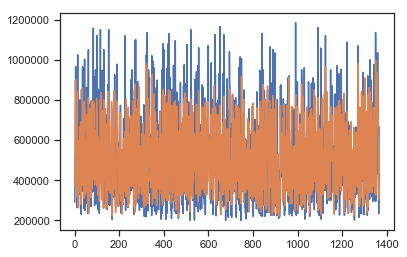

In [52]:
plt.plot([i for i in range( len(TestY) )], TestY)
plt.plot([i for i in range( len(BagRegP1) )], BagRegP1)
plt.show()

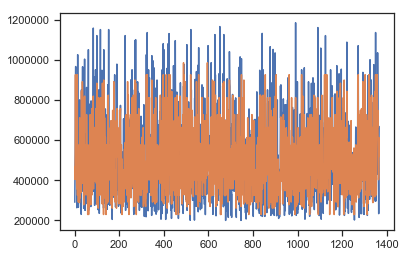

In [53]:
plt.plot([i for i in range( len(TestY) )], TestY)
plt.plot([i for i in range( len(DecTreeP1) )], DecTreeP1)
plt.show()

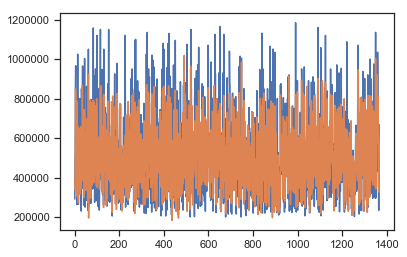

In [54]:
plt.plot([i for i in range( len(TestY) )], TestY)
plt.plot([i for i in range( len(CatModelP1) )], CatModelP1)
plt.show()

In [55]:
print("Средняя абсолютная ошибка:\t",mean_absolute_error(TestY, BagRegP1))
print("Средняя квадратичная ошибка:\t",mean_squared_error(TestY, BagRegP1))
print("Коэффициент детерминации:\t",r2_score(TestY, BagRegP1))

Средняя абсолютная ошибка:	 91525.15529968608
Средняя квадратичная ошибка:	 16294621824.401976
Коэффициент детерминации:	 0.6528095758025434


In [56]:
print("Средняя абсолютная ошибка:\t",mean_absolute_error(TestY, DecTreeP1))
print("Средняя квадратичная ошибка:\t",mean_squared_error(TestY, DecTreeP1))
print("Коэффициент детерминации:\t",r2_score(TestY, DecTreeP1))

Средняя абсолютная ошибка:	 110343.84852307629
Средняя квадратичная ошибка:	 22531654819.615353
Коэффициент детерминации:	 0.5199167627825554


In [57]:
print("Средняя абсолютная ошибка:\t",mean_absolute_error(TestY, CatModelP1))
print("Средняя квадратичная ошибка:\t",mean_squared_error(TestY, CatModelP1))
print("Коэффициент детерминации:\t",r2_score(TestY, CatModelP1))

Средняя абсолютная ошибка:	 92947.4938632131
Средняя квадратичная ошибка:	 16042576449.590813
Коэффициент детерминации:	 0.6581799207875769
